# Labraries and functions

## Load labraries

In [1]:
import os
import numpy as np
import pandas as pd
import time
import fatpack
import rainflow
import seaborn as sns
from scipy.signal import butter, filtfilt, detrend
#import torch
#from torch.utils.data import Dataset, DataLoader
#import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV

import tensorflow as tf
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import TensorBoard


from tensorflow.keras.layers import Add, BatchNormalization, Input, Conv1D, Activation, MaxPooling1D, Flatten, Dense, Dropout, MultiHeadAttention,Layer,LayerNormalization
from tensorflow.keras.models import Model
from tensorflow.keras import initializers, regularizers
from tensorflow.keras.layers import ZeroPadding1D


from keras.layers import Dense, Conv1D, BatchNormalization, MaxPooling1D, Activation, Flatten
from keras import backend as K
from keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Activation, Dropout, concatenate, BatchNormalization
from keras.regularizers import l2

from keras.models import Model



# filter the warnings
import warnings
warnings.filterwarnings("ignore")


import random
# Seed for reproducibility
def set_seed(seed=42):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)

set_seed(42)

# use gpu for tf
physical_devices = tf.config.list_physical_devices('GPU')

# check if the GPU is used
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Define functions

In [2]:
def calculate_receptive_field(kernels, strides, pools):
    """
    Calculate the receptive field for a series of convolutional and pooling layers.

    Parameters:
    - kernels (list of int): List of kernel sizes for each convolutional layer.
    - strides (list of int): List of stride values for each convolutional layer.
    - pools (list of int): List of pool sizes for each pooling layer (assumed to follow each conv layer).

    Returns:
    - int: The receptive field of the network.
    """
    receptive_field = 1
    jump = 1
    
    for kernel, stride, pool in zip(kernels, strides, pools):
        receptive_field += (kernel - 1) * jump
        jump *= stride
        receptive_field += (pool - 1) * jump
        jump *= pool
    
    return receptive_field

# Function to round values to the nearest interval of 0.5
def round_to_nearest_half(values):
    return np.round(values * 2) / 2


def custom_loss(y_true, y_pred):
    """
    Custom loss function that applies a different penalty if the prediction is less than the actual value.
    If the prediction is smaller, the loss is 2 times the usual mean squared error.
    Otherwise, the loss is the normal mean squared error.
    """
    # Calculate the squared difference
    squared_difference = tf.square(y_true - y_pred)
    
    # Check where predictions are smaller than true values
    under_prediction = tf.cast(y_pred < y_true, dtype=tf.float32)
    
    # Apply double weight to under-predictions
    weighted_squared_difference = squared_difference * (1 + under_prediction)
    
    # Return mean of weighted squared difference
    return tf.reduce_mean(weighted_squared_difference, axis=-1)


# Cyclical Learning Rate (CLR) Scheduler
class CyclicLR(tf.keras.callbacks.Callback):
    def __init__(self, base_lr, max_lr, step_size, mode='triangular'):
        super(CyclicLR, self).__init__()
        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.clr_iterations = 0
        self.trn_iterations = 0
        self.history = {}

    def clr(self):
        cycle = np.floor(1 + self.clr_iterations / (2 * self.step_size))
        x = np.abs(self.clr_iterations / self.step_size - 2 * cycle + 1)
        if self.mode == 'triangular':
            lr = self.base_lr + (self.max_lr - self.base_lr) * np.maximum(0, (1 - x))
        return lr

    def on_train_begin(self, logs=None):
        logs = logs or {}
        if self.clr_iterations == 0:
            tf.keras.backend.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            tf.keras.backend.set_value(self.model.optimizer.lr, self.clr())

    def on_batch_end(self, epoch, logs=None):
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1
        tf.keras.backend.set_value(self.model.optimizer.lr, self.clr())




def weighted_mse_exponential(y_true, y_pred):
    # Define exponential weights - ensure this matches your output size
    # Convert the base and exponent range to float32 explicitly
    
    base_weight = 1.2  # Use float to ensure type compatibility

    exponent_range = K.cast(K.arange(1, 17), 'float32')  # Explicitly cast to float32
    weights = K.pow(base_weight, exponent_range)  # Now both base and exponent are float32
    weights = K.reshape(weights, (1, 16))  # Reshape to match y_pred shape
    # normalize the weights
    weights = weights / K.sum(weights)
    
    # Calculate MSE
    error = y_true - y_pred
    squared_error = K.square(error)
    weighted_squared_error = squared_error * weights  # Apply weights
    return K.mean(weighted_squared_error, axis=-1)


def weighted_mse_exponential_modified(y_true, y_pred):
    # Define exponential weights for the first 18
    base_weight = 1.6  # Use float to ensure type compatibility
    
    # First 18 weights increasing
    exponent_range_increasing = K.cast(K.arange(1, 13), 'float32')  # Exponents for the increasing part
    increasing_weights = K.pow(base_weight, exponent_range_increasing)  # Increasing weights
    
    # Last 6 weights decreasing - Option 1: Direct computation of decreasing weights
    exponent_range_decreasing = K.cast(K.arange(1, 13), 'float32')  # Exponents for the decreasing part, could be adjusted
    decreasing_weights = K.pow(base_weight, -exponent_range_decreasing)  # Make these weights decrease
    decreasing_weights = decreasing_weights * K.pow(base_weight, 12)  # Adjust to make sure they start from where increasing part left off
    
    # Concatenate the increasing and decreasing weights
    weights = K.concatenate([increasing_weights, decreasing_weights], axis=0)
    # Normalize the weights
    weights = weights / K.sum(weights)
    weights = K.reshape(weights, (1, 24))  # Reshape to match y_pred shape

    # Calculate MSE
    error = y_true - y_pred
    squared_error = K.square(error)
    weighted_squared_error = squared_error * weights  # Apply weights
    return K.mean(weighted_squared_error, axis=-1)




def weighted_mse_exponential_normal_distribution(y_true, y_pred):
    # Parameters for the normal distribution
    mu = 10.0  # Mean of the distribution, centered at 12 for a 24-length sequence
    sigma = 3.0  # Standard deviation of the distribution
    
    # Generate indices for the weights
    x_values = tf.range(1, 21, dtype=tf.float32)
    
    # Calculate the normal distribution weights using TensorFlow operations
    weights = tf.exp(-((x_values - mu) ** 2) / (2 * sigma ** 2))
    
    # Normalize weights to ensure they sum to 1 (optional based on your requirement)
    weights /= tf.reduce_sum(weights)
    
    # Reshape weights to match y_pred shape
    weights = tf.reshape(weights, (1, 21))
    

    # Calculate weighted MSE using TensorFlow operations
    error = y_true - y_pred
    squared_error = tf.square(error)
    weighted_squared_error = squared_error * weights  # Apply weights
    return tf.reduce_mean(weighted_squared_error, axis=-1)


def weighted_mse_log_normal_distribution(y_true, y_pred):
    # Parameters for the log-normal distribution
    mu = 2.7  # Adjusted for the scale of indices, typically log of the mean of x-values
    sigma = 0.6  # Adjusted variance

    # Generate indices for the weights
    x_values = tf.range(1, 21, dtype=tf.float32)
    
    # Calculate the log-normal distribution weights using TensorFlow operations
    # Adjusting x_values to be in the domain > 0 and applying log-normal PDF formula
    weights = (1 / (x_values * sigma * tf.sqrt(2 * np.pi))) * tf.exp(-((tf.math.log(x_values) - mu) ** 2) / (2 * sigma ** 2))
    
    # Normalize weights to ensure they sum to 1 (optional based on your requirement)
    weights /= tf.reduce_sum(weights)
    
    # Reshape weights to match y_pred shape
    weights = tf.reshape(weights, (1, 21))
    
    # Calculate weighted MSE using TensorFlow operations
    error = y_true - y_pred
    squared_error = tf.square(error)
    weighted_squared_error = squared_error * weights  # Apply weights
    return tf.reduce_mean(weighted_squared_error, axis=-1)




def create_dataset(X, y, window_size,pred_num = 1):
    """"
    This function creates the dataset with the window size for lstm
    The input data might be the train_x or test_x or test_y or train_y
    The window size is the number of data points in each

    x: the input data
    y: the output data
    window_size: the number of data points in each window
    pred_num: the number of data points

    """

    Xs, ys = [], []
    for i in range(len(X) - window_size):
        v = X.iloc[i:(i + window_size)]
        Xs.append(v)
        ys.append(y.iloc[i +window_size +1-pred_num:i +window_size + 1])
    return np.array(Xs), np.array(ys) 




def plot_fft(signal, title, plot = 0, eli = 1):
    """
    This function plots the FFT of a signal.

    signal: the signal to plot the FFT of  
    title: the title of the plot
    plot: the number of points to plot
    eli: the number of points to eliminate from frequency domain
    """     
                    
    # Compute the FFT
    fft_vals = np.fft.fft(signal)
    fft_vals = np.abs(fft_vals)/len(signal)   # normalized values
    fft_vals[:eli] = 0             # eliminate the influence of first component\



    # Compute the frequencies associated with the FFT values
    # The frequency is set as 150Hz
    fft_freq = np.fft.fftfreq(len(signal),1/150)

    # Plot the FFT values vs frequencies
    plt.figure(figsize=(8, 5))
    if plot != 0:
      plt.plot(np.abs(fft_freq)[:plot], fft_vals[:plot])
    else:
      plt.plot(np.abs(fft_freq), fft_vals)
    plt.title(f'FFT of {title}')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Normalized Amplitude')
    plt.grid(True)
    plt.show()



def butter_lowpass(signal, cutoff, fs, order=5, btype='low'):
    """
    Attenuate the signal with a low-pass Butterworth

    Parameters:
    - signal: The input signal (1D numpy array).
    - cutoff: Cut-off frequency (Hz)
    - btpe: The type of filter. 'low' for low-pass filter.
    - order: The order of the filter.
    - fs: The sampling frequency of the signal (Hz).

    Returns:
    - filtered_signal: The filtered signal (1D numpy array).
    """
    # Nyquist frequency
    nyquist = 0.5 * fs
    # Normalize the frequency
    normal_cutoff = cutoff / nyquist
    
    # Design the Butterworth filter
    b, a = butter(order, normal_cutoff, btype=btype)
    # Apply the filter
    filtered_signal = filtfilt(b, a, signal)

    return filtered_signal




def zero_out_frequency_range_fft(signal, lowcut, highcut, fs = 150):
    """
    Zero out a specific frequency range in a signal using FFT.

    Parameters:
    - signal: The input signal (1D numpy array).
    - lowcut: The lower frequency bound to zero out (Hz).
    - highcut: The upper frequency bound to zero out (Hz).
    - fs: The sampling frequency of the signal (Hz).

    Returns:
    - signal_filtered: The signal with the specified frequency range zeroed out.
    """
    # Perform FFT
    signal_fft = np.fft.fft(signal)
    # Get the frequency bins
    freq = np.fft.fftfreq(len(signal), 1/fs)
    
    # Zero out the desired frequency range
    # Use np.logical_and to find the indices where the frequency range falls
    mask = np.logical_or(freq < highcut, freq > lowcut)
    mask = np.logical_or(mask, freq > -lowcut)
    mask = np.logical_or(mask, freq < -highcut)
    signal_fft[mask] = 0

    # Perform inverse FFT
    signal_filtered = np.fft.ifft(signal_fft)

    # Since the imaginary part is due to numerical error, we take only the real part
    return np.real(signal_filtered)


def find_time_delay(signal1, signal1_name, signal2, signal2_name, fs, sensor_data = True, save_plot=False):
    """
    Find the time delay between two signals based on cross-correlation.
    
    :param signal1: The first signal (array-like).
    :param signal2: The second signal (array-like).
    :param fs: Sampling frequency of the signals.
    :return: Time delay in seconds.
    """
    # Compute cross-correlation
    correlation = np.correlate(signal1, signal2, mode='full')
    
    # Find the lag corresponding to the maximum correlation
    lag_idx = np.argmax(correlation) - (len(signal2) - 1)
    
    # Convert lag to time in seconds
    time_delay = lag_idx / fs
    
    # Visualize the cross-correlation process
    lags = np.arange(-len(signal2) + 1, len(signal1))
    time_lags = lags / fs
    plt.figure(figsize=(12, 6))
    plt.plot(time_lags, correlation)
    if sensor_data:
        title = 'Cross-Correlation of signal '+signal1_name+' and '+signal2_name +' (sensor)'
    else:
        title = 'Cross-Correlation of signal '+signal1_name+' and '+signal2_name +' (FEM data)' 
    plt.title(title)
    plt.xlabel('Time Lag (s)')
    plt.ylabel('Cross-Correlation Amplitude')
    plt.axvline(time_delay, color='r', linestyle='--', label=f'Time Delay: {time_delay}s')
    plt.legend()
    plt.grid(True)
    if save_plot:
        plt.savefig(title+'.svg', dpi=1000)
    
    plt.show()
    
    return time_delay



def decompose_signal(signal, num_components=10):
    # Compute the FFT of the signal
    spectrum = np.fft.fft(signal)
    
    # Get the length of the signal
    N = len(signal)
    
    # Determine the size of each section
    section_size = N // num_components
    
    # List to store the components
    components = []
    
    for i in range(num_components):
        # Copy the spectrum to zero out other frequencies
        temp_spectrum = np.zeros_like(spectrum)
        
        # Determine the start and end indices for this section
        start_idx = i * section_size
        end_idx = (i + 1) * section_size
        
        # Retain only the frequencies in this section
        temp_spectrum[start_idx:end_idx] = spectrum[start_idx:end_idx]
        
        # Compute the inverse FFT to get the component
        component = np.fft.ifft(temp_spectrum)
        
        components.append(component)
    
    return components



# define a function to plot the components
def plot_components(components, title=None):
    # Get the number of components
    num_components = len(components)
     
    plt.figure(figsize=(14, 6))
    #plt.plot(np.arange(num_components), signal, label="Original Signal", color="black", linewidth=2)
    for i, component in enumerate(components):
        plt.plot(component, label=f"Component {i}")
    
        plt.legend()
        plt.title("Original Signal and its Components")
        plt.xlabel("Time")
        plt.ylabel("Amplitude")
        plt.grid(True)
    plt.title(title)
    # Display the plot
    plt.show()


    # def a function to save the decompose_signal() to the dataframe with name 'ACC1_component_0', 'ACC1_component_1', ...
# only save the real part of the components
def save_components(data, column_name, num_components=10):
    components = decompose_signal(data[column_name], num_components=num_components)
    for i, component in enumerate(components):
        data[f"{column_name}_component_{i}"] = component.real
    return data



def extract_max_magnitude_component(signal, sampling_rate, freq_range):
    # Perform FFT on the signal
    signal_fft = np.fft.fft(signal)
    frequencies = np.fft.fftfreq(len(signal), 1/sampling_rate)

    # Consider only positive frequencies
    positive_mask = frequencies > 0
    signal_fft = signal_fft[positive_mask]
    frequencies = frequencies[positive_mask]

    # Plot the magnitude of the FFT (for visualization)
    plt.figure()
    plt.plot(frequencies, np.abs(signal_fft))
    plt.title('Magnitude of FFT')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.grid(True)

    # Identify the frequency component with the highest magnitude within the specified frequency range
    range_mask = (frequencies >= freq_range[0]) & (frequencies <= freq_range[1])
    max_magnitude_freq = frequencies[range_mask][np.argmax(np.abs(signal_fft[range_mask]))]

    # Zero out all components except the frequency with the highest magnitude in the given range
    full_signal_fft = np.fft.fft(signal)
    full_signal_fft[np.abs(np.fft.fftfreq(len(signal), 1/sampling_rate)) != max_magnitude_freq] = 0

    # Perform inverse FFT to get the time-domain signal of the target frequency
    extracted_signal = np.fft.ifft(full_signal_fft).real

    # Plot the extracted signal (for visualization)
    plt.figure()
    plt.plot(extracted_signal)
    plt.title(f'Extracted Signal at {max_magnitude_freq:.2f} Hz')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.grid(True)

    plt.show()

    return extracted_signal


# define a funtion to reconstrute the singal from each component with the same prefix in the dataframe
def reconstruct_signal(data, column_prefix):
    # Get the columns with the given prefix
    component_columns = [col for col in data.columns if col.startswith(column_prefix)]
    
    # Get the number of components
    num_components = len(component_columns)
    
    # Initialize the reconstructed signal to be all zeros
    reconstructed_signal = np.zeros_like(data[component_columns[0]])
    
    # Iterate through the components and add them up
    for i in range(num_components):
        reconstructed_signal += data[component_columns[i]]
    
    return reconstructed_signal

# Load data

In [3]:
#Specify the folder location containing the .csv files
folderPath = "../Data/Bryngeån Bridge"

#Get a list of all .csv files in the specified folder

fileList = os.listdir(folderPath)
fileList = [f for f in fileList if f.endswith('.csv')]
print(len(fileList))


200


In [4]:
# Load the data from the all the .csv files into a dataframe and store the dataframe in a dictionary with the file name as the key
data = {}
for file in fileList:
    data[file] = pd.read_csv(os.path.join(folderPath, file)).astype('float32')

# Print the first few rows of the first file
print(data[fileList[0]].head())

# Print the column names of the first file
print(data[fileList[0]].columns)

      acc_1     acc_2     acc_3     acc_4    strain_1    strain_2       WIM_1  \
0  0.000443 -0.013904 -0.020153 -0.013263  448.345215  246.012238 -219.240845   
1 -0.000295 -0.014927 -0.019413 -0.014806  449.296722  246.665237 -219.341644   
2  0.001208 -0.014512 -0.019102 -0.013355  448.921021  246.084763 -219.327042   
3  0.001038 -0.012496 -0.019093 -0.014550  448.110596  245.059540 -219.237030   
4  0.001706 -0.014530 -0.021726 -0.016259  448.792633  246.357407 -219.351257   

        WIM_2  offset_stress_1  Range  Cycles    velocity  
0 -127.692909        -0.075097    2.0  1332.0  139.354843  
1 -127.784721         0.124720    4.0     7.5  139.354843  
2 -127.717682         0.045822    6.0     3.0  139.354843  
3 -127.702187        -0.124367    8.0     5.0  139.354843  
4 -127.703873         0.018861   10.0     1.5  139.354843  
Index(['acc_1', 'acc_2', 'acc_3', 'acc_4', 'strain_1', 'strain_2', 'WIM_1',
       'WIM_2', 'offset_stress_1', 'Range', 'Cycles', 'velocity'],
      dtyp

In [5]:
data[fileList[0]].head()

acc_1     acc_2     acc_3     acc_4    strain_1    strain_2       WIM_1  \
0  0.000443 -0.013904 -0.020153 -0.013263  448.345215  246.012238 -219.240845   
1 -0.000295 -0.014927 -0.019413 -0.014806  449.296722  246.665237 -219.341644   
2  0.001208 -0.014512 -0.019102 -0.013355  448.921021  246.084763 -219.327042   
3  0.001038 -0.012496 -0.019093 -0.014550  448.110596  245.059540 -219.237030   
4  0.001706 -0.014530 -0.021726 -0.016259  448.792633  246.357407 -219.351257   

        WIM_2  offset_stress_1  Range  Cycles    velocity  
0 -127.692909        -0.075097    2.0  1332.0  139.354843  
1 -127.784721         0.124720    4.0     7.5  139.354843  
2 -127.717682         0.045822    6.0     3.0  139.354843  
3 -127.702187        -0.124367    8.0     5.0  139.354843  
4 -127.703873         0.018861   10.0     1.5  139.354843

In [6]:
acc_2_only = False

In [7]:
# For each dataframe in the dictionary, save the components of the acc_2 and acc_4 signals to the dataframe
for file in fileList:
    if acc_2_only:
        # drop the columns acc_1, acc_3, strain_2, WIM_1 and WIM_2
        data[file] = data[file].drop(columns=['acc_1', 'acc_3', 'strain_2', 'WIM_1', 'WIM_2','acc_4'])
        # offset correction for strain_1
        data[file]['strain_1'] = data[file]['strain_1'] - data[file]['strain_1'][4000:].mean()
        # offset correction for acc_2
        data[file]['acc_2'] = data[file]['acc_2'] - data[file]['acc_2'][4000:].mean()
        # put the strain_1 to the first column
        data[file] = data[file][['strain_1', 'acc_2','offset_stress_1','Range','Cycles','velocity']]
        #data[file] = save_components(data[file], 'acc_2', num_components = num_component)
    else:
        # drop the columns acc_1, acc_3, strain_2, WIM_1 and WIM_2
        #data[file] = data[file].drop(columns=['acc_1', 'acc_3', 'strain_2', 'WIM_1', 'WIM_2'])
        #data[file] = data[file].drop(columns=[ 'strain_2', 'WIM_1', 'WIM_2'])
        data[file] = data[file].drop(columns=[ 'WIM_1', 'WIM_2'])
        # offset correction for strain_1
        data[file]['strain_1'] = data[file]['strain_1'] - data[file]['strain_1'][4000:].mean()
        data[file]['strain_2'] = data[file]['strain_2'] - data[file]['strain_2'][4000:].mean()
        # offset correction for acc_2
        data[file]['acc_1'] = data[file]['acc_1'] - data[file]['acc_1'][4000:].mean()
        data[file]['acc_2'] = data[file]['acc_2'] - data[file]['acc_2'][4000:].mean()
        data[file]['acc_3'] = data[file]['acc_3'] - data[file]['acc_3'][4000:].mean()
        data[file]['acc_4'] = data[file]['acc_4'] - data[file]['acc_4'][4000:].mean()
        # put the strain_1 to the first column
        data[file] = data[file][['strain_1','strain_2', 'acc_2', 'acc_1','acc_3','acc_4','offset_stress_1','Range','Cycles','velocity']]
        #data[file] = save_components(data[file], 'acc_2', num_components = num_component)
        #data[file] = save_components(data[file], 'acc_1', num_components = num_component)

In [8]:
data[fileList[0]]

strain_1  strain_2     acc_2     acc_1     acc_3     acc_4  \
0    -0.360565 -0.746643  0.000230 -0.000777  0.000281  0.001827   
1     0.590942 -0.093643 -0.000793 -0.001515  0.001021  0.000284   
2     0.215240 -0.674118 -0.000377 -0.000011  0.001333  0.001735   
3    -0.595184 -1.699341  0.001639 -0.000181  0.001341  0.000540   
4     0.086853 -0.401474 -0.000396  0.000486 -0.001292 -0.001169   
...        ...       ...       ...       ...       ...       ...   
4495  0.349335  0.045120 -0.000803  0.000605  0.000181 -0.000519   
4496 -0.194611 -0.105988  0.000066 -0.000694  0.000013  0.000280   
4497 -1.191223 -0.891220  0.000063 -0.000990 -0.000065  0.000243   
4498  0.360596  0.601730 -0.001048 -0.000808 -0.000009 -0.001166   
4499 -0.054901  0.034668 -0.000524 -0.001725 -0.000238 -0.000245   

      offset_stress_1  Range  Cycles    velocity  
0           -0.075097    2.0  1332.0  139.354843  
1            0.124720    4.0     7.5  139.354843  
2            0.045822    6.0     3.0  139.354843  
3           -0.124367    8.0     5.0  139.354843  
4            0.018861   10.0     1.5  139.354843  
...               ...    ...     ...         ...  
4495         0.073982    NaN     NaN  139.354843  
4496        -0.040247    NaN     NaN  139.354843  
4497        -0.249535    NaN     NaN  139.354843  
4498         0.076347    NaN     NaN  139.354843  
4499        -0.010908    NaN     NaN  139.354843  

[4500 rows x 10 columns]

In [9]:
# find the anomaly data for acc_4
for file in fileList:
    if data[file]['acc_3'].max() > 2:
        print(file)
        print(data[file]['acc_3'].max())


bridge_2022_04_04_0738.csv
2.016887903213501
bridge_2022_09_06_1417.csv
2.222437858581543
bridge_2022_09_25_1415.csv
2.428755283355713
bridge_2022_12_04_2020.csv
1000002.25


In [10]:
# delete data["bridge_2022_12_04_2020.csv"]
#del data["bridge_2022_12_04_2020.csv"]

# delete "bridge_2022_12_04_2020.csv" from fileList
#fileList = [f for f in fileList if f != "bridge_2022_12_04_2020.csv"]

In [11]:
# overwrite data["bridge_2022_12_04_2020.csv"]['acc_3'] with data["bridge_2022_12_04_2020.csv"]['acc_4'] but keep the coumn name as 'acc_3'
#data["bridge_2022_12_04_2020.csv"]['acc_3'] = data["bridge_2022_12_04_2020.csv"]['acc_4']
#plt.plot(data["bridge_2022_12_04_2020.csv"]['acc_3'], label='acc_3')


## Data visulization 

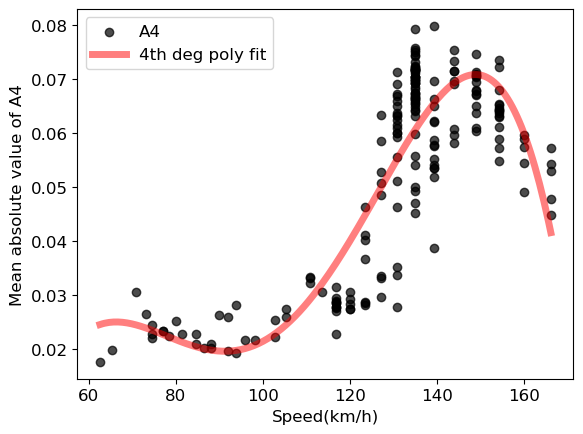

In [14]:

# Gather the data into arrays
velocities = []
max_acc = []
for file in fileList:
    velocities.append(data[file]['velocity'][0])
    max_acc.append(abs(data[file]['acc_4']).mean())

velocities = np.array(velocities)
max_acc = np.array(max_acc)

# Sort the data by velocity so the fitted line is plotted nicely
sort_idx = np.argsort(velocities)
x_sorted = velocities[sort_idx]
y_sorted = max_acc[sort_idx]

# Fit a 2nd- (or 3rd/4th-) degree polynomial
degree = 4
coeffs = np.polyfit(x_sorted, y_sorted, deg=degree)
p = np.poly1d(coeffs)

# Evaluate the polynomial on a grid of points
x_fit = np.linspace(x_sorted[0], x_sorted[-1], 200)
y_fit = p(x_fit)

plt.scatter(x_sorted, y_sorted, label='A4', color='black',alpha=0.7)
# change the linewidth of the fitted line to 2
plt.plot(x_fit, y_fit, 'r', label=f'{degree}th deg poly fit', linewidth=5, alpha=0.5)
plt.xlabel('Speed(km/h)',fontsize=12)
plt.ylabel('Mean absolute value of A4',fontsize=12)
#plt.title('Scatter with 4th-Order Polynomial Fit',fontsize=12)
#set the fontsize of the legend
plt.legend(fontsize=12)
# set the fontsize of the ticks
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.grid(True)

# save the figure as a svg file
plt.savefig('Figure17b.svg', dpi=1000)
plt.show()


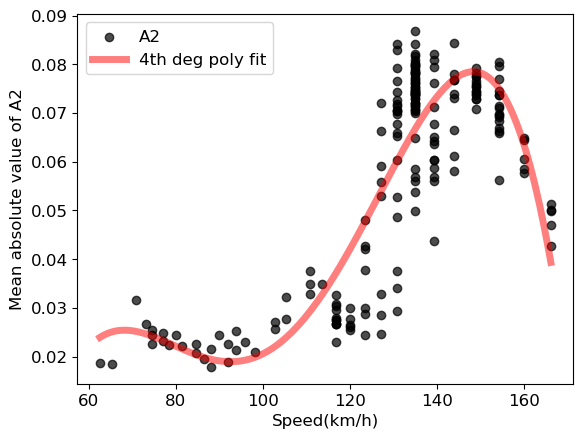

In [15]:

# Gather the data into arrays
velocities = []
max_acc = []
for file in fileList:
    velocities.append(data[file]['velocity'][0])
    max_acc.append(abs(data[file]['acc_2']).mean())

velocities = np.array(velocities)
max_acc = np.array(max_acc)

# Sort the data by velocity so the fitted line is plotted nicely
sort_idx = np.argsort(velocities)
x_sorted = velocities[sort_idx]
y_sorted = max_acc[sort_idx]

# Fit a 2nd- (or 3rd/4th-) degree polynomial
degree = 4
coeffs = np.polyfit(x_sorted, y_sorted, deg=degree)
p = np.poly1d(coeffs)

# Evaluate the polynomial on a grid of points
x_fit = np.linspace(x_sorted[0], x_sorted[-1], 200)
y_fit = p(x_fit)

plt.scatter(x_sorted, y_sorted, label='A2', color='black',alpha=0.7)
# change the linewidth of the fitted line to 2
plt.plot(x_fit, y_fit, 'r', label=f'{degree}th deg poly fit', linewidth=5, alpha=0.5)
plt.xlabel('Speed(km/h)',fontsize=12)
plt.ylabel("Mean absolute value of A2",fontsize=12)
#plt.title('Scatter with 4th-Order Polynomial Fit',fontsize=12)
#set the fontsize of the legend
plt.legend(fontsize=12)
# set the fontsize of the ticks
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.grid(True)

# save the figure as a svg file
plt.savefig('Figure17a.svg', dpi=1000)
plt.show()


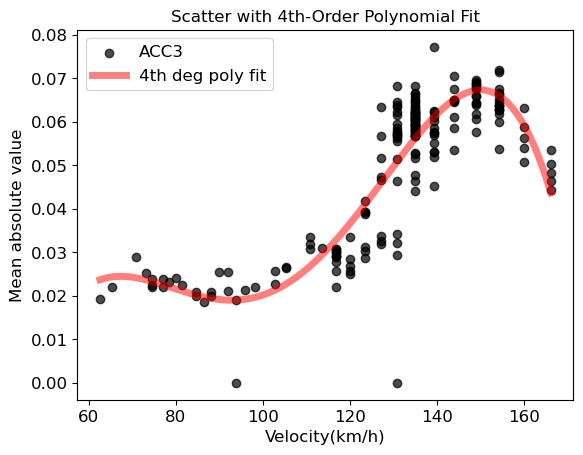

In [357]:

# Gather the data into arrays
velocities = []
max_acc = []
for file in fileList:
    if abs(data[file]['acc_3']).mean()< 2:
        max_acc.append(abs(data[file]['acc_3']).mean())
        velocities.append(data[file]['velocity'][0])

velocities = np.array(velocities)
max_acc = np.array(max_acc)

# Sort the data by velocity so the fitted line is plotted nicely
sort_idx = np.argsort(velocities)
x_sorted = velocities[sort_idx]
y_sorted = max_acc[sort_idx]

# Fit a 2nd- (or 3rd/4th-) degree polynomial
degree = 4
coeffs = np.polyfit(x_sorted, y_sorted, deg=degree)
p = np.poly1d(coeffs)

# Evaluate the polynomial on a grid of points
x_fit = np.linspace(x_sorted[0], x_sorted[-1], 200)
y_fit = p(x_fit)

plt.scatter(x_sorted, y_sorted, label='ACC3', color='black',alpha=0.7)
# change the linewidth of the fitted line to 2
plt.plot(x_fit, y_fit, 'r', label=f'{degree}th deg poly fit', linewidth=5, alpha=0.5)
plt.xlabel('Velocity(km/h)',fontsize=12)
plt.ylabel('Mean absolute value',fontsize=12)
plt.title('Scatter with 4th-Order Polynomial Fit',fontsize=12)
#set the fontsize of the legend
plt.legend(fontsize=12)
# set the fontsize of the ticks
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.grid(True)
plt.show()


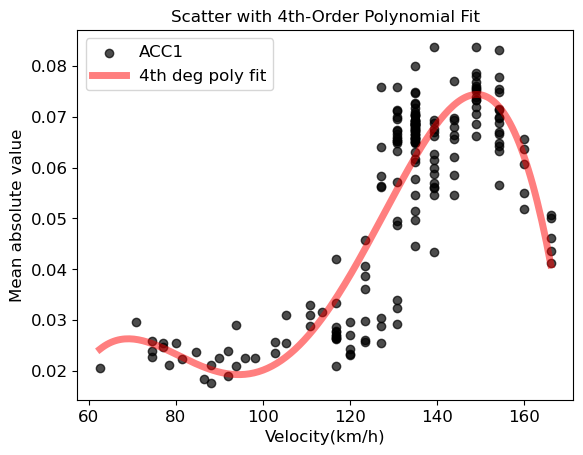

In [358]:

# Gather the data into arrays
velocities = []
max_acc = []
for file in fileList:
    if abs(data[file]['acc_1']).mean()< 0.1:
        max_acc.append(abs(data[file]['acc_1']).mean())
        velocities.append(data[file]['velocity'][0])

velocities = np.array(velocities)
max_acc = np.array(max_acc)

# Sort the data by velocity so the fitted line is plotted nicely
sort_idx = np.argsort(velocities)
x_sorted = velocities[sort_idx]
y_sorted = max_acc[sort_idx]

# Fit a 2nd- (or 3rd/4th-) degree polynomial
degree = 4
coeffs = np.polyfit(x_sorted, y_sorted, deg=degree)
p = np.poly1d(coeffs)

# Evaluate the polynomial on a grid of points
x_fit = np.linspace(x_sorted[0], x_sorted[-1], 200)
y_fit = p(x_fit)

plt.scatter(x_sorted, y_sorted, label='ACC1', color='black',alpha=0.7)
# change the linewidth of the fitted line to 2
plt.plot(x_fit, y_fit, 'r', label=f'{degree}th deg poly fit', linewidth=5, alpha=0.5)
plt.xlabel('Velocity(km/h)',fontsize=12)
plt.ylabel('Mean absolute value',fontsize=12)
plt.title('Scatter with 4th-Order Polynomial Fit',fontsize=12)
#set the fontsize of the legend
plt.legend(fontsize=12)
# set the fontsize of the ticks
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.grid(True)
plt.show()


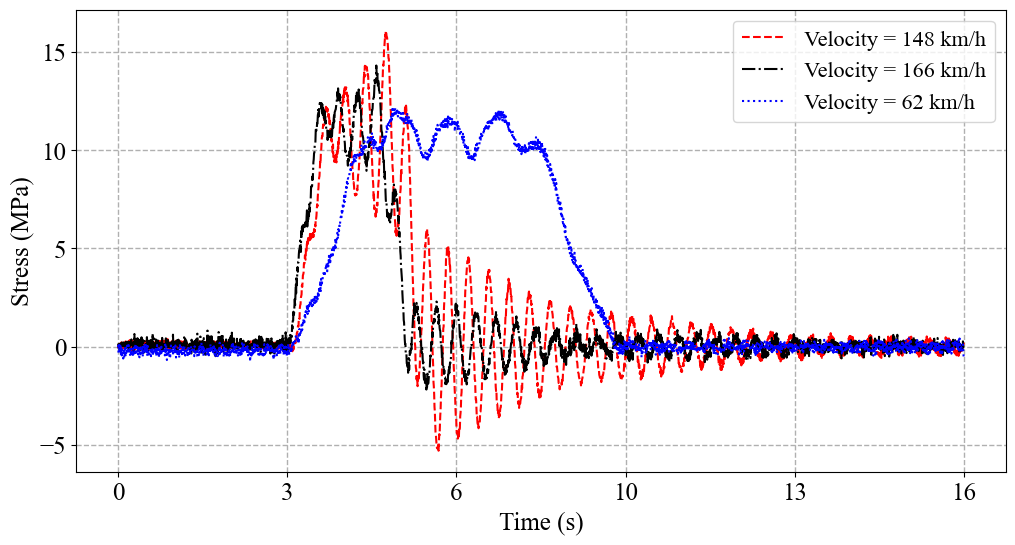

In [12]:
plt.figure(figsize=(12, 6))
plt.plot(data[fileList[7]].iloc[:2500, 0]*0.21, color ='red',  label='Velocity = '+str(int(data[fileList[7]]['velocity'][0])) +  ' km/h',linestyle='--')
plt.plot(data[fileList[83]].iloc[:2500, 0]*0.21,  color ='black',  label='Velocity = '+str(int(data[fileList[83]]['velocity'][0]))  +  ' km/h',linestyle='-.')
plt.plot(data[fileList[25]].iloc[:2500, 0]*0.21, color ='blue',   label='Velocity = '+str(int(data[fileList[25]]['velocity'][0])) +  ' km/h',linestyle='dotted')
#plt.title("Strain signal Of " + str(1))
# add the velocity of each train to the plot
plt.xlabel("Time (s)",fontdict={"size":18, "font":"Times New Roman"})
plt.ylabel("Stress (MPa)",fontdict={"size":18, "font":"Times New Roman"})
# set the fontsize of the legend and set the font to Times New Roman
plt.legend(prop={'family':'Times New Roman', 'size':16})
# set the fontsize of the ticks
plt.xticks(fontsize=18, fontname = "Times New Roman")
plt.yticks(fontsize=18, fontname = "Times New Roman")
plt.grid(True, which='both', linestyle='--', linewidth=1.0)
#  multply the x ticks with 1/150
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: int(x/150)))

# save the figure as a svg file
plt.savefig('Figure18.svg', dpi=1000)

plt.show()

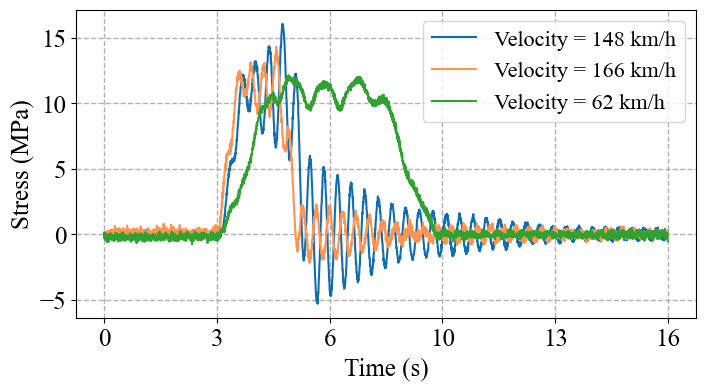

In [160]:
plt.figure(figsize=(8, 4))
plt.plot(data[fileList[7]].iloc[:2500, 0]*0.21, color =(15/255, 110/255, 175/255),  label='Velocity = '+str(int(data[fileList[7]]['velocity'][0])) +  ' km/h')
plt.plot(data[fileList[83]].iloc[:2500, 0]*0.21,  color =(255/255, 147/255, 81/255),  label='Velocity = '+str(int(data[fileList[83]]['velocity'][0]))  +  ' km/h')
plt.plot(data[fileList[25]].iloc[:2500, 0]*0.21, color =(48/255, 162/255, 48/255),   label='Velocity = '+str(int(data[fileList[25]]['velocity'][0])) +  ' km/h')
#plt.title("Strain signal Of " + str(1))
# add the velocity of each train to the plot
plt.xlabel("Time (s)",fontdict={"size":18, "font":"Times New Roman"})
plt.ylabel("Stress (MPa)",fontdict={"size":18, "font":"Times New Roman"})
# set the fontsize of the legend and set the font to Times New Roman
plt.legend(prop={'family':'Times New Roman', 'size':16})
# set the fontsize of the ticks
plt.xticks(fontsize=18, fontname = "Times New Roman")
plt.yticks(fontsize=18, fontname = "Times New Roman")
plt.grid(True, which='both', linestyle='--', linewidth=1.0)
#  multply the x ticks with 1/150
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: int(x/150)))

plt.show()

In [16]:
data[fileList[0]].head()

strain_1  strain_2     acc_2     acc_1     acc_3     acc_4  \
0 -0.360565 -0.746643  0.000230 -0.000777  0.000281  0.001827   
1  0.590942 -0.093643 -0.000793 -0.001515  0.001021  0.000284   
2  0.215240 -0.674118 -0.000377 -0.000011  0.001333  0.001735   
3 -0.595184 -1.699341  0.001639 -0.000181  0.001341  0.000540   
4  0.086853 -0.401474 -0.000396  0.000486 -0.001292 -0.001169   

   offset_stress_1  Range  Cycles    velocity  
0        -0.075097    2.0  1332.0  139.354843  
1         0.124720    4.0     7.5  139.354843  
2         0.045822    6.0     3.0  139.354843  
3        -0.124367    8.0     5.0  139.354843  
4         0.018861   10.0     1.5  139.354843

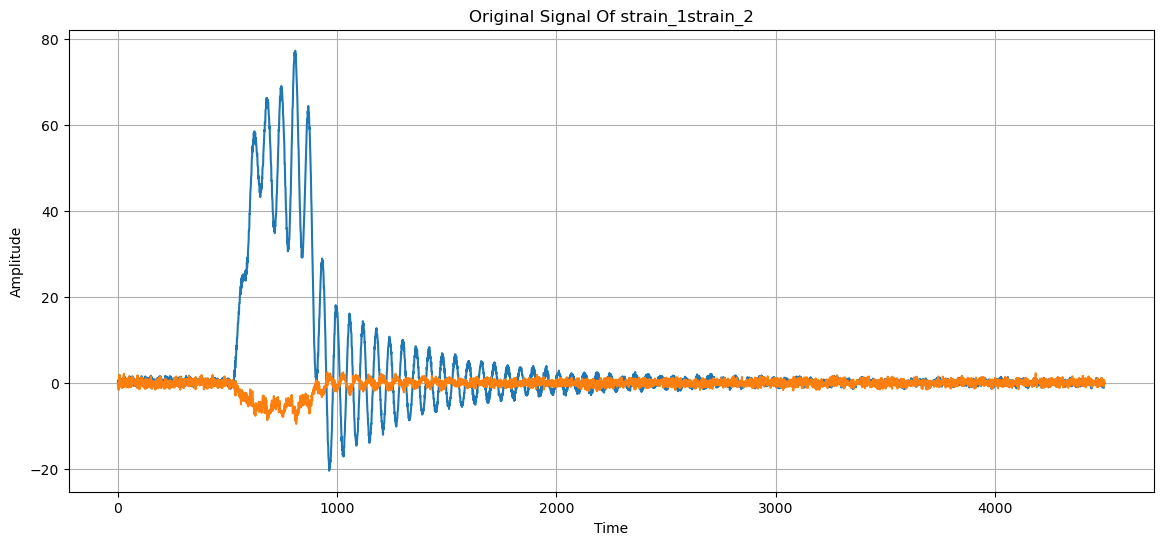

In [17]:
#plot the original signal acc_2
plt.figure(figsize=(14, 6))
plt.plot(data[fileList[0]].iloc[:, 0],label= data[fileList[0]].columns[0])
plt.plot(data[fileList[0]].iloc[:, 1],label= data[fileList[0]].columns[1])
plt.title("Original Signal Of " + data[fileList[0]].columns[0] + data[fileList[1]].columns[1])
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

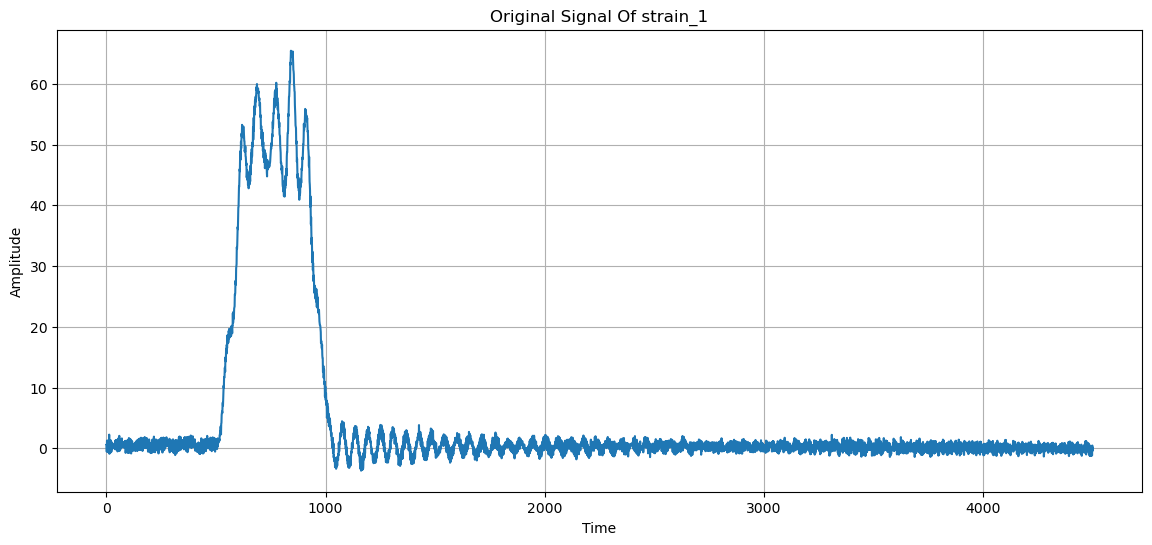

In [163]:
#plot the original signal acc_2
plt.figure(figsize=(14, 6))
plt.plot(data[fileList[18]].iloc[:, 0])
plt.title("Original Signal Of " + data[fileList[18]].columns[0])
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

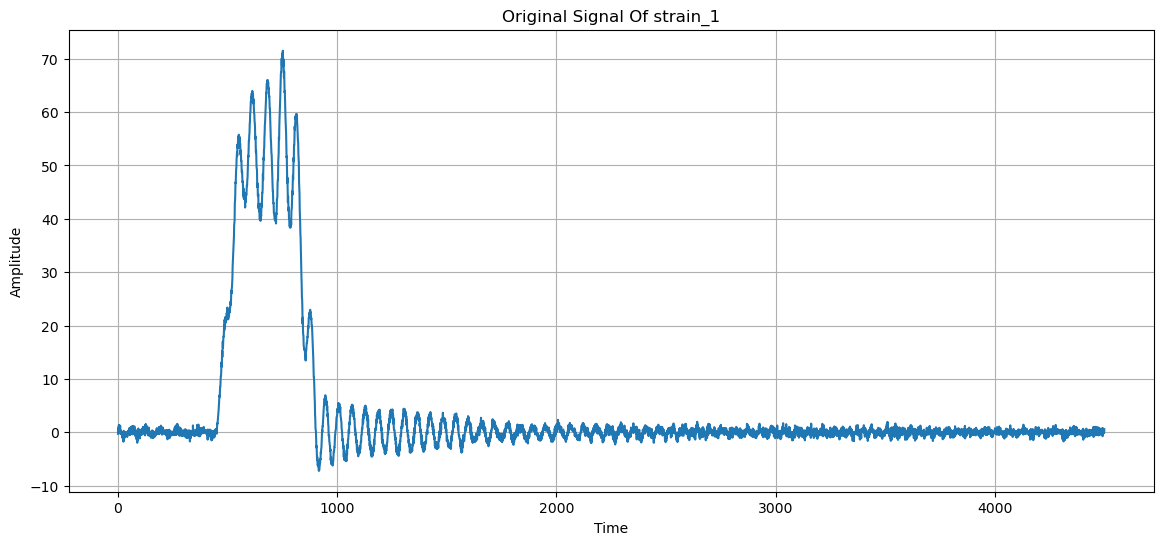

In [164]:
#plot the original signal acc_2
plt.figure(figsize=(14, 6))
plt.plot(data[fileList[94]].iloc[:, 0])
plt.title("Original Signal Of " + data[fileList[94]].columns[0])
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

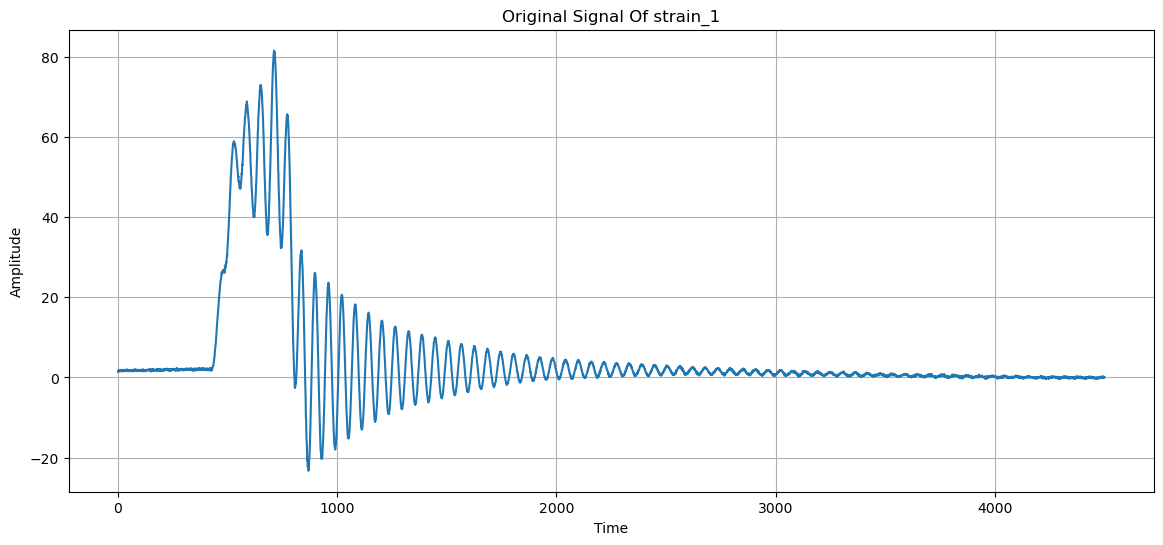

In [165]:
#plot the original signal acc_2
plt.figure(figsize=(14, 6))
plt.plot(data[fileList[181]].iloc[:, 0])
plt.title("Original Signal Of " + data[fileList[181]].columns[0])
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()


In [166]:
below_100_num = list([25,29,61,70,72,88,90,97,102,122,135,144,156,159,162,165,171,178,180,182,184,192,194,199])

In [167]:
#above_100_below_135_num  contains the file number of the data in the low_speed_num list except the file number in the below_100_num list
above_100_below_135_num = list([5, 17, 18, 19, 23, 27, 30, 33, 35, 37, 38, 39, 40, 42, 54, 57, 64, 66, 67, 84, 94, 109, 115, 124, 127, 130, 145, 151, 160, 161, 170, 174, 176, 185, 191])

In [168]:
# check the velocity of the low speed data
speed_below_100 = []
for i in below_100_num:
    speed_below_100.append(data[fileList[i]]['velocity'][0])
    

In [169]:
# check the velocity of the low speed data
speed_above_100_below_135= []
for i in above_100_below_135_num:
    speed_above_100_below_135.append(data[fileList[i]]['velocity'][0])

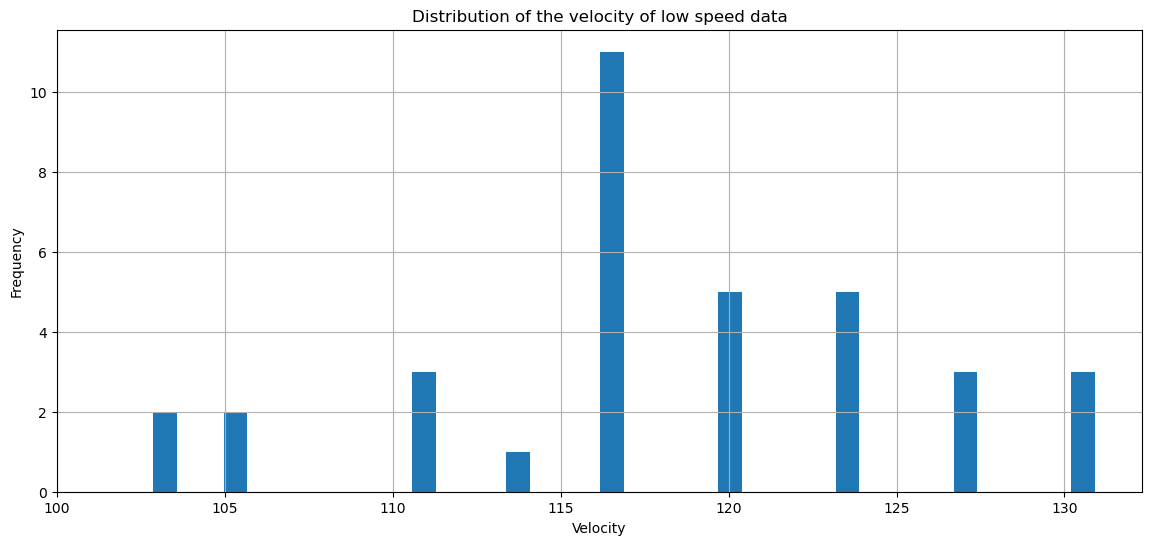

In [170]:
#plot the distribution of the velocity
plt.figure(figsize=(14, 6))
plt.hist(speed_above_100_below_135, bins=40)
plt.title("Distribution of the velocity of low speed data")
plt.xlabel("Velocity")
plt.ylabel("Frequency")
plt.xticks(np.arange(100, 135, 5))
plt.grid(True)
plt.show()

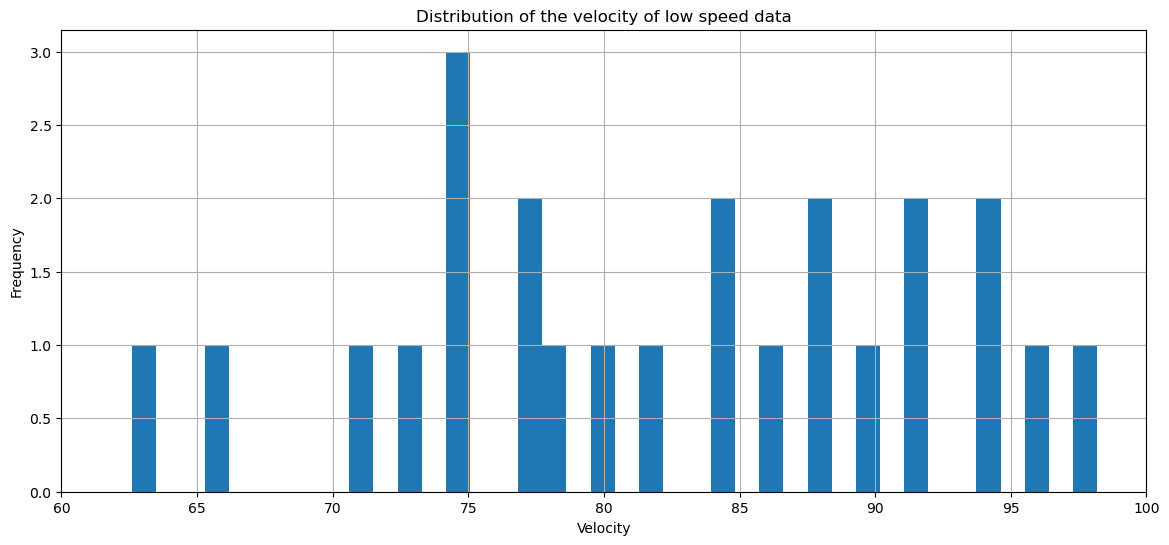

In [171]:
#plot the distribution of the velocity
plt.figure(figsize=(14, 6))
plt.hist(speed_below_100, bins=40)
plt.title("Distribution of the velocity of low speed data")
plt.xlabel("Velocity")
plt.ylabel("Frequency")
plt.xticks(np.arange(60, 105, 5))
plt.grid(True)
plt.show()


In [172]:
# check the velocity of the low speed data
#low_speed = []
#for i in low_speed_num:
#    low_speed.append(data[fileList[i]]['velocity'][0])
    

In [173]:
medium_speed_num = list([83,96,125,154])

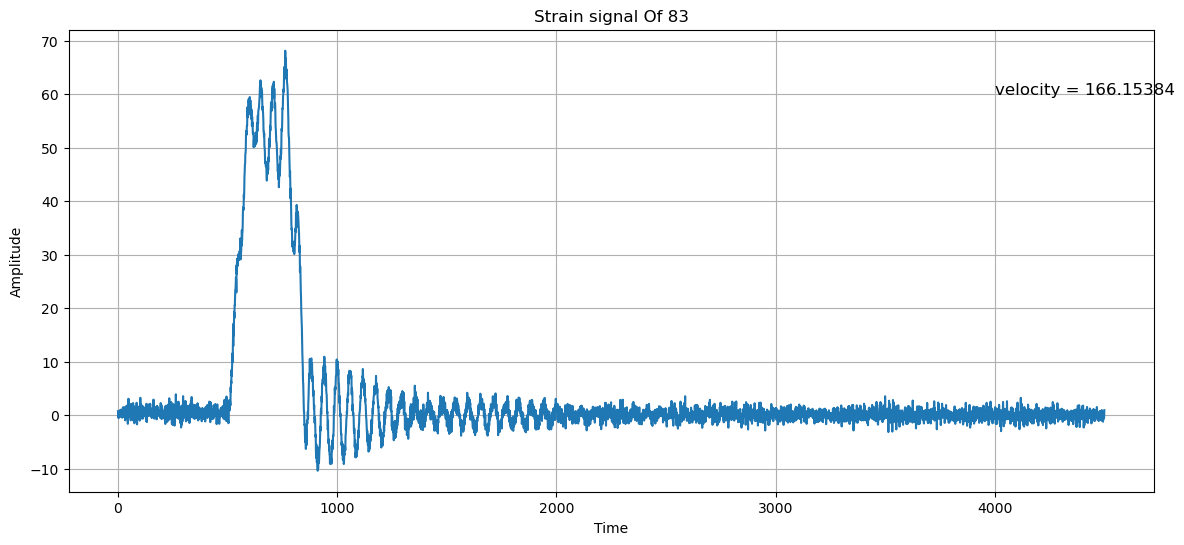

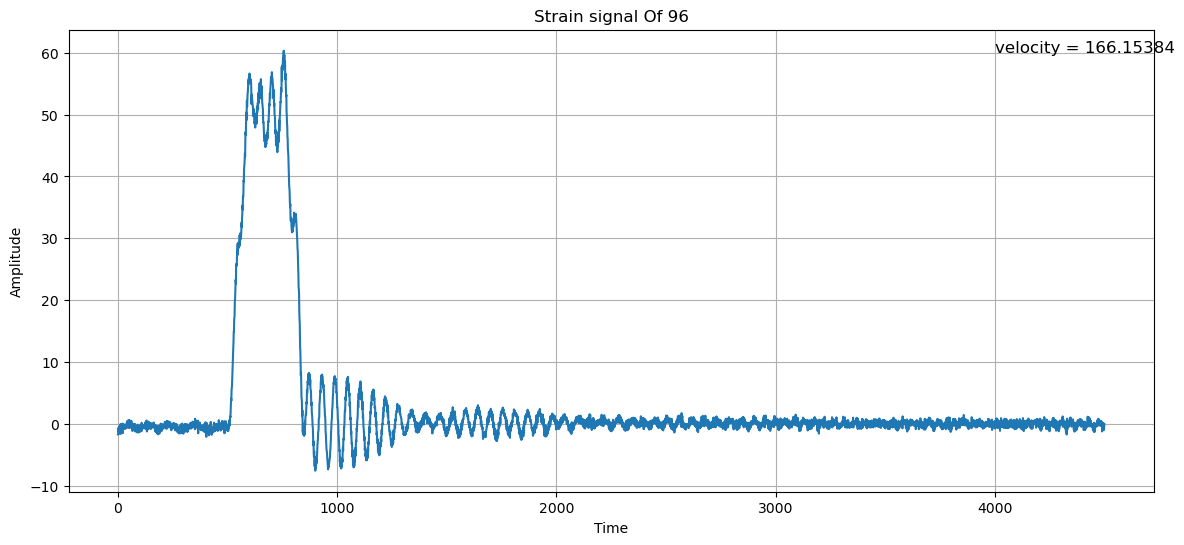

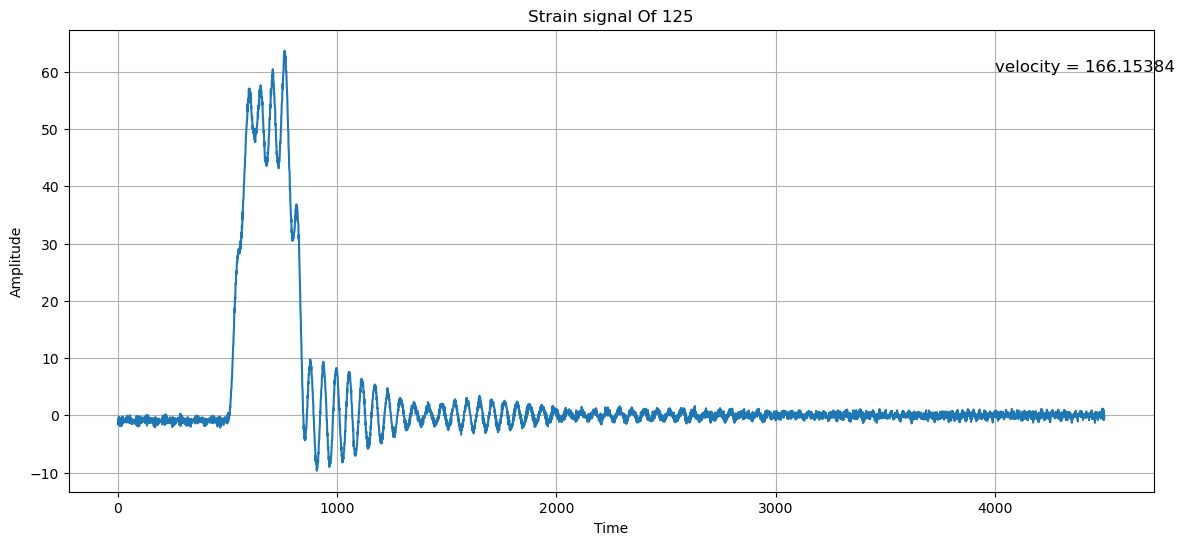

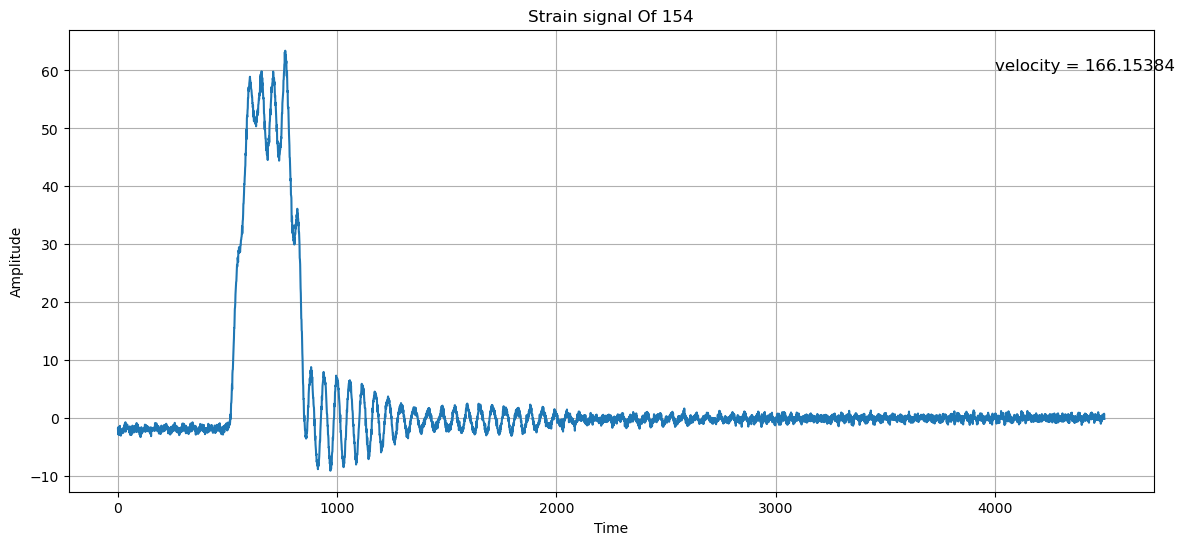

In [174]:
# plot all stains data in the medium speed data
for i in medium_speed_num:
    plt.figure(figsize=(14, 6))
    plt.plot(data[fileList[i]].iloc[:, 0])
    plt.title("Strain signal Of " + str(i))
    # add the velocity of each train to the plot
    plt.text(4000, 60, 'velocity = '+str(data[fileList[i]]['velocity'][0]), fontsize=12)
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.show()

In [175]:
# check the velocity of the low speed data
medium_speed = []
for i in medium_speed_num:
    medium_speed.append(data[fileList[i]]['velocity'][0])

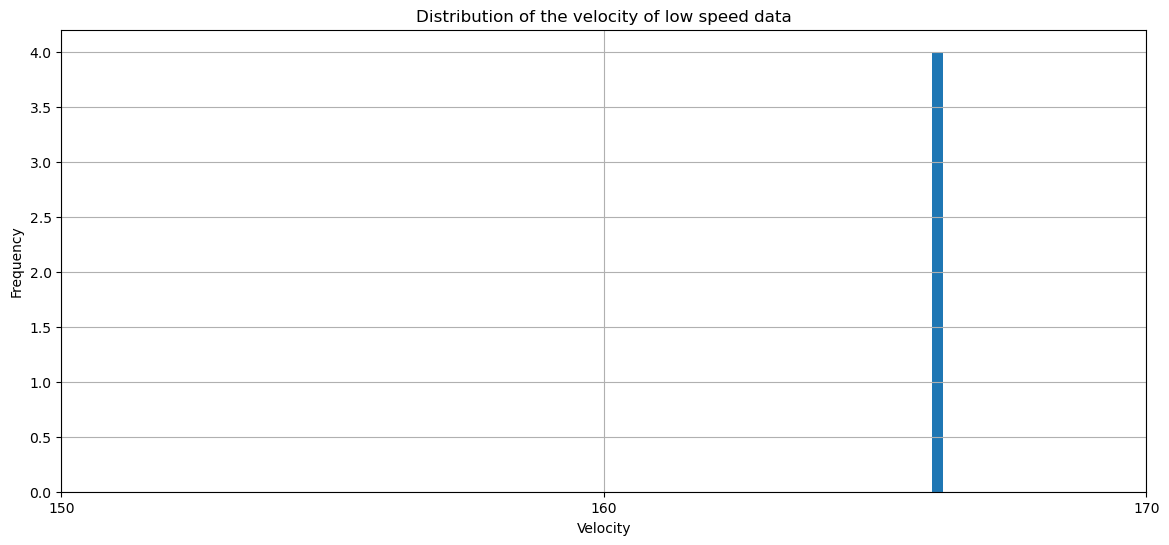

In [176]:
#plot the distribution of the velocity
plt.figure(figsize=(14, 6))
plt.hist(medium_speed, bins=5)
plt.title("Distribution of the velocity of low speed data")
plt.xlabel("Velocity")
plt.ylabel("Frequency")
# show more x values on the x-axis
plt.xticks(np.arange(150, 180, 10))
plt.grid(True)
plt.show()

In [177]:
# the high_train_num is the list of the file number for the high speed train, and it is the number exclude these in low_train_num and medium_train_num
high_speed_num = [i for i in range(200) if i not in below_100_num and i not in above_100_below_135_num]
# check the velocity of the low speed data
high_speed = []
for i in high_speed_num:
    high_speed.append(data[fileList[i]]['velocity'][0])

In [178]:
# find all file number in the high speed data which has the velocity below 130
high_speed_below_100 = [i for i in range(0,len(fileList)) if data[fileList[i]]['velocity'][0] < 100]
# check the velocity of these data
high_speed_below_100_speed = []
for i in high_speed_below_100:
    high_speed_below_100_speed.append(data[fileList[i]]['velocity'][0])

In [179]:
min(high_speed_below_100_speed), len(high_speed_below_100_speed)

(62.608696, 24)

In [180]:
# find all file number in the high speed data which has the velocity above 130
high_speed_above_140 = [i for i in range(0,len(fileList)) if data[fileList[i]]['velocity'][0] > 140]
# check the velocity of these data
high_speed_above_140_speed = []
for i in high_speed_above_140:
    high_speed_above_140_speed.append(data[fileList[i]]['velocity'][0])


In [181]:
max(high_speed_above_140_speed),len(high_speed_above_140_speed)

(166.15384, 50)

### plot all stains data in the medium speed data


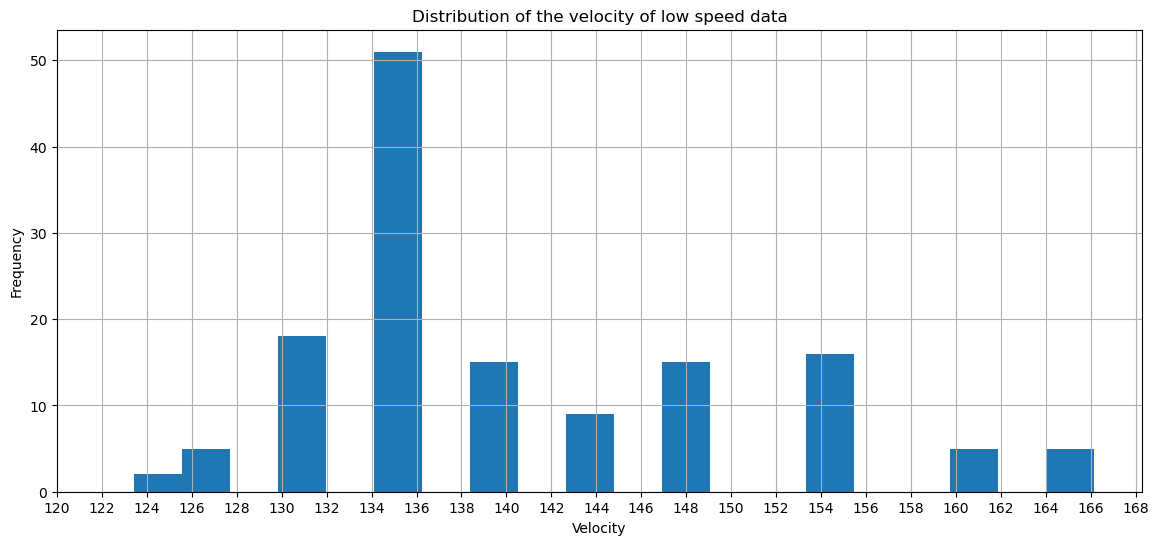

In [ ]:
#plot the distribution of the velocity
plt.figure(figsize=(14, 6))
plt.hist(high_speed, bins=20)
plt.title("Distribution of the velocity of low speed data")
plt.xlabel("Velocity")
plt.ylabel("Frequency")
# show more x values on the x-axis
plt.xticks(np.arange(120, 170, 2))
plt.grid(True)
plt.show()

In [ ]:
print(len(below_100_num))
print(len(above_100_below_135_num))
print(len(high_speed_num))


24
35
141


# Data preparation 

## Only high_speed_num trains

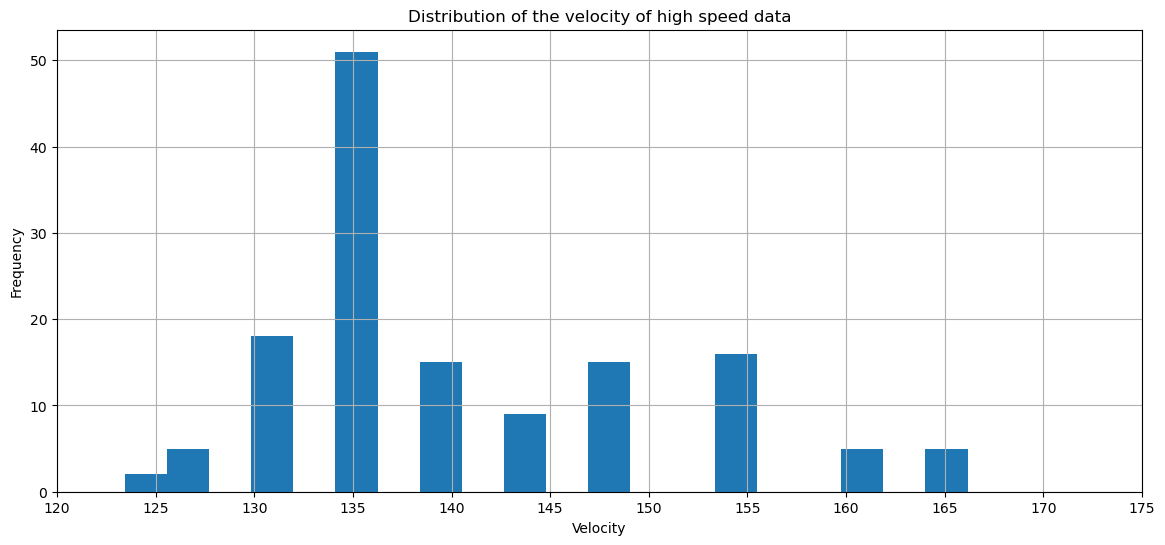

In [ ]:
# check the speed of trains in the high_speed data
high_speed_speed = []
for i in high_speed_num:
    high_speed_speed.append(data[fileList[i]]['velocity'][0])

#plot the distribution of the velocity
plt.figure(figsize=(14, 6))
plt.hist(high_speed_speed, bins=20)
plt.title("Distribution of the velocity of high speed data")
plt.xlabel("Velocity")
plt.ylabel("Frequency")
# show more x values on the x-axis
plt.xticks(np.arange(120, 180, 5))
plt.grid(True)
plt.show()



In [ ]:
feed_data_num = high_speed_num

split_ratio = 0.9  # 80% for training, 20% for test

# randomly take 80 % of number from low_speed_num and high_speed_num
#set the random seed
random.seed(123)
train_low_speed_train_num = random.sample(feed_data_num, int(len(feed_data_num)*split_ratio))
# merge the train number and shuffle it
train_num = train_low_speed_train_num
random.shuffle(train_num)

# the rest of the number in low_speed_num and high_speed_num are the test set
test_low_speed_train_num = [i for i in feed_data_num if i not in train_low_speed_train_num]
# merge the test number and shffle it
test_num = test_low_speed_train_num
random.shuffle(test_num)

# Create two dictionaries for training and testing sets based on the split
data_training = {train: data[fileList[train]] for train in train_num}
data_testing = {train: data[fileList[train]] for train in test_num}

## All trains

In [280]:
fold_index = 0

# K fold cross validation
# define the number of folds
k = 10
# define the number of samples
num_samples = len(fileList)
# define the number of samples in each fold
num_samples_in_each_fold = num_samples//k


start = fold_index * num_samples_in_each_fold
stop = start + num_samples_in_each_fold

test_num = list(range(start,stop))
train_num = [i for i in range(len(data.keys())) if i not in test_num]


# Create two dictionaries for training and testing sets based on the split

data_training = {train: data[fileList[train]] for train in train_num}

data_testing = {train: data[fileList[train]] for train in test_num}



In [281]:
data_training.keys(),data_testing.keys()

(dict_keys([20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199]),
 dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]))

# data_training_X is the first column of each dataframe in the data_training
data_training_X = {}
data_training_Y = {}
for key in data_training:
    data_training_X[key] = data_training[key][['acc_2','acc_2_component_0','acc_2_component_1','acc_2_component_2','acc_2_component_3','acc_2_component_4','acc_2_component_5','acc_2_component_6','acc_2_component_7']]
    data_training_Y[key] = data_training[key]['offset_stress_1']

# data_testing_X is the first column of each dataframe in the data_testing
data_testing_X = {}
data_testing_Y = {}
for key in data_testing:
    data_testing_X[key] = data_testing[key][['acc_2','acc_2_component_0','acc_2_component_1','acc_2_component_2','acc_2_component_3','acc_2_component_4','acc_2_component_5','acc_2_component_6','acc_2_component_7']]
    data_testing_Y[key] = data_testing[key]['offset_stress_1']

In [282]:
# import minmaxscaler to normalize the data
from sklearn.preprocessing import MinMaxScaler
feature_scaler = MinMaxScaler(feature_range=(0, 1))
#target_scaler = MinMaxScaler(feature_range=(0, 1))
# data_training_X is the first column of each dataframe in the data_training
data_training_X = {}
data_training_Y = {}
for key in data_training:
    #data_training_X[key] = data_training[key][['acc_2_component_0','acc_2_component_1','acc_2_component_2','acc_2_component_3','acc_2_component_4','acc_2_component_5','acc_2_component_6','acc_2_component_7']]
    #data_training_X[key] = data_training[key]['offset_stress_1']
    #data_training_X[key] = data_training[key][['acc_2']]
    data_training_X[key] = data_training[key][['acc_1','acc_2','acc_4']]
    ##
    ## apply low pass filter to the data_training_X
    #data_training_X[key]['acc_1'] = butter_lowpass(data_training_X[key]['acc_1'], 60, 150, order=5, btype='low')
    #data_training_X[key]['acc_2'] = butter_lowpass(data_training_X[key]['acc_2'], 60, 150, order=5, btype='low')
    #data_training_X[key]['acc_4'] = butter_lowpass(data_training_X[key]['acc_4'], 60, 150, order=5, btype='low')

    data_training_Y[key] = data_training[key]['Cycles'].dropna()
    #use MinMaxScaler to normalize the data_training_X
    #data_training_X[key] = feature_scaler.fit_transform(data_training_X[key].values.reshape(-1,1))
    #data_training_X[key] = feature_scaler.fit_transform(data_training_X[key])
    #data_training_Y[key] = target_scaler.fit_transform(data_training_Y[key].values.reshape(-1,1))


# data_testing_X is the first column of each dataframe in the data_testing
data_testing_X = {}
data_testing_Y = {}
for key in data_testing:
    data_testing_X[key] = data_testing[key][['acc_1','acc_2','acc_4']]

    # apply low pass filter to the data_testing_X
    #data_testing_X[key]['acc_1'] = butter_lowpass(data_testing_X[key]['acc_1'], 60, 150, order=5, btype='low')
    #data_testing_X[key]['acc_2'] = butter_lowpass(data_testing_X[key]['acc_2'], 60, 150, order=5, btype='low')
    #data_testing_X[key]['acc_4'] = butter_lowpass(data_testing_X[key]['acc_4'], 60, 150, order=5, btype='low')
    
    #data_testing_X[key] = data_testing[key][['acc_2']]
    #data_testing_X[key] = data_testing[key][['acc_2_component_0','acc_2_component_1','acc_2_component_2','acc_2_component_3','acc_2_component_4','acc_2_component_5','acc_2_component_6','acc_2_component_7']]
    #data_testing_Y[key] = data_testing[key]['offset_stress_1']
    #data_testing_X[key] = data_testing[key]['offset_stress_1']
    data_testing_Y[key] = data_testing[key]['Cycles'].dropna()
    #use MinMaxScaler to normalize the data_training_X
    #data_testing_X[key] = feature_scaler.transform(data_testing_X[key].values.reshape(-1,1))
    #data_testing_X[key] = feature_scaler.transform(data_testing_X[key])
    #data_testing_Y[key] = target_scaler.transform(data_testing_Y[key].values.reshape(-1,1))
    

In [283]:
#for all data in data_testing_X, apply butter_lowpass(data, 60, 150, order=5, btype='low')
for key in data_testing_X:
    data_testing_X[key]['acc_1'] = butter_lowpass(data_testing_X[key]['acc_1'], 60, 150, order=5, btype='low')
    data_testing_X[key]['acc_2'] = butter_lowpass(data_testing_X[key]['acc_2'], 60, 150, order=5, btype='low')
    data_testing_X[key]['acc_4'] = butter_lowpass(data_testing_X[key]['acc_4'], 60, 150, order=5, btype='low')

In [284]:
# save the speed of the train to a dictionary called speed for these in data_training_X and data_testing_X
speed_train = {}
speed_test = {}
for key in data_training_X.keys():
    speed_train[key] = data_training[key]['velocity'][0]
for key in data_testing_X.keys():
    speed_test[key] = data_testing[key]['velocity'][0]


# delete the frist row of the data_training_Y and data_testing_Y
drop_samll = True
if drop_samll:
    for key in data_training_Y:
        data_training_Y[key] = data_training_Y[key].iloc[1:]
    for key in data_testing_Y:
        data_testing_Y[key] = data_testing_Y[key].iloc[1:]

# put all arrays in the data_training_X in one tensor with shape of (number of data, 4500, 1) and igore the key of the dictionary
data_training_X = np.array([data_training_X[key] for key in data_training_X])
data_training_Y = np.array([data_training_Y[key] for key in data_training_Y])

# put all arrays in the data_testing_X in one tensor with shape of (number of data, 4500, 1) and igore the key of the dictionary
data_testing_X = np.array([data_testing_X[key] for key in data_testing_X])
data_testing_Y = np.array([data_testing_Y[key] for key in data_testing_Y])

speed_train = np.array([speed_train[key] for key in speed_train])
speed_test = np.array([speed_test[key] for key in speed_test])


# reshape the speed_train and speed_test to (1,180) from (180,)
speed_train = speed_train.reshape(-1,1)
speed_test = speed_test.reshape(-1,1)

# normalize the speed_train and speed_test
speed_scaler = MinMaxScaler(feature_range=(0, 2))
speed_train = speed_scaler.fit_transform(speed_train)
speed_test = speed_scaler.transform(speed_test)



In [302]:

# Training parameters
batch_size = 64
epochs = 350
BatchNorm = True 
normal = True 
#regularization_rate = 8e-4
regularization_rate = 8e-4
# Initial learning rate
initial_learning_rate = 0.0002
learning_rate_scheduler = False
num_heads = 10 #10  # Number of attention heads

kernels = [5, 5, 3]  # kernel sizes for each conv layer
strides = [2, 2, 1]  # stride values for each conv layer
pools = [2, 2, 2]    # pool sizes for each pooling layer after the conv layer

receptive_field = calculate_receptive_field(kernels, strides, pools)
print(f"The receptive field of the network is: {receptive_field}")



from tensorflow.keras.optimizers.schedules import ExponentialDecay


from tensorflow.keras.optimizers import Adam


# Define exponential decay function
lr_schedule = ExponentialDecay(
        initial_learning_rate,
        decay_steps=50,
        decay_rate=0.9,
        staircase=True
        )


if learning_rate_scheduler:
    # Configure the Adam optimizer with the learning rate schedule
    optimizer = Adam(
        learning_rate=lr_schedule,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-08
    )

else:
    # Configure the Adam optimizer with the initial learning rate
    optimizer = Adam(
        learning_rate=initial_learning_rate,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-08
    )

# create a early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    restore_best_weights=True
)


The receptive field of the network is: 79


In [286]:
150/2.5

60.0

### new model attention with speed

regularization_rate = 8e-4
initial_learning_rate = 0.0002 
128, 16,16,16, 

regularization_rate = 8e-3
initial_learning_rate = 0.0002 
16, 8,8,12, 

In [296]:
data_training_X.shape

(180, 4500, 3)

In [303]:
# Seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Assuming the scalar data is a single value or a small set of values
scalar_input = Input(shape=(1,))  # Adjust the shape based on your scalar data
# Map scalar input to a higher-dimensional space
scalar_dense = Dense(16, activation='relu',kernel_initializer=initializers.GlorotUniform(seed=42))(scalar_input)
# Define input shape
input_shape = data_training_X.shape[1:]  # Adjust as per your data

# Input layer
inputs = Input(shape=input_shape)
# First Convolutional Block 
x = BatchNormalization()(inputs)
x = Activation('relu')(x)
x = Conv1D(filters=8, kernel_size=5, strides=2, padding='same',
           kernel_initializer=initializers.GlorotUniform(seed=42),
           kernel_regularizer=regularizers.l2(regularization_rate))(x)
x = MaxPooling1D(pool_size=2)(x)
# Add residual connection
x1 = Conv1D(filters=8, kernel_size=1, strides=2, padding='same',kernel_initializer=initializers.GlorotUniform(seed=42))(inputs)  # Adjust filters and strides to match x
x1 = MaxPooling1D(pool_size=2)(x1)  # Add same pooling as x
x = Add()([x, x1])


# second Convolutional Block
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv1D(filters=8, kernel_size=5, strides=2, padding='same',
           kernel_initializer=initializers.GlorotUniform(seed=42),
           kernel_regularizer=regularizers.l2(regularization_rate))(x)
x = MaxPooling1D(pool_size=2)(x)
# Add residual connection
x2 = Conv1D(filters=8, kernel_size=1, strides=2, padding='same',kernel_initializer=initializers.GlorotUniform(seed=42))(x1)  # Adjust filters and strides to match x
x2 = MaxPooling1D(pool_size=2)(x2)  # Add same pooling as x
x = Add()([x, x2])


# third Convolutional Block32
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv1D(filters=12, kernel_size=3, strides=1, padding='same',
           kernel_initializer=initializers.GlorotUniform(seed=42),
           kernel_regularizer=regularizers.l2(regularization_rate))(x)
#x = MaxPooling1D(pool_size=2, strides=1, padding='valid')(x)
x = MaxPooling1D(pool_size=2)(x)
#x = LayerNormalization()(x)
# Add residual connection
x3 = Conv1D(filters=12, kernel_size=1, strides=1, padding='same',kernel_initializer=initializers.GlorotUniform(seed=42))(x2)  # Adjust filters and strides to match x
x3 = MaxPooling1D(pool_size=2)(x3)  # Add same pooling as x
x = Add()([x, x3])



# Multi-Head Attention
seq_length = x.shape[1]  # Depends on previous layers' output shape
feature_dim = x.shape[2]  # The number of filters in the last Conv layer

# Assuming 'x' is the input to the attention layer
attention_layer = MultiHeadAttention(num_heads=num_heads, key_dim=feature_dim, kernel_initializer=initializers.GlorotUniform(seed=42))
attention_output, attention_scores = attention_layer(x, x, x, return_attention_scores=True)

# Flattening the output to feed into a dense layer
flat = Flatten()(attention_output)
dense = Dropout(0.25)(flat)

# Concatenate scalar features and flattened sequence features
concat = concatenate([dense, scalar_dense])

# Final Dense Layers

dense = Dense(32, activation='relu', kernel_initializer=initializers.GlorotUniform(seed=42))(concat)
outputs = Dense(units=14, activation='relu', kernel_initializer=initializers.GlorotUniform(seed=42))(dense) 

# Create model with two inputs
CNN_model = Model(inputs=[inputs, scalar_input], outputs=outputs)

# Compile the model

CNN_model.compile(optimizer=optimizer, loss=custom_loss, metrics=['mean_squared_error'])

#model.compile(optimizer='Adam', loss='mean_squared_error', metrics=['mean_squared_error'])
#model.compile(optimizer='Adam', loss=weighted_mse_exponential, metrics=['mean_squared_error'])

#model.compile(optimizer='Adam', loss=weighted_mse_exponential_normal_distribution, metrics=['mean_squared_error'])

#model.compile(optimizer='Adam', loss=weighted_mse_log_normal_distribution, metrics=['mean_squared_error'])


# Display the model summary to check the architecture
CNN_model.summary()




Model: "model_43"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_69 (InputLayer)          [(None, 4500, 3)]    0           []                               
                                                                                                  
 batch_normalization_129 (Batch  (None, 4500, 3)     12          ['input_69[0][0]']               
 Normalization)                                                                                   
                                                                                                  
 activation_129 (Activation)    (None, 4500, 3)      0           ['batch_normalization_129[0][0]']
                                                                                                  
 conv1d_258 (Conv1D)            (None, 2250, 8)      128         ['activation_129[0][0]']  

In [304]:
# training
CNN_history = CNN_model.fit(x=[data_training_X, speed_train], y=data_training_Y, batch_size=batch_size, epochs=epochs,
          verbose=1, validation_split=0.1, shuffle=False
          ,callbacks=[early_stopping])

Epoch 1/350
3/3 [==============================] - 1s 133ms/step - loss: 10.9084 - mean_squared_error: 5.4474 - val_loss: 7.7184 - val_mean_squared_error: 3.8508
Epoch 2/350
3/3 [==============================] - 0s 44ms/step - loss: 10.2520 - mean_squared_error: 5.1209 - val_loss: 7.5248 - val_mean_squared_error: 3.7541
Epoch 3/350
3/3 [==============================] - 0s 42ms/step - loss: 9.4777 - mean_squared_error: 4.7376 - val_loss: 7.2891 - val_mean_squared_error: 3.6366
Epoch 4/350
3/3 [==============================] - 0s 42ms/step - loss: 8.6182 - mean_squared_error: 4.3148 - val_loss: 7.0162 - val_mean_squared_error: 3.5009
Epoch 5/350
3/3 [==============================] - 0s 41ms/step - loss: 7.6246 - mean_squared_error: 3.8317 - val_loss: 6.6693 - val_mean_squared_error: 3.3288
Epoch 6/350
3/3 [==============================] - 0s 41ms/step - loss: 6.4685 - mean_squared_error: 3.2745 - val_loss: 6.2460 - val_mean_squared_error: 3.1197
Epoch 7/350
3/3 [====================

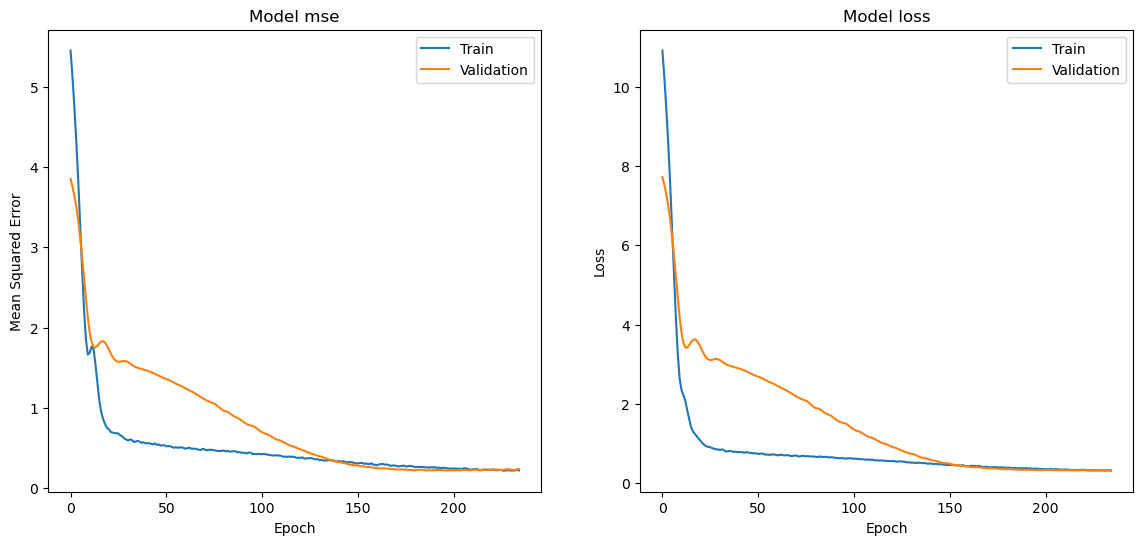

In [299]:
#plot the mse of the training and validation on the left(2,1) and the loss of the training and validation on the right(2,2)
figure = plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(CNN_history.history['mean_squared_error'][:])
plt.plot(CNN_history.history['val_mean_squared_error'][:])
plt.title('Model mse')
plt.ylabel('Mean Squared Error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(CNN_history.history['loss'][:])
plt.plot(CNN_history.history['val_loss'][:])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'],loc = 'upper right')

# save the figure to the file
#figure.savefig('model_loss5-1.png', dpi=500)
plt.show()


In [305]:
#set a timer to record the time of the prediction]
import time
start = time.time()
# predict the data_testing_X
CNN_y_pred = CNN_model.predict([data_testing_X,speed_test])

end = time.time()
print("Time taken to predict the data_testing_X is ", end - start)
# Rounding the predictions
CNN_rounded_predictions = round_to_nearest_half(CNN_y_pred)




Time taken to predict the data_testing_X is  0.21309423446655273


In [306]:
# calculate the mse of prediction

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# calculate the mse of the prediction
CNN_mse = mean_squared_error(data_testing_Y, CNN_y_pred)

# calculate the custom loss of the prediction
CNN_custom_loss_value = custom_loss(data_testing_Y, CNN_y_pred)

# calculate the mean value of custom loss
CNN_mean_custom_loss = np.mean(CNN_custom_loss_value)

print('The mse of the prediction is ', CNN_mse)
print('The mean value of the custom loss is ', CNN_mean_custom_loss)

The mse of the prediction is  0.28192446
The mean value of the custom loss is  0.48988754


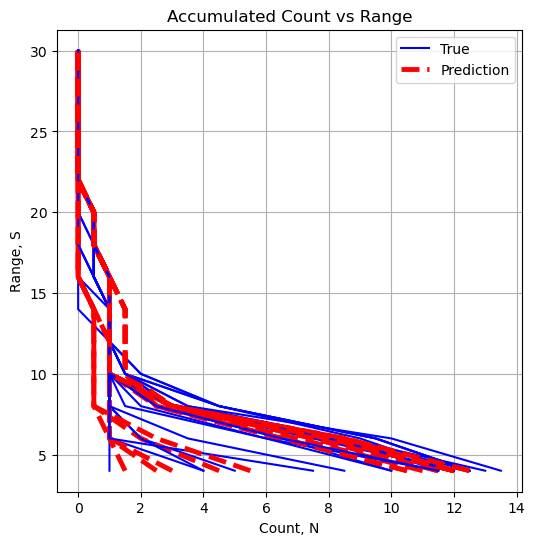

In [23]:
S = list(range(4,32,2))

# Plot all predictions on a same plot
figure = plt.figure(figsize=(6, 6))
for i in range(len(CNN_rounded_predictions)):
    pre_N = CNN_rounded_predictions[i]
    N = data_testing_Y[i]
    Ncum = N.sum() - np.cumsum(N)
    pre_Ncum = pre_N.sum() - np.cumsum(pre_N)
    one_sigma = np.sqrt(np.mean((pre_N - N)**2))

    #plt.semilogx(Ncum, S, color = 'blue')
    plt.plot(Ncum, S, color = 'blue',linewidth=1.5, label='True')
    #plt.semilogx(pre_Ncum, S, color = 'red', linestyle='--',linewidth=3.5)
    plt.plot(pre_Ncum, S, color = 'red', linestyle='--',linewidth=3.5, label='Prediction')
    #plt.title('train number = '+str(test_num[i]))
    # plot the one sigma error bar
    #plt.fill_betweenx(S, pre_Ncum - one_sigma, pre_Ncum + one_sigma, color='red', alpha=0.05)
    plt.xlabel('Count, N')
    plt.ylabel('Range, S')
    #plt.legend()
    plt.grid(True)
    if i == 0:
        plt.legend()
    plt.title('Accumulated Count vs Range')
# save the figure to the file
#figure.savefig('predts 5-1', dpi=500)
# add a test to the plot to show the color of the line

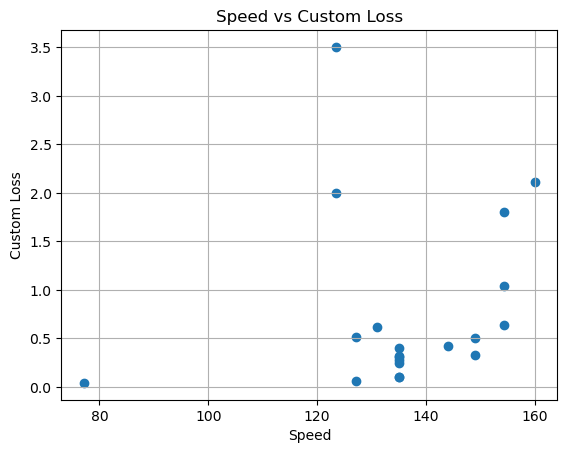

In [24]:
# denormalize the train speeds
#data_training_speed = speed_scaler.inverse_transform(data_training_speed)
denormailzed_data_testing_speed = speed_scaler.inverse_transform(speed_test)

plt.scatter(denormailzed_data_testing_speed,CNN_custom_loss_value)
plt.xlabel('Speed')
plt.ylabel('Custom Loss')
plt.title('Speed vs Custom Loss')
plt.grid(True)
# save the figure to the file
#plt.savefig('Speed vs Custom Loss 5-1', dpi=500)
plt.show()

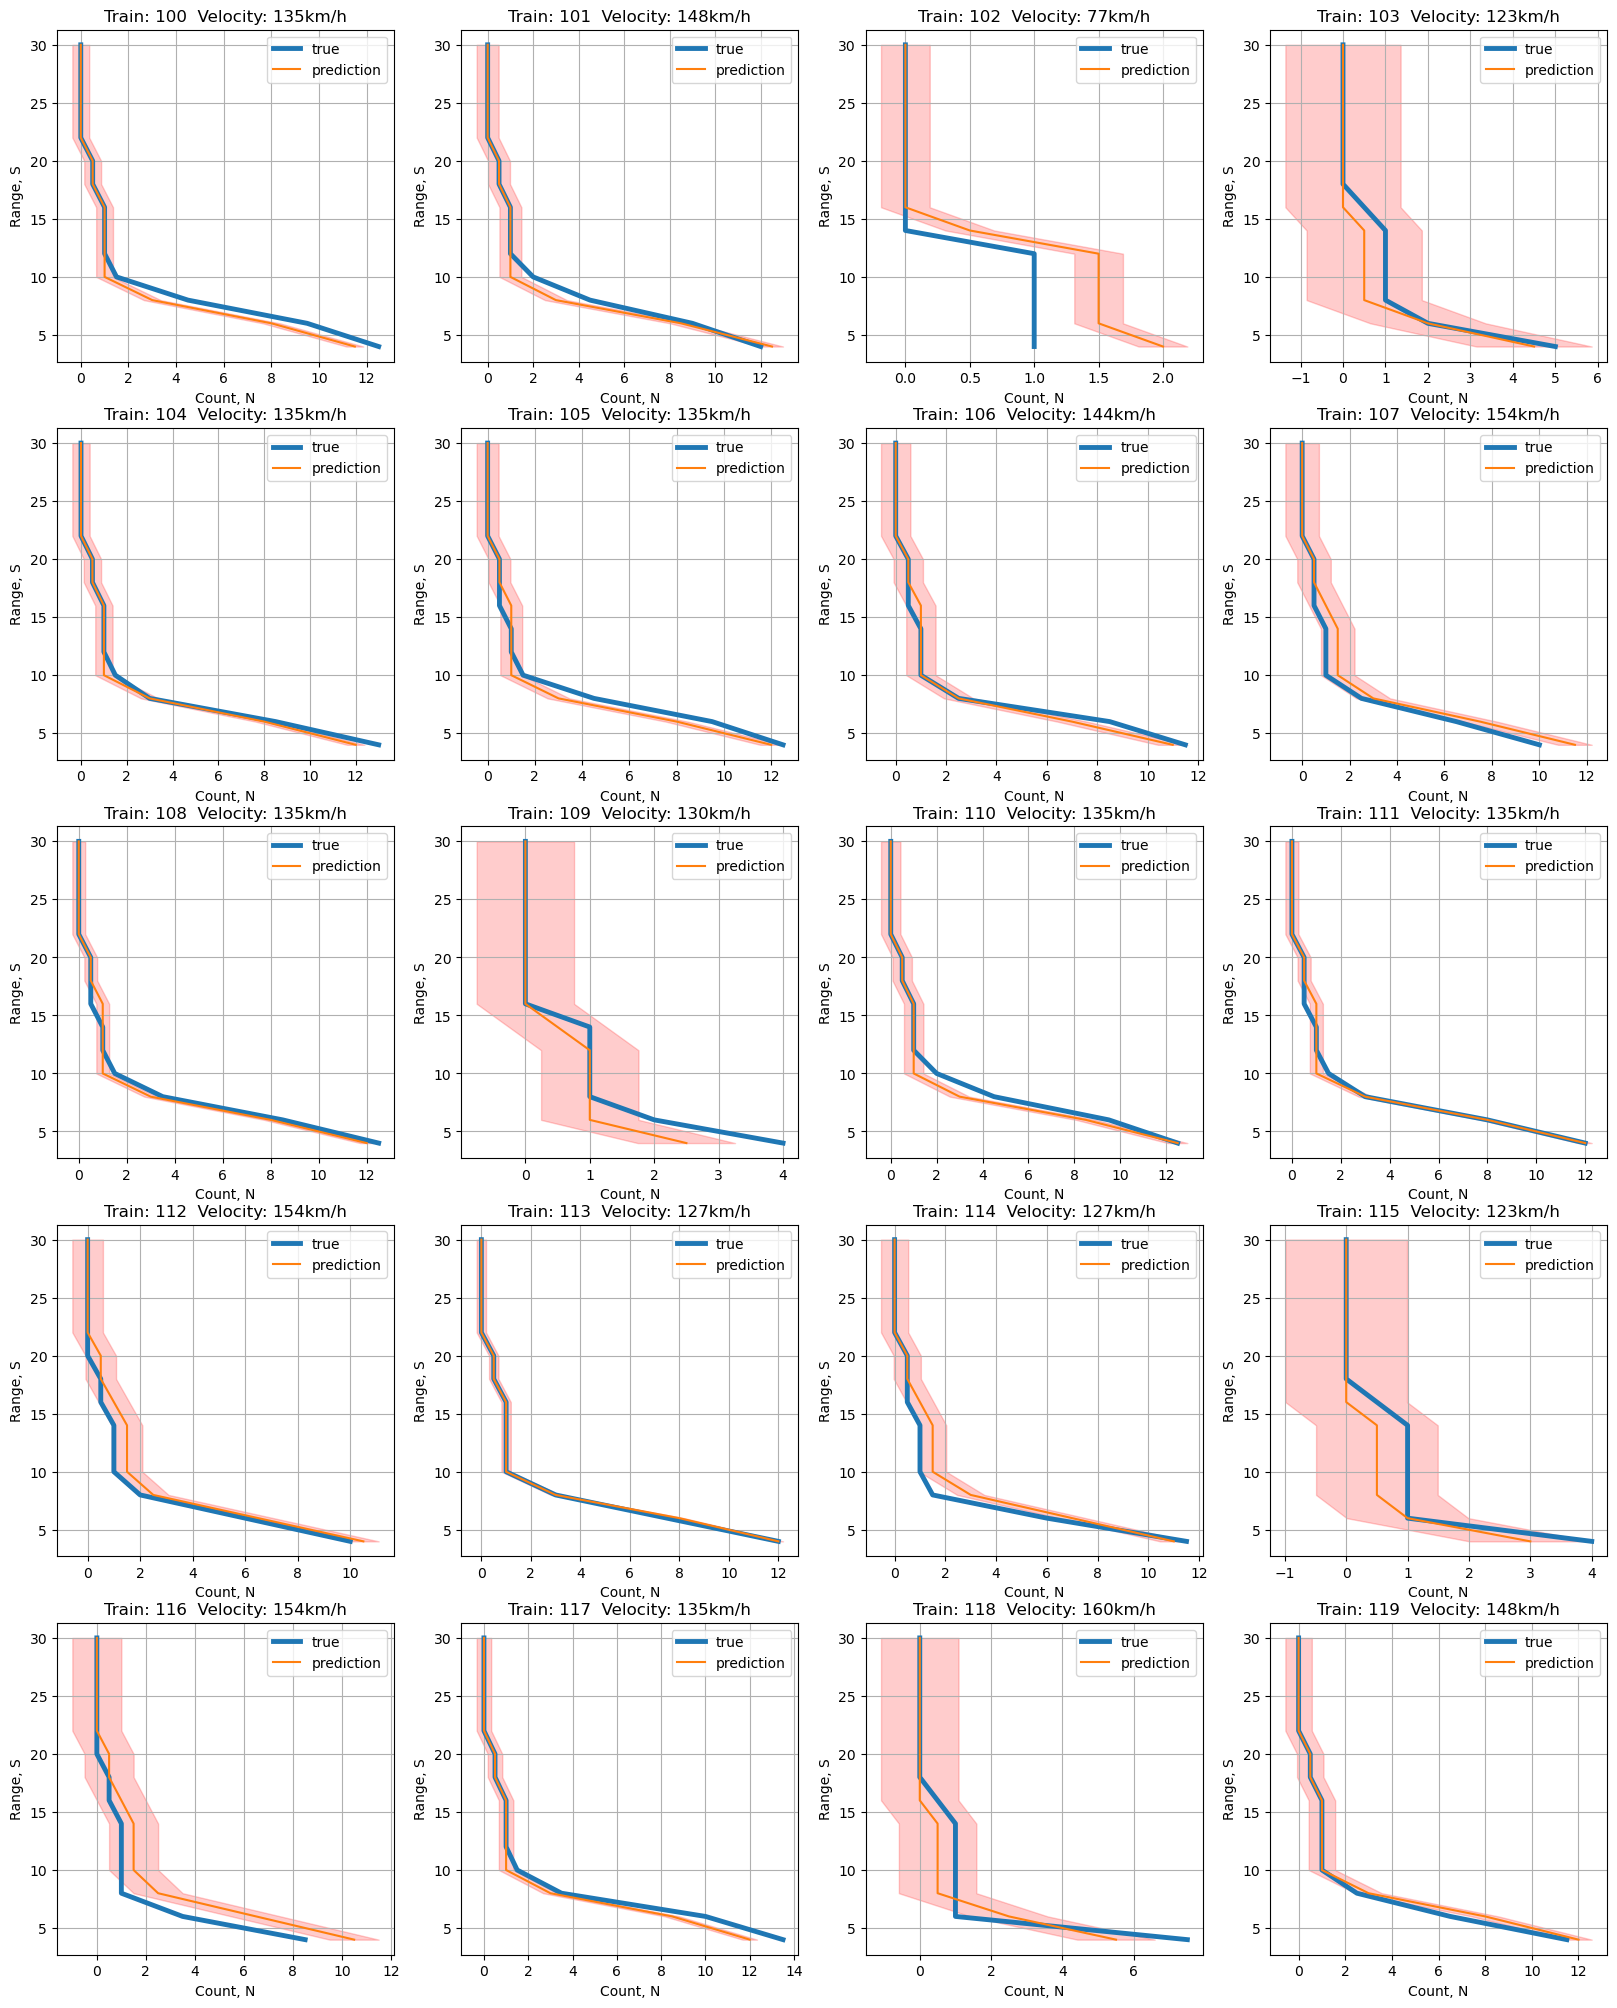

In [72]:
# plot all predictions on a plot with the same color
S = list(range(4,32,2))
figure, axes = plt.subplots(5, 4, figsize=(20, 25))

for i in range(len(CNN_rounded_predictions)):
    pre_N = CNN_rounded_predictions[i]
    N = data_testing_Y[i]
    Ncum = N.sum() - np.cumsum(N)
    pre_Ncum = pre_N.sum() - np.cumsum(pre_N)
    # calculate the one sigma of the prediction
    one_sigma = np.sqrt(np.mean((pre_N - N)**2))


    ax = axes[i//4, i%4]
    ax.plot(Ncum, S, label='true',linewidth=3.5)
    # plot the two sigma of the prediction
    ax.fill_betweenx(S, pre_Ncum-1*one_sigma, pre_Ncum+1*one_sigma, color='r', alpha=0.2)
    #ax.fill_betweenx(S, pre_Ncum-2*one_sigma, pre_Ncum+1*one_sigma-2*one_sigma, color='y', alpha=0.3)
    #ax.fill_betweenx(S, pre_Ncum+1*one_sigma, pre_Ncum+2*one_sigma, color='y', alpha=0.3)

    #ax.fill_betweenx(S, pre_Ncum-2*one_sigma-3*one_sigma, pre_Ncum+2*one_sigma+3*one_sigma, color='b', alpha=0.1)
    ax.plot(pre_Ncum, S, label='prediction')
    # in the tile of each plot, show the train number and the velocity of the train
    ax.set_title('Train: '+str(test_num[i])+'  Velocity: '+str(int(denormailzed_data_testing_speed[i][0])) +'km/h',fontsize=12)

    ax.set_xlabel('Count, N')
    ax.set_ylabel('Range, S')
    ax.legend()
    ax.grid(True)

#figure.savefig('predictions3-6.png', dpi=1000)
plt.show()


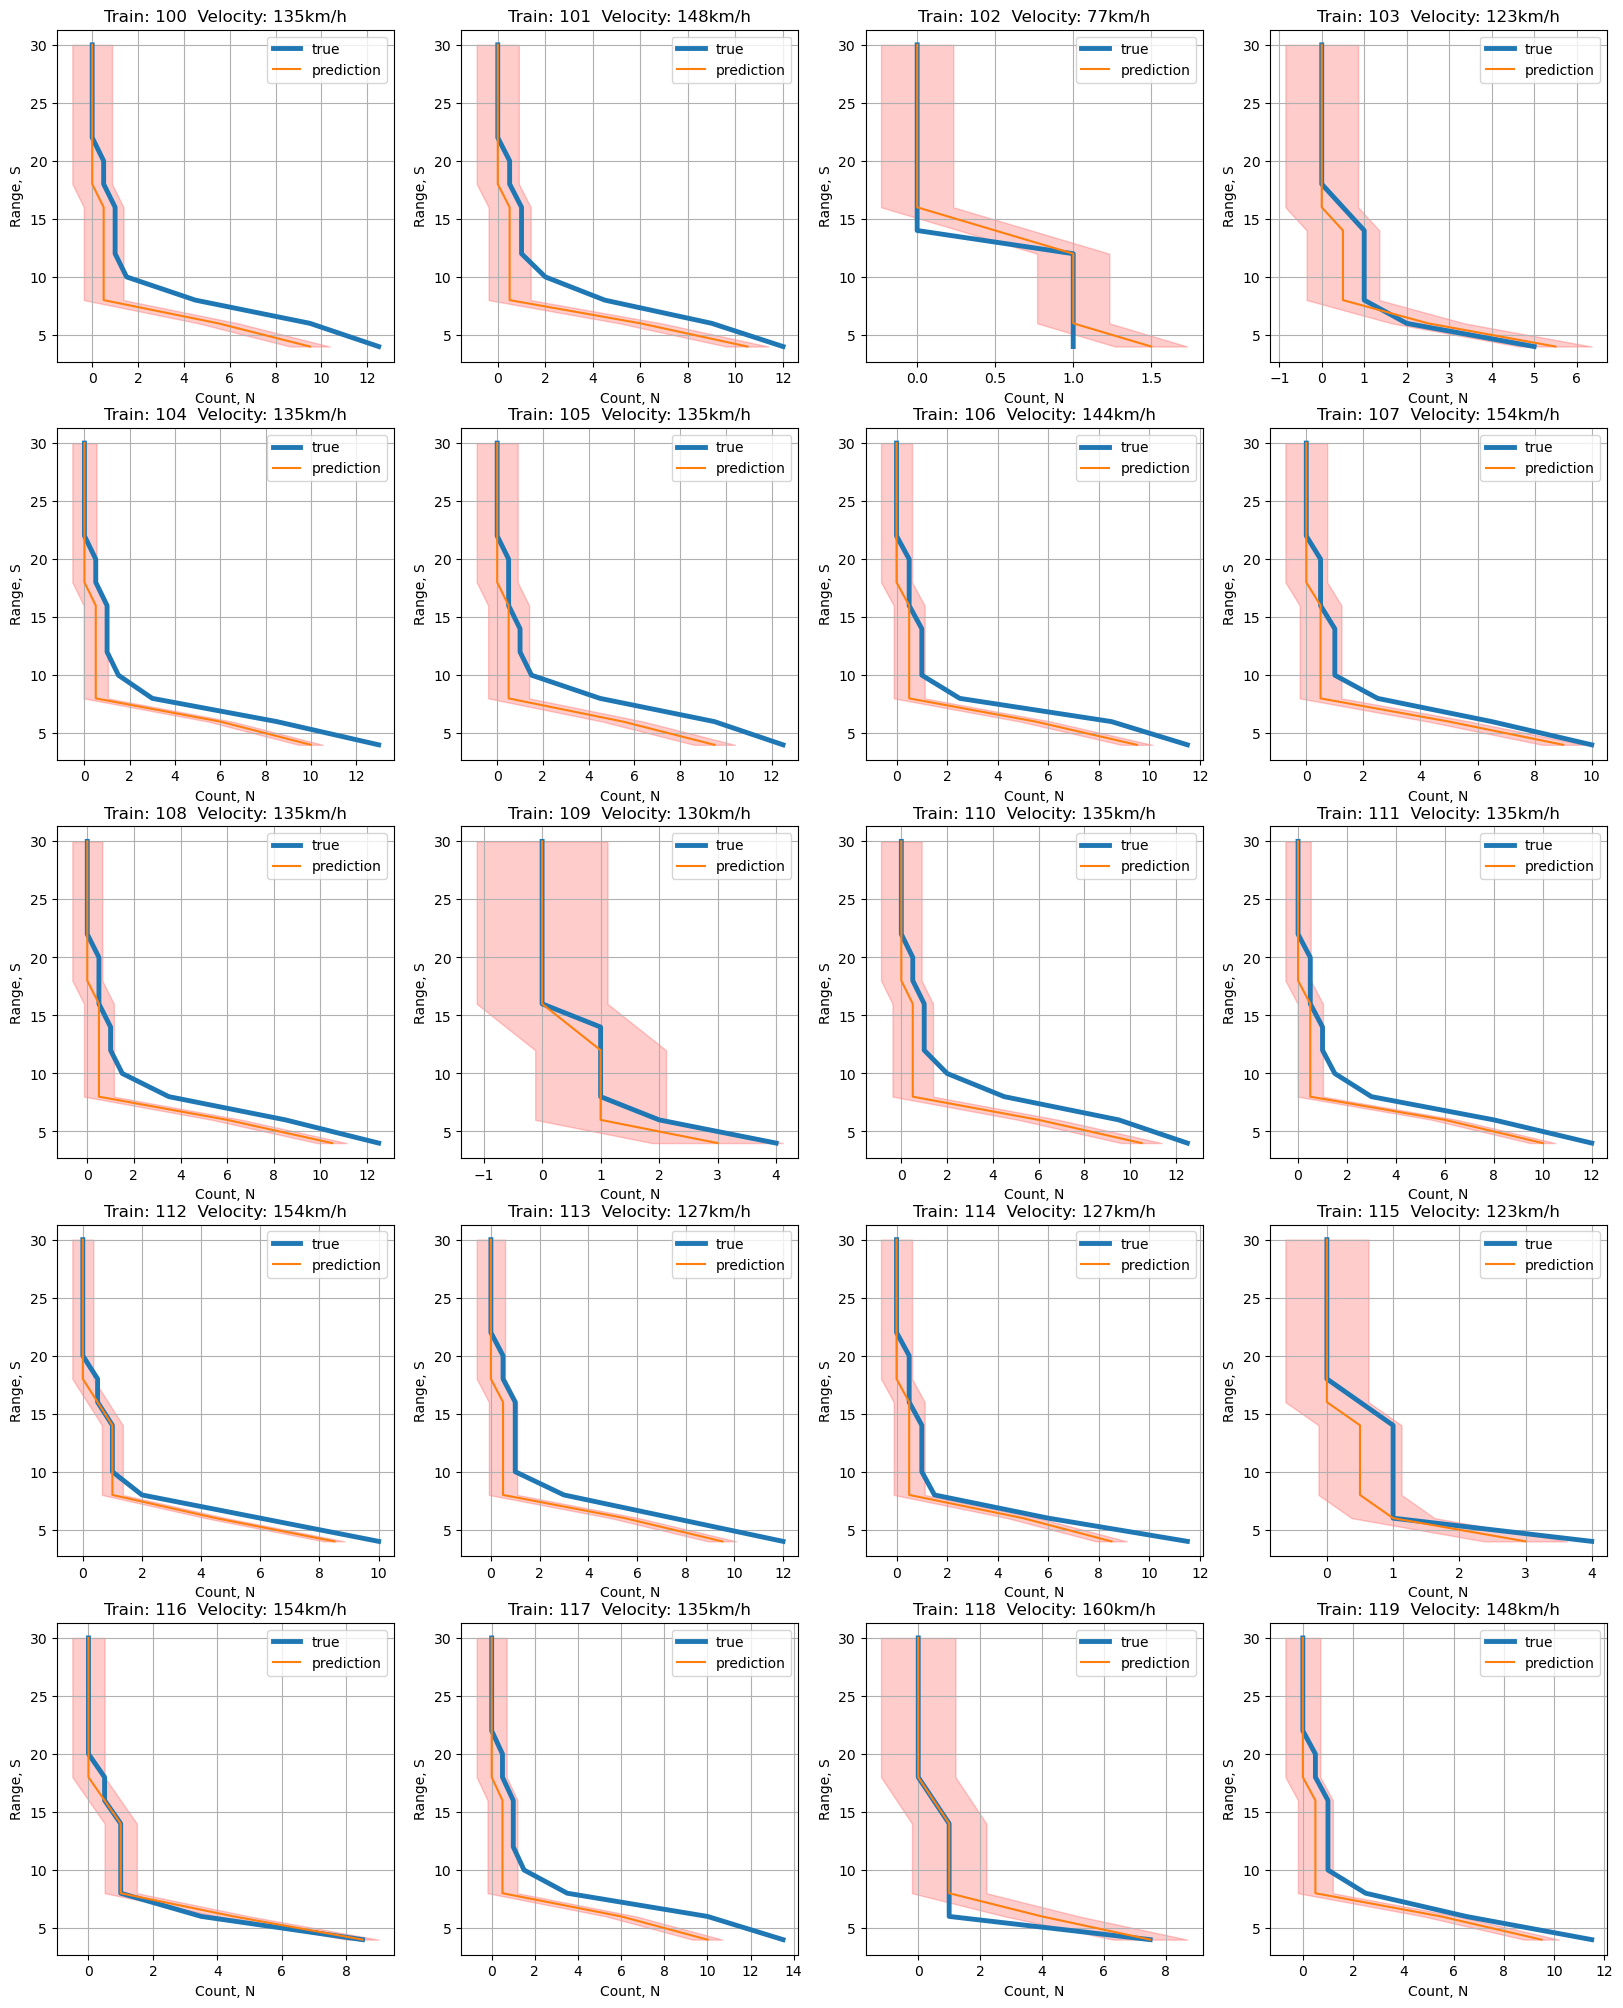

In [140]:
# plot all predictions on a plot with the same color
S = list(range(4,32,2))
figure, axes = plt.subplots(5, 4, figsize=(20, 25))

for i in range(len(CNN_rounded_predictions)):
    pre_N = CNN_rounded_predictions[i]
    N = data_testing_Y[i]
    Ncum = N.sum() - np.cumsum(N)
    pre_Ncum = pre_N.sum() - np.cumsum(pre_N)
  
    # calculate the one sigma of the prediction
    one_sigma = np.sqrt(np.mean((pre_N - N)**2))


    ax = axes[i//4, i%4]
    ax.plot(Ncum, S, label='true',linewidth=3.5)
    # plot the two sigma of the prediction
    ax.fill_betweenx(S, pre_Ncum - 1 * one_sigma, pre_Ncum + 1 * one_sigma, color='r', alpha=0.2)
 
    ax.plot(pre_Ncum, S, label='prediction')
    # in the tile of each plot, show the train number and the velocity of the train
    ax.set_title('Train: '+str(test_num[i])+'  Velocity: '+str(int(denormailzed_data_testing_speed[i][0])) +'km/h',fontsize=12)

    ax.set_xlabel('Count, N')
    ax.set_ylabel('Range, S')
    ax.legend()
    ax.grid(True)

#figure.savefig('predictions3-6.png', dpi=1000)
plt.show()


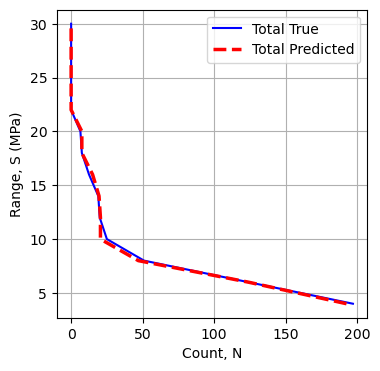

In [25]:
# First, compute the sum of ALL actual N’s and ALL predicted N’s across your samples
N_total = np.sum(data_testing_Y, axis=0)           # shape: (m,)
pre_N_total = np.sum(CNN_rounded_predictions, axis=0)  # shape: (m,)

# Then compute the accumulated (cumulative) counts
N_total_cum    = N_total.sum()    - np.cumsum(N_total)
pre_N_total_cum = pre_N_total.sum() - np.cumsum(pre_N_total)

# Plot the total curves
plt.figure(figsize=(4,4))
plt.plot(N_total_cum, S, color='blue', label='Total True',linewidth=1.5)
plt.plot(pre_N_total_cum, S, color = 'red', linestyle='--',linewidth=2.5, label='Total Predicted')

plt.xlabel('Count, N')
plt.ylabel('Range, S (MPa)')
#plt.title('Accumulated Count vs Range (All Samples Combined)')
plt.grid(True)
plt.legend()
plt.show()


In [166]:
# read N_total_cum.csv
df = pd.read_csv('N_total_cum.csv')
attention_only_N_total_cum = df['0']
attention_only_pre_N_total_cum = df['pre_N_total_cum']

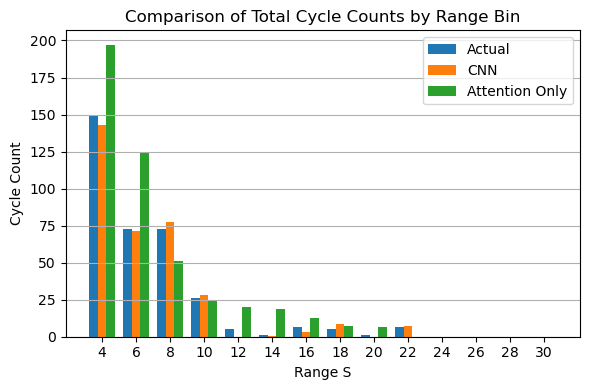

In [178]:


# Suppose:
#   data_testing_Y has shape (num_samples, num_bins)
#   rounded_predictions has shape (num_samples, num_bins)
#   S is the list of range bins (length num_bins)

# 1. Sum up all actual and all predicted counts over all samples, per bin
N_total = np.sum(data_testing_Y, axis=0)           # shape: (num_bins,)
pre_N_total = np.sum(CNN_rounded_predictions, axis=0)  # shape: (num_bins,)

# 2. Create indices for plotting
indices = np.arange(len(S))  # e.g., [0, 1, 2, ..., num_bins-1]



# 3. Plot three bar groups, side-by-side
bar_width = 0.25  # Controls the width of each bar
plt.figure(figsize=(6, 4))

plt.bar(indices - bar_width, N_total,             width=bar_width, label='Actual')
plt.bar(indices,             pre_N_total,         width=bar_width, label='CNN')
plt.bar(indices + bar_width, attention_only_N_total_cum,   width=bar_width, label='Attention Only')

# 4. Configure labels/ticks/etc.
plt.xlabel('Range S')
plt.ylabel('Cycle Count')
plt.title('Comparison of Total Cycle Counts by Range Bin')
plt.xticks(indices, S)   # Show the range-bin labels along the x-axis
plt.grid(True, axis='y')
plt.legend()
plt.tight_layout()  
plt.show()


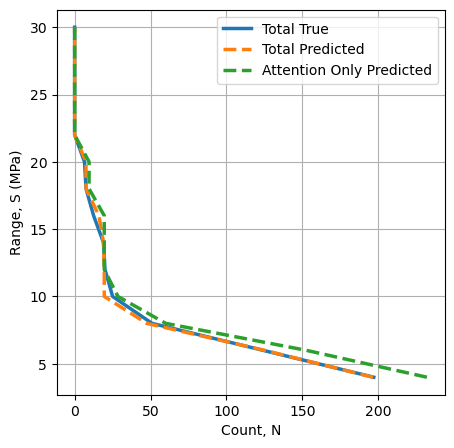

In [177]:
# First, compute the sum of ALL actual N’s and ALL predicted N’s across your samples
N_total = np.sum(data_testing_Y, axis=0)           # shape: (m,)
pre_N_total = np.sum(CNN_rounded_predictions, axis=0)  # shape: (m,)

# Then compute the accumulated (cumulative) counts
N_total_cum    = N_total.sum()    - np.cumsum(N_total)
pre_N_total_cum = pre_N_total.sum() - np.cumsum(pre_N_total)

# Plot the total curves
plt.figure(figsize=(5,5))
plt.plot(N_total_cum, S, label='Total True',linewidth=2.5)
plt.plot(pre_N_total_cum, S,  linestyle='--',linewidth=2.5, label='Total Predicted')
plt.plot(attention_only_pre_N_total_cum, S
         , linestyle='--',linewidth=2.5, label='Attention Only Predicted')

plt.xlabel('Count, N')
plt.ylabel('Range, S (MPa)')
#plt.title('Accumulated Count vs Range (All Samples Combined)')
plt.grid(True)
plt.legend()
plt.show()

### visiulized the intermdiua output

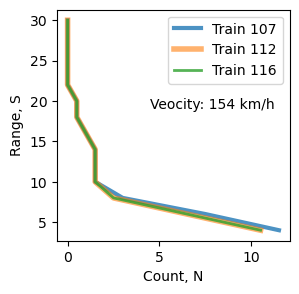

In [81]:
plt.figure(figsize=(3, 3))
for i in [7,12,16]:
    N = CNN_rounded_predictions[i]
    Ncum = N.sum() - np.cumsum(N)
    if i == 7:
        plt.plot(Ncum, S, label="Train 107",linewidth=3.0, alpha=0.8)
    elif i == 12:
        plt.plot(Ncum, S, label="Train 112",linewidth=4.0, alpha=0.6)
    else:
        plt.plot(Ncum, S, label="Train "+"1"+str(i),linewidth=2.0, alpha=0.8)
plt.text(4.5, 19, 'Veocity: 154 km/h', fontsize=10)
plt.xlabel('Count, N')
plt.ylabel('Range, S')
plt.legend()
#save the figure into the svg format
plt.savefig('Figure21c.svg', dpi=1000)
plt.show()

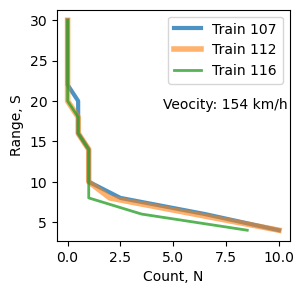

In [80]:
plt.figure(figsize=(3, 3))
for i in [7,12,16]:
    N = data_testing_Y[i]
    Ncum = N.sum() - np.cumsum(N)
    if i == 7:
        plt.plot(Ncum, S, label="Train 107",linewidth=3.0, alpha=0.8)
    elif i == 12:
        plt.plot(Ncum, S, label="Train 112",linewidth=4.0, alpha=0.6)
    else:
        plt.plot(Ncum, S, label="Train "+"1"+str(i),linewidth=2.0, alpha=0.8)
plt.text(4.5, 19, 'Veocity: 154 km/h', fontsize=10)
plt.xlabel('Count, N')
plt.ylabel('Range, S')
plt.legend()

plt.savefig('Figure21b.svg', dpi=1000)

plt.show()


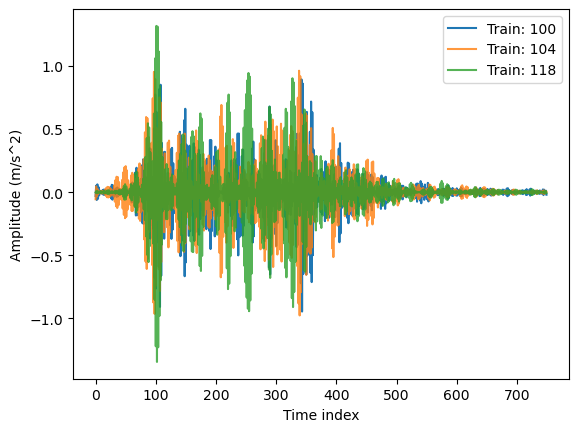

In [61]:
#plt.plot(butter_lowpass(data_testing[107]['acc_1'], 30, 150, order=5, btype='low'))
plt.plot(butter_lowpass(data_testing[100]['acc_1'], 60, 150, order=5, btype='high')[450:1200],label='Train: 100')
plt.plot(butter_lowpass(data_testing[104]['acc_1'], 60, 150, order=5, btype='high')[450:1200],label='Train: 104',alpha=0.8)
plt.plot(butter_lowpass(data_testing[118]['acc_1'], 60, 150, order=5, btype='high')[450:1200],label='Train: 118',alpha=0.8)
#plt.plot(butter_lowpass(data_testing[108]['acc_1'], 60, 150, order=5, btype='high')[450:1200],label='Train: 108',alpha=0.8)

plt.legend()

# show x-ticks  by dividing by 150 and only show x-ticks from 0 to 15
#plt.xticks(np.arange(0, 150, 15))



# x-axis label time seconds
plt.xlabel('Time index')

# y-axis label amplitude
plt.ylabel('Amplitude (m/s^2)')
plt.show()

In [82]:
train_to_visualize = 107
test_num_visualize = 7

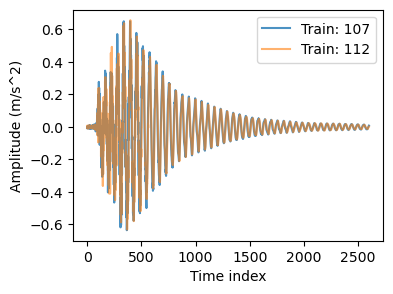

In [66]:
#plt.plot( data_testing[train_to_visualize]['acc_1'] - butter_lowpass(data_testing[train_to_visualize]['acc_1'], 30, 150, order=5, btype='low')+ 
#         data_testing[train_to_visualize]['acc_1']-butter_lowpass(data_testing[train_to_visualize]['acc_1'], 35, 150, order=5, btype='high'))
plt.figure(figsize=(4, 3))
#plt.plot(butter_lowpass(data_testing[107]['acc_1'], 30, 150, order=5, btype='low'))
#plt.plot(butter_lowpass(data_testing[train_to_visualize]['acc_1'], 60, 150, order=5, btype='low')[400:3000],label='Train: 116',alpha=0.6)
plt.plot(butter_lowpass(data_testing[107]['acc_1'], 60, 150, order=5, btype='low')[400:3000],label='Train: 107',alpha=0.8)
plt.plot(butter_lowpass(data_testing[112]['acc_1'], 60, 150, order=5, btype='low')[400:3000],label='Train: 112',alpha=0.6)
#plt.plot(data_testing[train_to_visualize]['acc_1'], alpha=0.4)
plt.legend()

# show x-ticks  by dividing by 150 and only show x-ticks from 0 to 15
#plt.xticks(np.arange(0, 150, 15))



# x-axis label time seconds
plt.xlabel('Time index')

# y-axis label amplitude
plt.ylabel('Amplitude (m/s^2)')
plt.show()

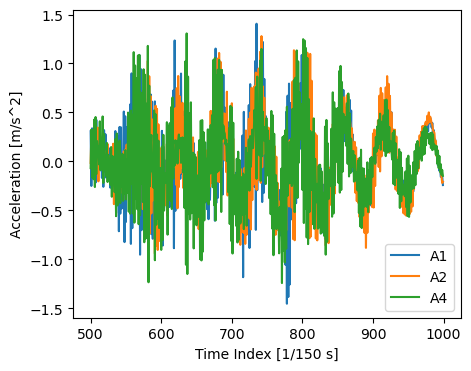

In [67]:

plt.figure(figsize=(5, 4))
plt.plot(data_testing[train_to_visualize]['acc_1'][500:1000],label='A1')
plt.plot(data_testing[train_to_visualize]['acc_2'][500:1000],label='A2')
plt.plot(data_testing[train_to_visualize]['acc_4'][500:1000],label='A4')

# x-axis label
plt.xlabel('Time Index [1/150 s]')
# y-axis label
plt.ylabel('Acceleration [m/s^2]')

#plt.grid(True)
plt.legend()

plt.show()

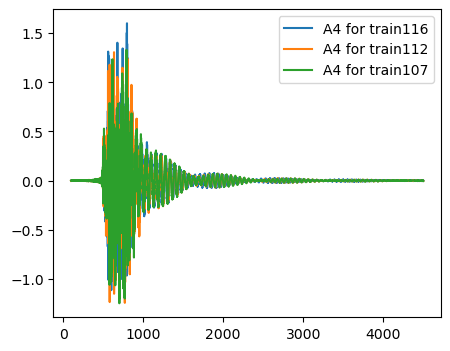

In [74]:

plt.figure(figsize=(5, 4))
plt.plot(data_testing[116]['acc_4'][100:],label='A4 for train'+str(116))
plt.plot(data_testing[112]['acc_4'][100:],label='A4 for train'+str(112))
plt.plot(data_testing[107]['acc_4'][100:],label='A4 for train'+str(107))

plt.legend()

plt.show()

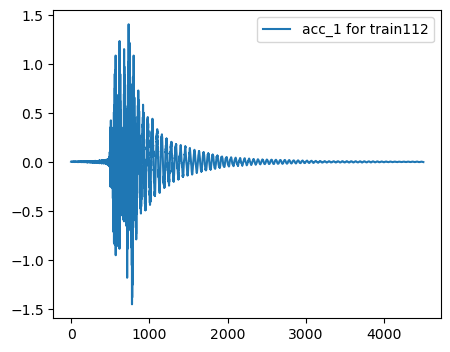

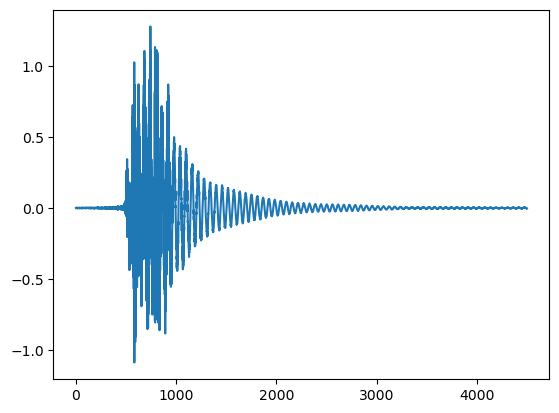

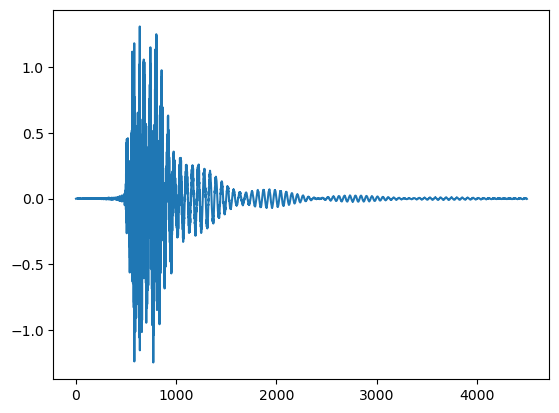

In [45]:

plt.figure(figsize=(5, 4))
plt.plot(data_testing[train_to_visualize]['acc_1'][0:],label='acc_1 for train'+str(train_to_visualize))
#plt.plot(data_testing[116]['acc_1'][0:],label='acc_1 for train 116')
plt.legend()
plt.show()
plt.plot(data_testing[train_to_visualize]['acc_2'][0:],label='acc_2')
plt.show()
plt.plot(data_testing[train_to_visualize]['acc_4'][0:],label='acc_4')
plt.show()

In [444]:
data_testing[train_to_visualize]

strain_1  strain_2     acc_2     acc_1     acc_3     acc_4  \
0     0.514099 -0.374878 -0.000694 -0.000029 -0.000452 -0.000808   
1     1.386230  0.496521  0.000428 -0.000222  0.000106 -0.000166   
2     0.229065 -0.754089 -0.001346 -0.000580 -0.000767 -0.000146   
3     0.350281 -0.545563 -0.000765 -0.000663  0.000472 -0.000532   
4     1.710571  0.259888  0.000567 -0.000544 -0.000691  0.001194   
...        ...       ...       ...       ...       ...       ...   
4495  0.782654  0.663513 -0.003460 -0.002273 -0.001131 -0.001305   
4496 -0.278809 -0.510742 -0.003653 -0.002968 -0.001705 -0.002051   
4497 -0.075073 -0.287903 -0.002515 -0.003260 -0.002404 -0.001343   
4498  0.507935  0.496246 -0.003401 -0.003016 -0.002716 -0.002805   
4499  0.908081  0.503265 -0.003490 -0.003317 -0.002830 -0.003576   

      offset_stress_1  Range  Cycles    velocity  
0            0.109845    2.0  1314.5  154.285721  
1            0.292993    4.0    10.0  154.285721  
2            0.049988    6.0     3.5  154.285721  
3            0.075443    8.0     4.0  154.285721  
4            0.361104   10.0     1.5  154.285721  
...               ...    ...     ...         ...  
4495         0.166241    NaN     NaN  154.285721  
4496        -0.056666    NaN     NaN  154.285721  
4497        -0.013881    NaN     NaN  154.285721  
4498         0.108550    NaN     NaN  154.285721  
4499         0.192581    NaN     NaN  154.285721  

[4500 rows x 10 columns]

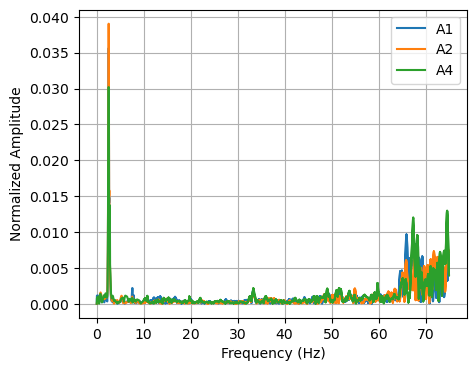

In [46]:
            

# Compute the FFT
fft_vals_a1 = np.fft.fft(data_testing[train_to_visualize].iloc[:,3])
fft_vals_a1 = np.abs(fft_vals_a1)/len(data_testing[train_to_visualize].iloc[:,3])   # normalized values
#fft_vals_a1 = np.abs(fft_vals_a1)
fft_vals_a1[:1] = 0             # eliminate the influence of first component\
# Compute the frequencies associated with the FFT values
# The frequency is set as 150Hz
fft_freq_a1 = np.fft.fftfreq(len(data_testing[train_to_visualize].iloc[:,3]),1/150)

# Compute the FFT
fft_vals_a2 = np.fft.fft(data_testing[train_to_visualize].iloc[:,2])
fft_vals_a2 = np.abs(fft_vals_a2)/len(data_testing[train_to_visualize].iloc[:,2])   # normalized values
#fft_vals_a2 = np.abs(fft_vals_a1)
fft_vals_a2[:1] = 0             # eliminate the influence of first component\
# Compute the frequencies associated with the FFT values
# The frequency is set as 150Hz
fft_freq_a2 = np.fft.fftfreq(len(data_testing[train_to_visualize].iloc[:,2]),1/150)

# Compute the FFT
fft_vals_a4 = np.fft.fft(data_testing[train_to_visualize].iloc[:,5])
fft_vals_a4 = np.abs(fft_vals_a4)/len(data_testing[train_to_visualize].iloc[:,5])   # normalized values
#fft_vals_a4 = np.abs(fft_vals_a4)
fft_vals_a4[:1] = 0             # eliminate the influence of first component\
# Compute the frequencies associated with the FFT values
# The frequency is set as 150Hz
fft_freq_a4 = np.fft.fftfreq(len(data_testing[train_to_visualize].iloc[:,5]),1/150)


    # Plot the FFT values vs frequencies
plt.figure(figsize=(5, 4))


plt.plot(np.abs(fft_freq_a1)[:4200], fft_vals_a1[:4200], label='A1',linewidth=1.5,alpha=1)
plt.plot(np.abs(fft_freq_a2)[:4200], fft_vals_a2[:4200], label='A2',linewidth=1.5,alpha=1)
plt.plot(np.abs(fft_freq_a4)[:4200], fft_vals_a4[:4200], label='A4',linewidth=1.5,alpha=1)
plt.legend()
#plt.title(f'FFT of {title}')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Normalized Amplitude')
plt.grid(True)
plt.show()

In [47]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches


def plot_fft_with_zoom(
    fft_freq_list,
    fft_vals_list,
    labels,
    zoom_range=(30, 35),
    figsize=(8, 5),
    inset_position=[0.3, 0.3, 0.4, 0.4],
    colors=None
):
    """
    Plot FFT of multiple signals with an inset zoom into a specific frequency range.

    Parameters:
    ----------
    fft_freq_list : list of np.arrays
        List of frequency arrays for each signal.
    fft_vals_list : list of np.arrays
        List of FFT magnitude arrays for each signal.
    labels : list of str
        Labels for each signal (for the legend).
    zoom_range : tuple
        Frequency range to zoom in (start_freq, end_freq).
    figsize : tuple
        Size of the figure.
    inset_position : list
        [left, bottom, width, height] position of the inset (in figure fraction).
    colors : list
        List of colors for each signal (optional).
    """
    
    fig, ax = plt.subplots(figsize=figsize)
    
    # ----------- Main FFT Plot -----------
    for i in range(len(fft_freq_list)):
        color = colors[i] if colors else None
        ax.plot(fft_freq_list[i], fft_vals_list[i], label=labels[i], linewidth=1.5, alpha=1, color=color)
    
    ax.set_xlabel('Frequency (Hz)', fontsize=12)
    ax.set_ylabel('Normalized Amplitude', fontsize=12)
    ax.legend(fontsize=12, loc='upper right')
    ax.grid(True)
    
    # ----------- Manual Rectangle for Zoomed Region -----------
    zoom_x_start, zoom_x_end = zoom_range
    zoom_y_max = max([
        np.max(vals[(freqs >= zoom_x_start) & (freqs <= zoom_x_end)])
        for freqs, vals in zip(fft_freq_list, fft_vals_list)
    ]) * 1.2  # Padding for visibility

    # Add rectangle on main plot
    rect = patches.Rectangle(
        (zoom_x_start, 0),  # (x, y)
        zoom_x_end - zoom_x_start,  # width
        zoom_y_max,  # height
        linewidth=2,
        edgecolor='red',
        facecolor='none',
        linestyle='--'
    )
    ax.add_patch(rect)

    # ----------- Inset Plot -----------
    ax_inset = fig.add_axes(inset_position)  # [left, bottom, width, height]
    for i in range(len(fft_freq_list)):
        color = colors[i] if colors else None
        ax_inset.plot(fft_freq_list[i], fft_vals_list[i], linewidth=1.2, alpha=1, color=color)
    
    ax_inset.set_xlim(zoom_x_start, zoom_x_end)
    ax_inset.set_ylim(0, zoom_y_max)
    #show the y_ticks with e-3 format
    ax_inset.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    ax_inset.tick_params(axis='both', which='both', length=0, labelsize=9)
    ax_inset.grid(True)
    
    plt.show()


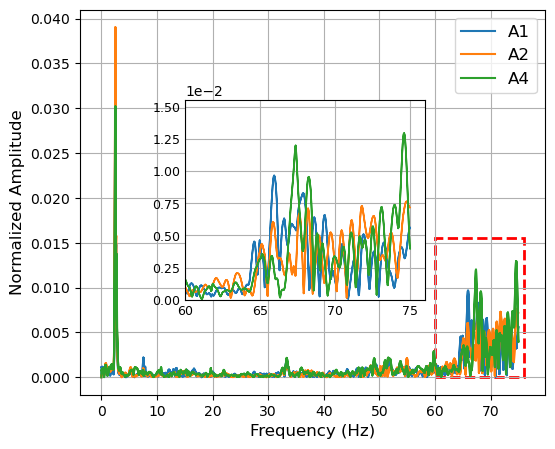

In [48]:
# Prepare lists of frequency and FFT values
fft_freq_list = [
    np.abs(fft_freq_a1)[:],
    np.abs(fft_freq_a2)[:],
    np.abs(fft_freq_a4)[:]
]

fft_vals_list = [
    fft_vals_a1[:],
    fft_vals_a2[:],
    fft_vals_a4[:]
]

# Labels for each signal
labels = ['A1', 'A2', 'A4']

# Call the function
plot_fft_with_zoom(
    fft_freq_list,
    fft_vals_list,
    labels,
    zoom_range=(60, 76),  # You can adjust this range
    figsize=(6, 5)  # Adjust size if needed
)


Text(0, 0.5, 'Stress [MPa]')

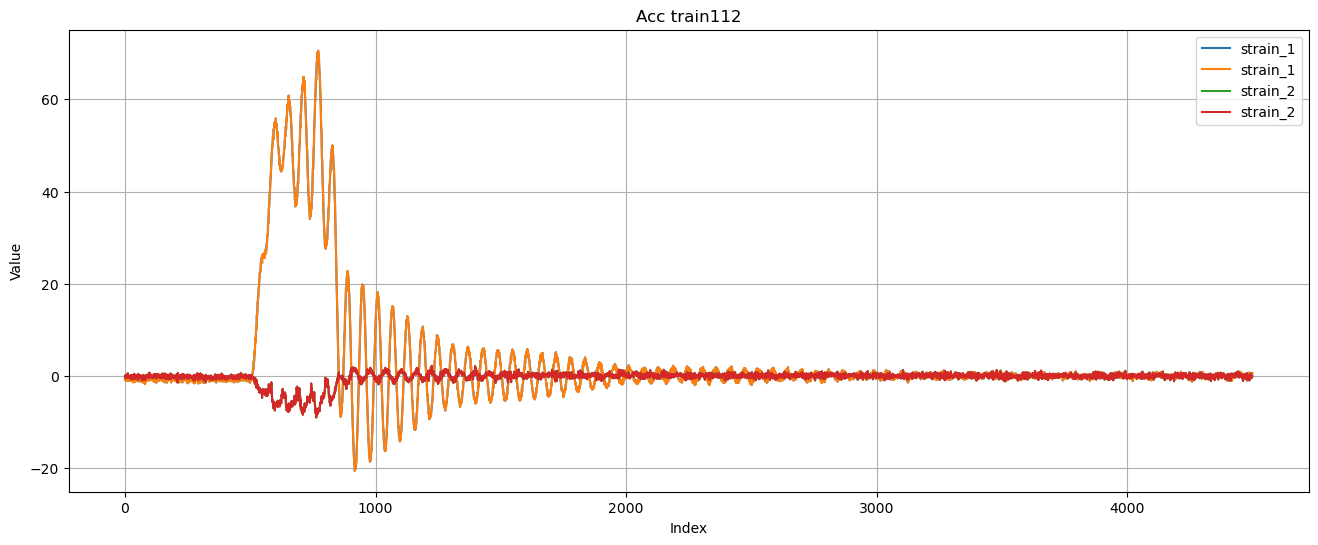

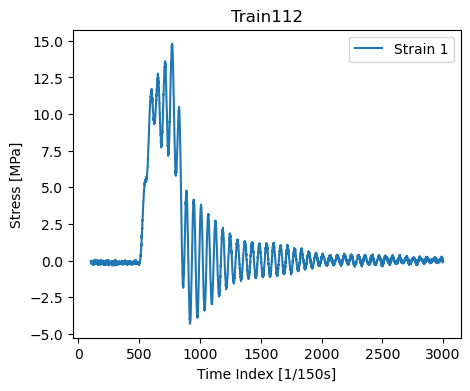

In [49]:

plt.figure(figsize=(16, 6))
for i in range(0,2,1):
    plt.plot(data_testing[train_to_visualize].iloc[:,i],label=data_testing[train_to_visualize].columns[i])
    plt.plot(data_testing[train_to_visualize].iloc[:,i],label=data_testing[train_to_visualize].columns[i])
    plt.legend()
    plt.title('Acc '+str("train"+ str(train_to_visualize)))
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.grid(True)


plt.figure(figsize=(5, 4))

#plt.plot(data_testing[24]['SG3'][0:],label='SG2')
plt.plot(data_testing[train_to_visualize]['offset_stress_1'][100:3000],label='Strain 1')

plt.legend()
plt.title('Train'+str(train_to_visualize))
plt.xlabel('Time Index [1/150s]')
plt.ylabel('Stress [MPa]')
#plt.grid(True)
# save the figure to the file
#plt.savefig('Stress history of Train 0', dpi=500)

In [75]:
from tensorflow.keras.models import Model

# Existing model inputs and outputs
inputs = CNN_model.input

# Desired layers to visualize
#layer_outputs = [layer.output for layer in model.layers if isinstance(layer, (tf.keras.layers.Conv1D, tf.keras.layers.MaxPooling1D))]
layer_outputs = [layer.output for layer in CNN_model.layers if isinstance(layer, (tf.keras.layers.MaxPooling1D))]

# Create a model for visualization
#visualization_model = Model(inputs=inputs, outputs=layer_outputs)

visualization_model = Model(inputs=CNN_model.inputs, outputs=[layer_outputs, attention_scores])


# Now you can use this model to predict and see the outputs of the intermediate layers

import matplotlib.pyplot as plt


# Assuming data_testing_X is your main data and data_testing_speed is a scalar input
# Select a single sample from each and add a batch dimension
test_input_data = [np.expand_dims(data_testing_X[test_num_visualize], axis=0), np.expand_dims(denormailzed_data_testing_speed[test_num_visualize], axis=0)]

print(test_input_data[0].shape)  # Should show (1, length_of_sequence, num_features)
print(test_input_data[1].shape)  # Should show (1, number_of_scalar_features)



# Assuming you have a sample `test_input_data` ready
#test_input_data = [data_testing_X[0],data_testing_speed[0]]  # Replace with your actual test data

# Get the outputs of all the intermediate layers
#intermediate_outputs = visualization_model.predict(test_input_data)


# Make predictions and retrieve attention scores
intermediate_outputs, attention = visualization_model.predict(test_input_data)


(1, 4500, 3)
(1, 1)


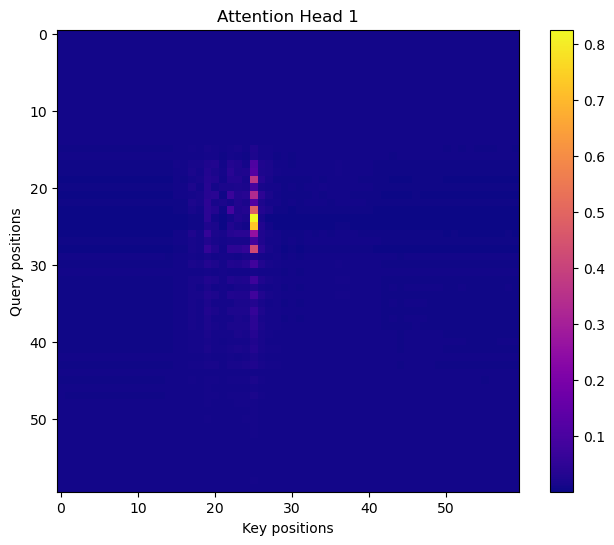

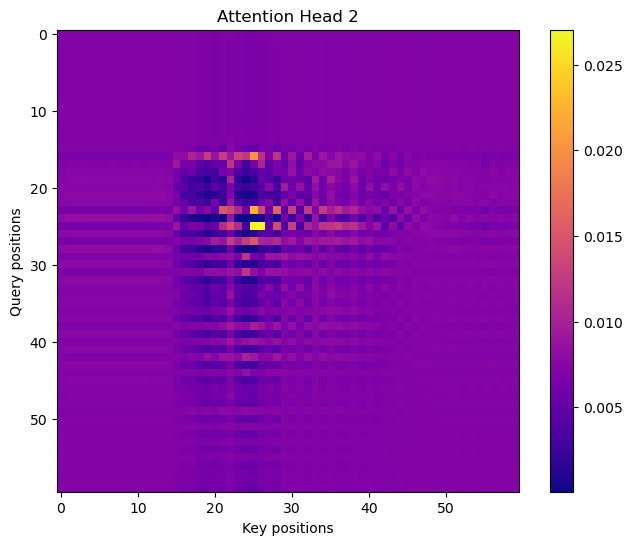

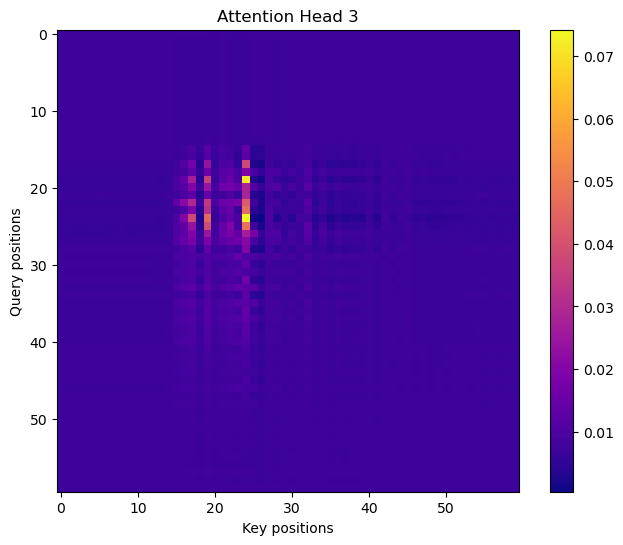

In [76]:
seq_len = attention.shape[-1]  # Assuming square attention matrices (query/key length)

num_heads = attention.shape[1]

for head in range(num_heads):
    plt.figure(figsize=(8, 6))
    plt.imshow(attention[0, head, :60, :60], cmap='plasma', interpolation='nearest')
    plt.colorbar()
    plt.title(f'Attention Head {head+1}')
    plt.xlabel('Key positions')
    plt.ylabel('Query positions')
    plt.show()

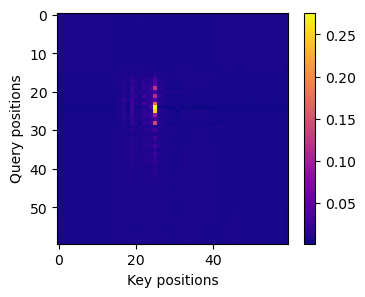

In [77]:
#avg_attention = np.mean(attention[0, :, :seq_len, :seq_len], axis=0)
avg_attention = np.mean(attention[0, :, :60, :60], axis=0)
plt.figure(figsize=(4, 3))
plt.imshow(avg_attention, cmap='plasma', interpolation='nearest')
plt.colorbar()
#plt.title('Average Attention Over Heads')
plt.xlabel('Key positions')
plt.ylabel('Query positions')
plt.show()


In [53]:
# Plot average activations across filters
for layer_activations in intermediate_outputs:
    print(layer_activations[0].shape)  # Shape of the activations

(1125, 8)
(1125, 8)
(281, 8)
(281, 8)
(140, 12)
(140, 12)


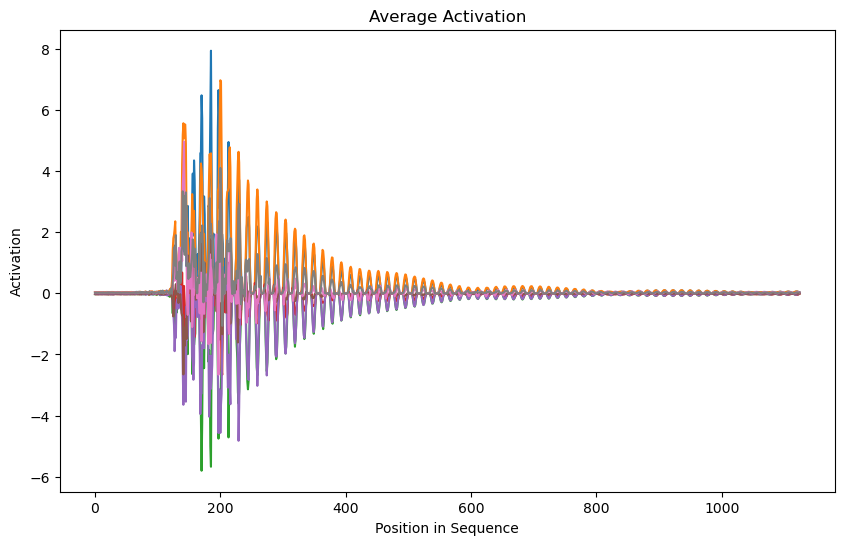

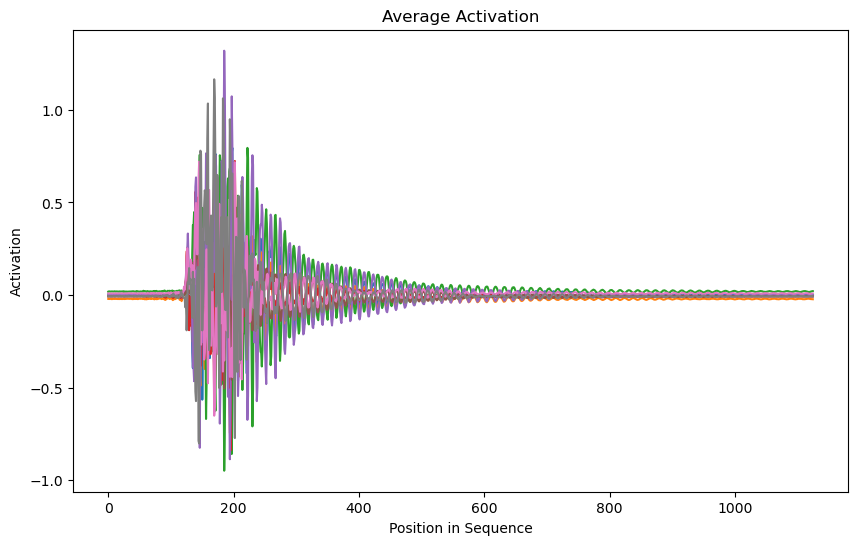

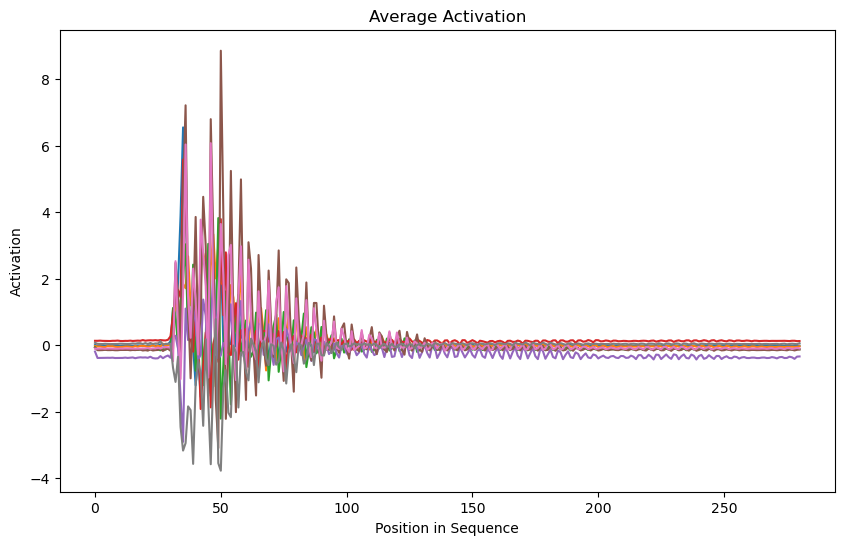

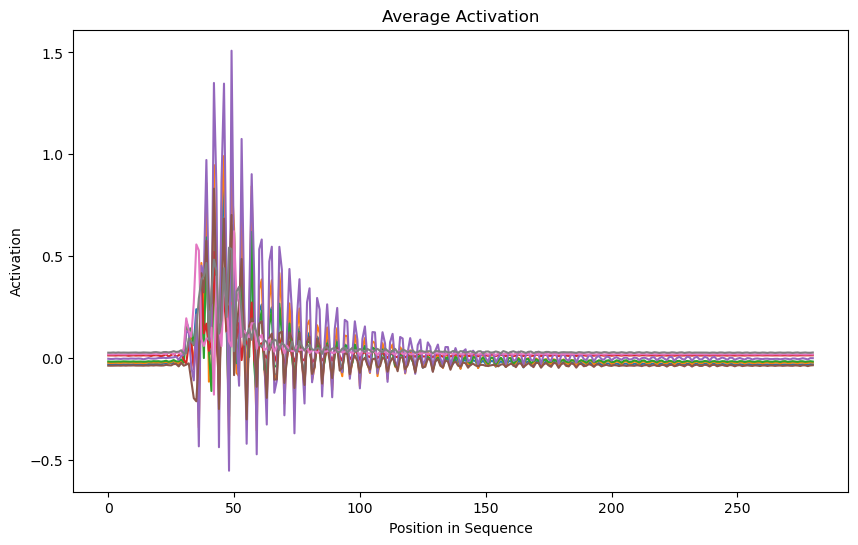

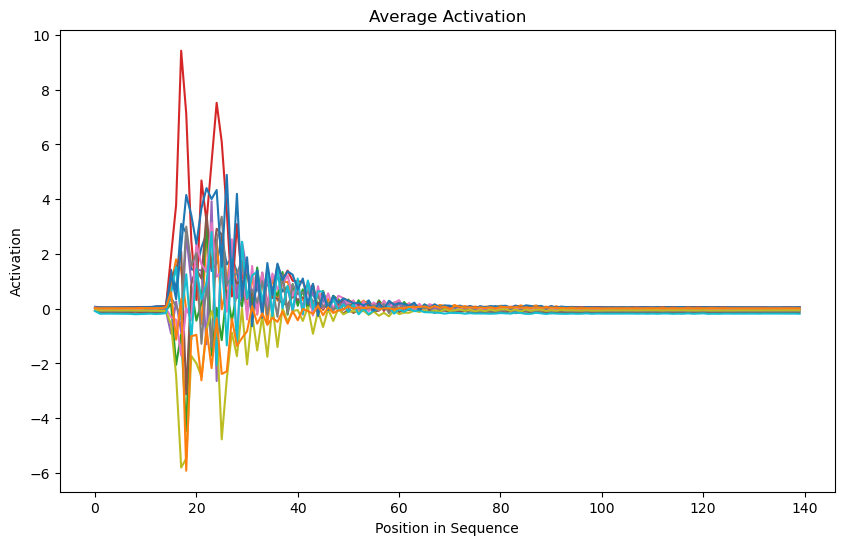

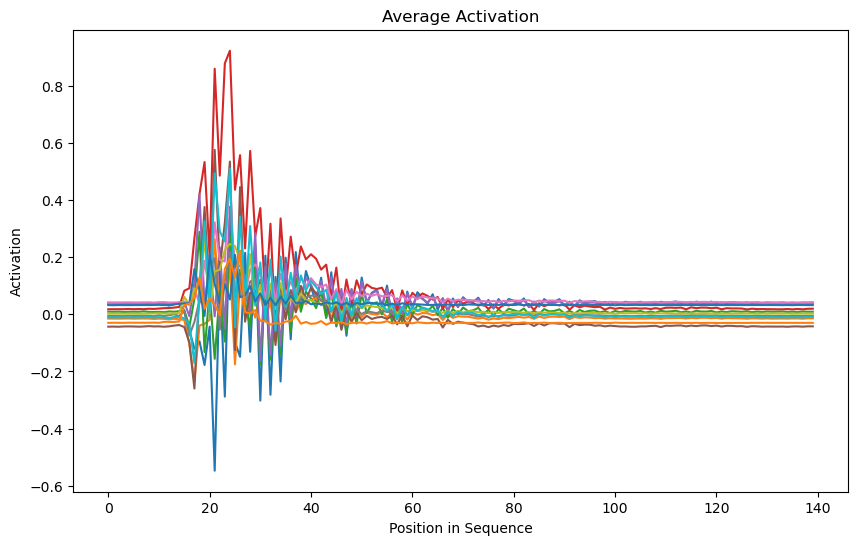

In [54]:
# Plot average activations across filters
for layer_activations in intermediate_outputs:
    plt.figure(figsize=(10, 6))
    plt.plot(layer_activations[0])
    plt.title('Average Activation')
    plt.ylabel('Activation')
    plt.xlabel('Position in Sequence')
    plt.show()

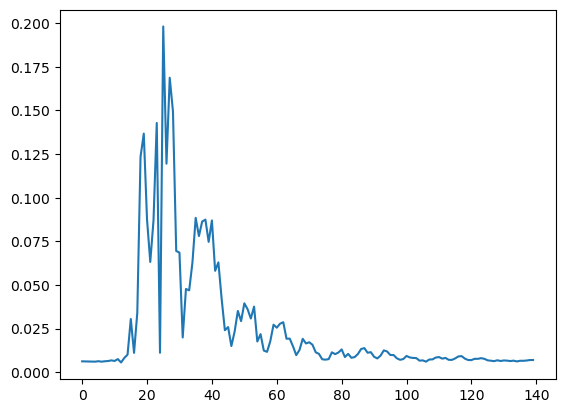

Text(0.5, 0, 'Original Sequence Position')

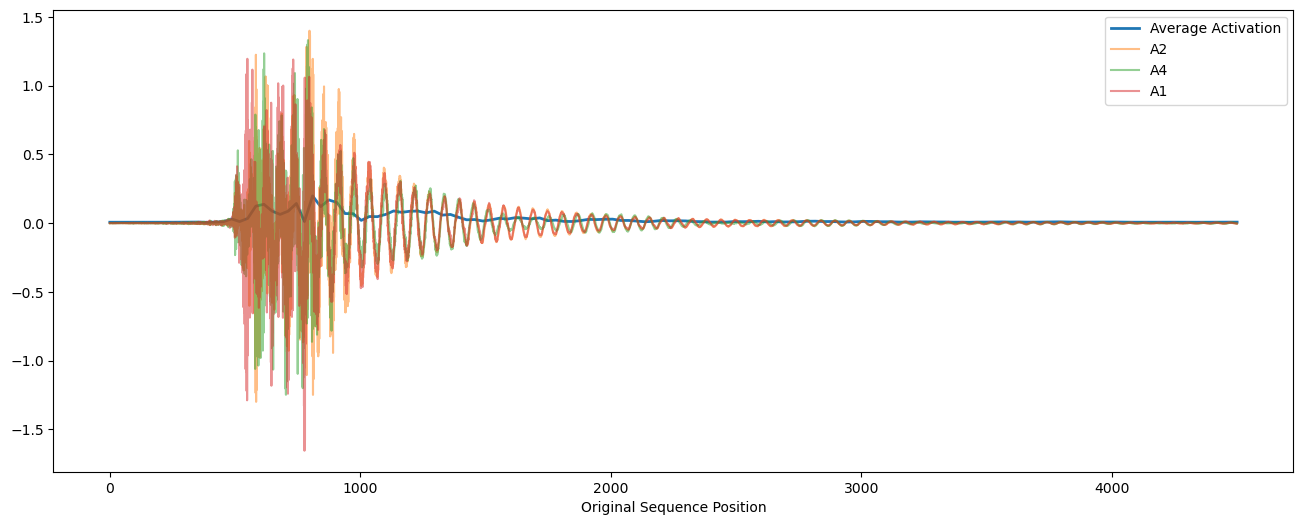

In [39]:
avg_activations = np.mean(layer_activations[0], axis=-1)  # shape: (sequence_length,)
plt.plot(avg_activations)
# show the plot
plt.show()

plt.figure(figsize=(16, 6))
compressed_seq_len = avg_activations.shape[0]
original_seq_len = 4500 # e.g., 256, 512, or whatever input length
x_positions = np.linspace(0, original_seq_len, compressed_seq_len)
plt.plot(x_positions, avg_activations, label='Average Activation', linewidth=2)
plt.xlabel('Original Sequence Position')
plt.plot(data_testing[train_to_visualize]['acc_2'][:],label='A2',alpha=0.5)
plt.plot(data_testing[train_to_visualize]['acc_4'][:],label='A4',alpha=0.5)
plt.plot(data_testing[train_to_visualize]['acc_1'][:],label='A1',alpha=0.5)
# only show the x-ticks from 0 to 2500
plt.legend()
plt.xlabel('Original Sequence Position')



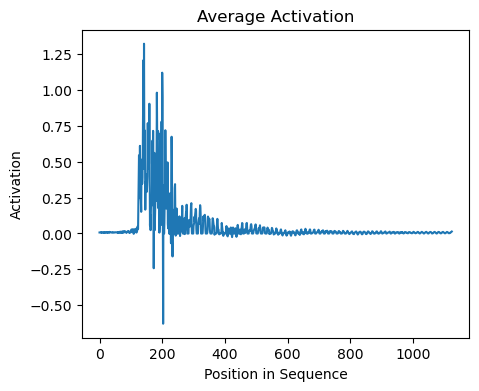

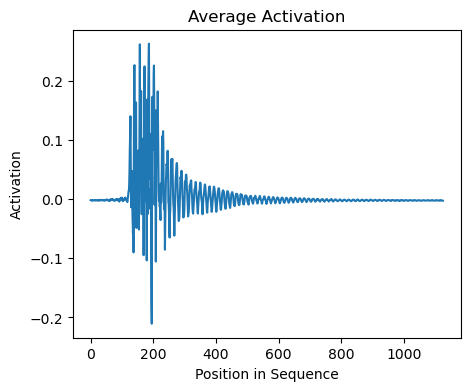

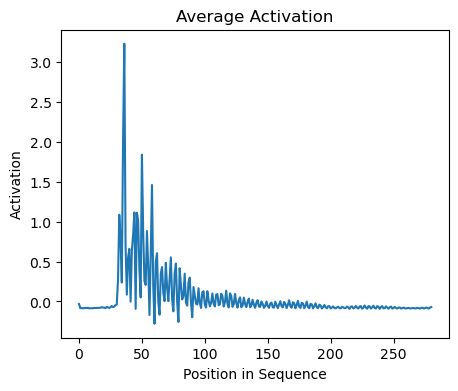

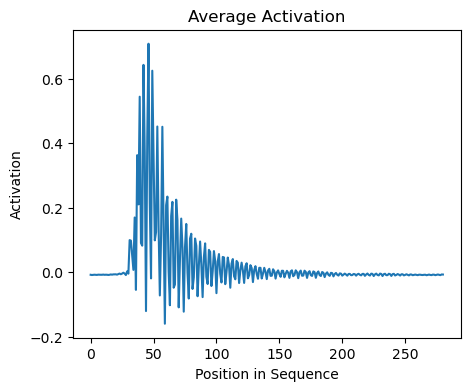

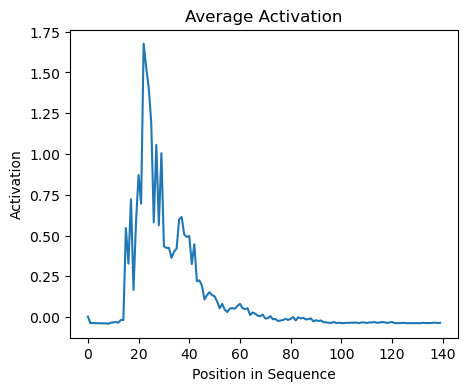

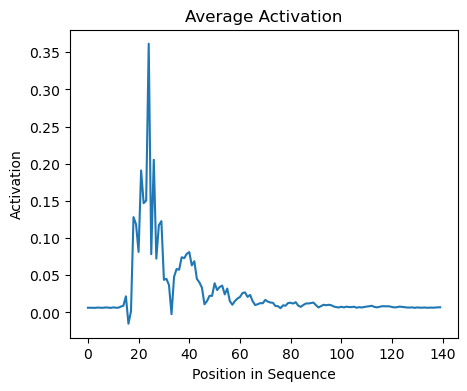

In [55]:
# Plot average activations across filters
for layer_activations in intermediate_outputs:
    avg_activation = np.mean(layer_activations[0], axis=-1)
    plt.figure(figsize=(5, 4))
    plt.plot(avg_activation)
    plt.title('Average Activation')
    plt.ylabel('Activation')
    plt.xlabel('Position in Sequence')
    plt.show()

In [453]:
layer_outputs = []
for layer in CNN_model.layers:
    if isinstance(layer, (tf.keras.layers.Conv1D, tf.keras.layers.MaxPooling1D)):
        layer_outputs.append(layer.output)
        print(f"Layer: {layer.name}, Output Shape: {layer.output_shape}")


Layer: conv1d, Output Shape: (None, 2250, 8)
Layer: conv1d_1, Output Shape: (None, 2250, 8)
Layer: max_pooling1d, Output Shape: (None, 1125, 8)
Layer: max_pooling1d_1, Output Shape: (None, 1125, 8)
Layer: conv1d_2, Output Shape: (None, 563, 8)
Layer: conv1d_3, Output Shape: (None, 563, 8)
Layer: max_pooling1d_2, Output Shape: (None, 281, 8)
Layer: max_pooling1d_3, Output Shape: (None, 281, 8)
Layer: conv1d_4, Output Shape: (None, 281, 12)
Layer: conv1d_5, Output Shape: (None, 281, 12)
Layer: max_pooling1d_4, Output Shape: (None, 140, 12)
Layer: max_pooling1d_5, Output Shape: (None, 140, 12)


In [387]:
data_testing[train_to_visualize]

strain_1  strain_2     acc_2     acc_1     acc_3     acc_4  \
0    -0.319153  0.233459  0.000189 -0.000214  0.000024 -0.000277   
1    -1.983765 -0.929016  0.001185  0.001135 -0.000782  0.002196   
2    -0.754089 -0.010559  0.001013  0.001000 -0.000162  0.000607   
3    -0.743591 -0.073059  0.000055  0.000154  0.000216  0.000572   
4    -1.872925 -0.628174  0.000347 -0.000953 -0.000181 -0.000013   
...        ...       ...       ...       ...       ...       ...   
4495  0.235107 -0.182648  0.001092  0.000005 -0.000612 -0.000235   
4496  0.052734 -0.146393  0.000896  0.000548 -0.000101  0.000327   
4497 -0.346313 -0.533356  0.000382  0.000908  0.000500 -0.000069   
4498  0.298523  0.225830  0.002067  0.000880  0.000734  0.001509   
4499  0.113220  0.401733  0.002285  0.001591  0.001037  0.001591   

      offset_stress_1  Range  Cycles    velocity  
0           -0.069637    2.0  1351.0  154.285721  
1           -0.419205    4.0    10.0  154.285721  
2           -0.160974    6.0     5.0  154.285721  
3           -0.158769    8.0     2.5  154.285721  
4           -0.395929   10.0     0.0  154.285721  
...               ...    ...     ...         ...  
4495         0.046758    NaN     NaN  154.285721  
4496         0.008459    NaN     NaN  154.285721  
4497        -0.075341    NaN     NaN  154.285721  
4498         0.060075    NaN     NaN  154.285721  
4499         0.021161    NaN     NaN  154.285721  

[4500 rows x 10 columns]

In [454]:
list_of_data = ['acc_1', 'acc_2', 'acc_4','offset_stress_1']
for i, ax in enumerate(list_of_data):
    print(i, ax)

0 acc_1
1 acc_2
2 acc_4
3 offset_stress_1


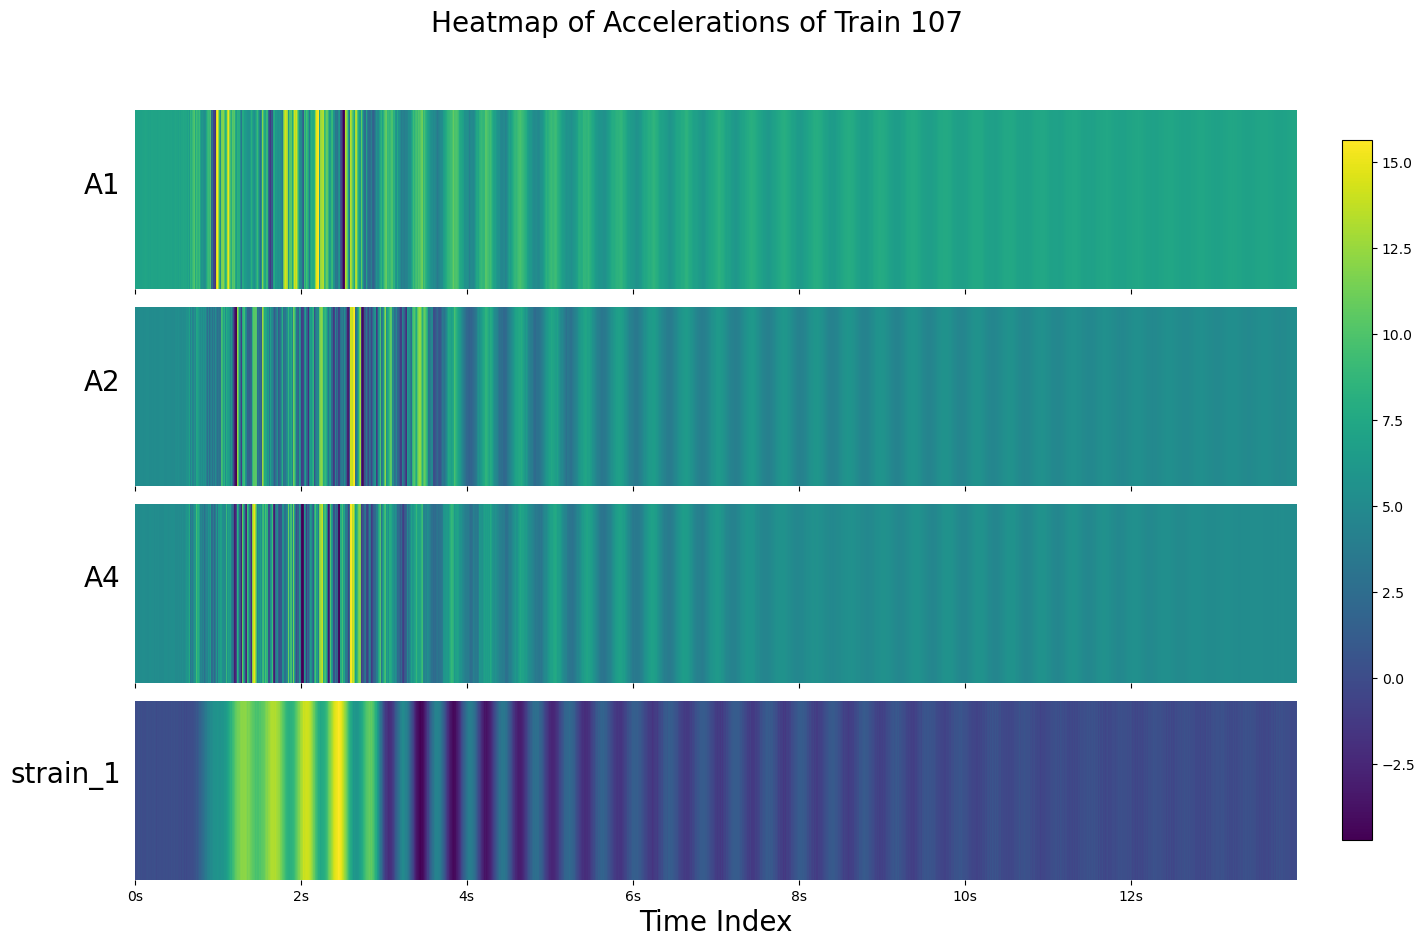

In [455]:
# Create a single figure with multiple subplots
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(15, 10), sharex=True)

# Plot data for each feature
titles = ['A1', 'A2', 'A4', 'strain_1']
list_of_data = ['acc_1', 'acc_2', 'acc_4', 'offset_stress_1']
for i, ax in enumerate(axes):  # Note: use axes, not list_of_data
    data = data_testing[train_to_visualize][list_of_data[i]][400:2500].to_numpy().reshape(1, -1)  # Reshape to (1, N)
    sns.heatmap(data, cmap='viridis', cbar=False, ax=ax)
    ax.set_ylabel(titles[i], rotation=0, labelpad=10, ha='right', fontsize=20)  # Horizontal label

# Set xlabel on the last subplot
axes[-1].set_xlabel('Time Index', fontsize=20)

# change the xticks, show seconds instead of index by 150Hz
# show the xticks horizontally
xticks = np.arange(0, 2100, 300)
axes[-1].set_xticks(xticks)
axes[-1].set_xticklabels([f'{t//150:.0f}s' for t in xticks])
axes[-1].tick_params(axis='x', rotation=0)
# hide the yticks
for ax in axes:
    ax.set_yticks([])


# Create a colorbar axis
cbar_ax = fig.add_axes([0.93, 0.15, 0.02, 0.7])  # x, y, width, height (in figure coordinate)

# Normalize color range based on combined data across all features
all_data = np.concatenate([
    data_testing[train_to_visualize][col][400:2500].to_numpy()
    for col in list_of_data
])

norm = plt.Normalize(vmin=np.min(all_data), vmax=np.max(all_data))
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])

# Create colorbar
fig.colorbar(sm, cax=cbar_ax)

# Adjust layout to make room for colorbar and reduce spacing
plt.subplots_adjust(right=0.9, hspace=0.1)

# Figure title
plt.suptitle('Heatmap of Accelerations of Train ' + str(train_to_visualize), fontsize=20)

# Show plot
plt.show()


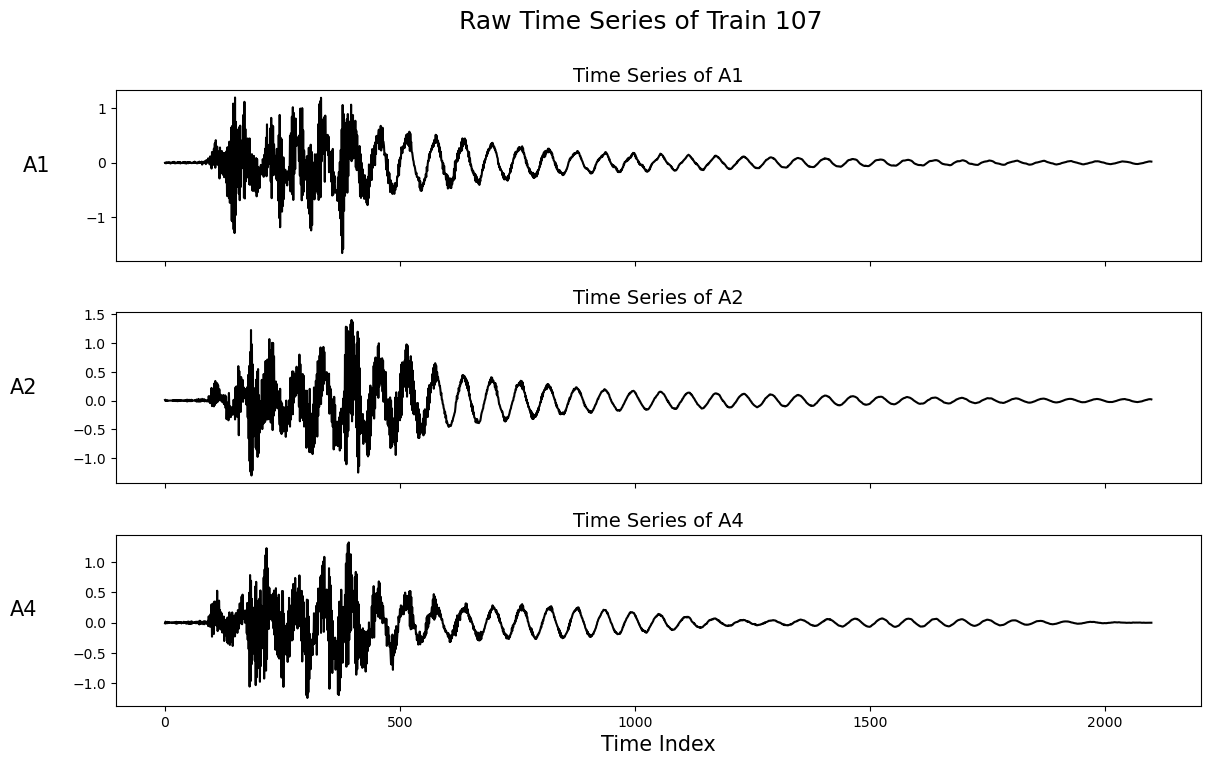

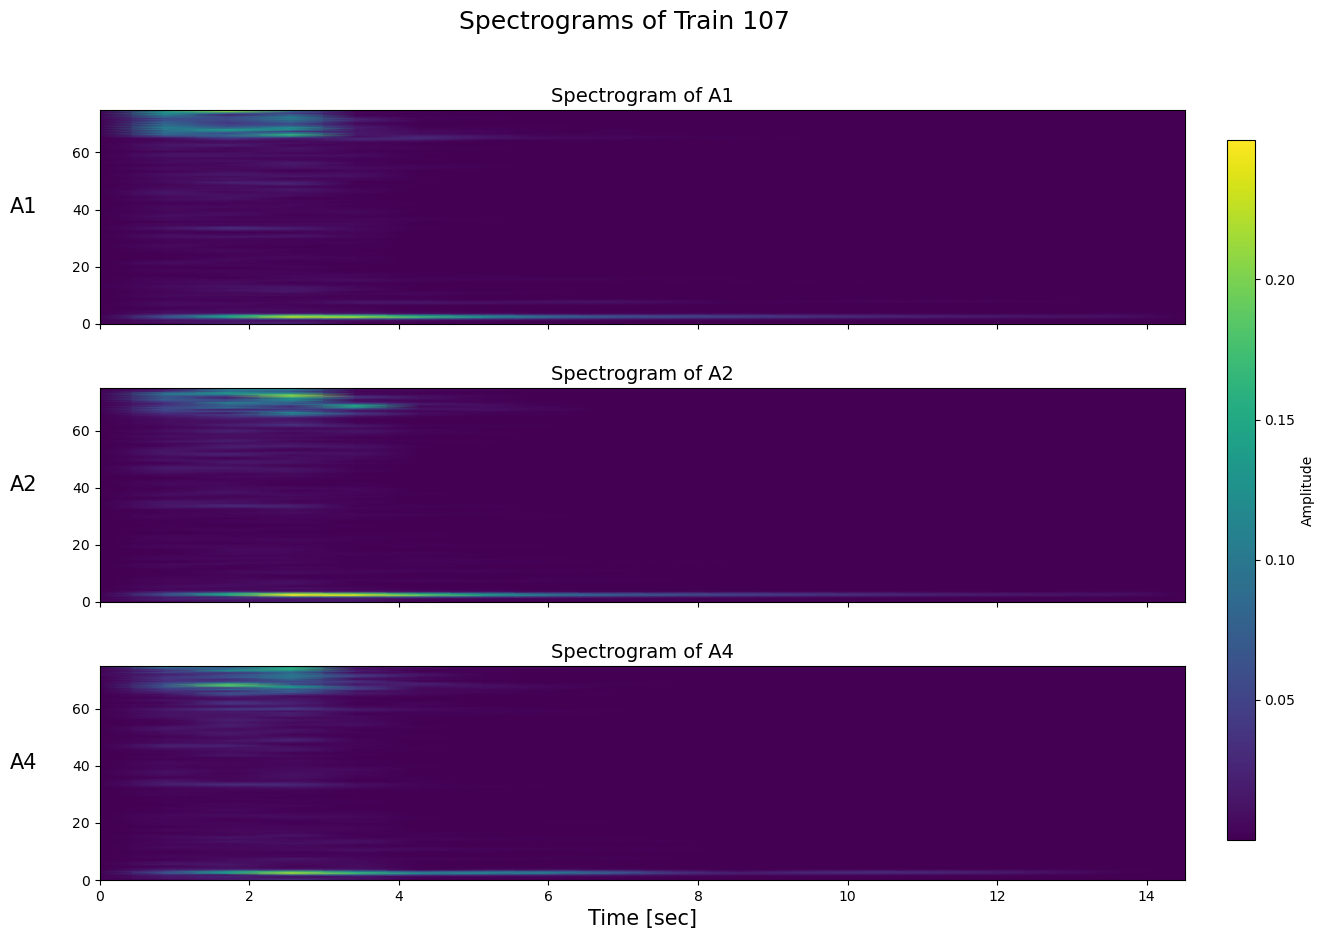

In [456]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import stft


def plot_time_series_and_spectrogram(data_testing, list_of_data, titles, sampling_rate, train_id, slice_range=(400, 2500)):
    """
    Plots raw time series and spectrograms for multiple signals from a dataset.

    Parameters:
    - data_testing: dict or DataFrame-like structure containing the signals.
    - list_of_data: list of column names corresponding to each signal (e.g., ['acc_1', 'acc_2']).
    - titles: list of titles (one for each signal).
    - sampling_rate: sampling rate in Hz (e.g., 150).
    - train_id: ID/index to access the specific train/sample in data_testing.
    - slice_range: tuple (start, end) indices to slice the signal for visualization.
    """

    num_signals = len(list_of_data)

    # ----------- 1. Time Series Plot -----------
    fig, axes = plt.subplots(nrows=num_signals, ncols=1, figsize=(14, 8), sharex=True)
    plt.subplots_adjust(hspace=0.3)
    
    for i, ax in enumerate(axes):
        data = data_testing[train_id][list_of_data[i]][slice_range[0]:slice_range[1]].to_numpy()
        ax.plot(data, color='black')
        ax.set_ylabel(titles[i], rotation=0, labelpad=25, ha='right', fontsize=15)
        ax.set_title(f"Time Series of {titles[i]}", fontsize=14)
    
    axes[-1].set_xlabel('Time Index', fontsize=15)
    plt.suptitle('Raw Time Series of Train ' + str(train_id), fontsize=18)
    plt.show()

    # ----------- 2. Spectrogram Plot -----------
    fig, axes = plt.subplots(nrows=num_signals, ncols=1, figsize=(14, 10), sharex=True)
    plt.subplots_adjust(hspace=0.3)

    # To normalize color range across all spectrograms:
    all_specs = []
    for i in range(num_signals):
        data = data_testing[train_id][list_of_data[i]][slice_range[0]:slice_range[1]].to_numpy()
        f, t, Zxx = stft(data, fs=sampling_rate, nperseg=256)
        spectrogram = np.abs(Zxx)
        all_specs.append(spectrogram)
    
    global_min = min([np.min(spec) for spec in all_specs])
    global_max = max([np.max(spec) for spec in all_specs])

    # Plot each spectrogram
    for i, ax in enumerate(axes):
        data = data_testing[train_id][list_of_data[i]][slice_range[0]:slice_range[1]].to_numpy()
        f, t, Zxx = stft(data, fs=sampling_rate, nperseg=256)
        spectrogram = np.abs(Zxx)

        pcm = ax.pcolormesh(t, f, spectrogram, shading='gouraud', cmap='viridis', vmin=global_min, vmax=global_max)
        ax.set_ylabel(titles[i], rotation=0, labelpad=25, ha='right', fontsize=15)
        ax.set_title(f"Spectrogram of {titles[i]}", fontsize=14)

    axes[-1].set_xlabel('Time [sec]', fontsize=15)

    # Add shared colorbar
    cbar_ax = fig.add_axes([0.93, 0.15, 0.02, 0.7])  # x, y, width, height
    fig.colorbar(pcm, cax=cbar_ax, label='Amplitude')

    plt.suptitle('Spectrograms of Train ' + str(train_id), fontsize=18)
    plt.show()


# ---------------------- ✅ USAGE EXAMPLE ----------------------
# Example setup
titles = ['A1', 'A2', 'A4']
list_of_data = ['acc_1', 'acc_2', 'acc_4']
sampling_rate = 150  # Hz

# Call the function
plot_time_series_and_spectrogram(
    data_testing=data_testing,  # your dataset
    list_of_data=list_of_data,
    titles=titles,
    sampling_rate=sampling_rate,
    train_id=train_to_visualize,
    slice_range=(400, 2500)  # customize if needed
)


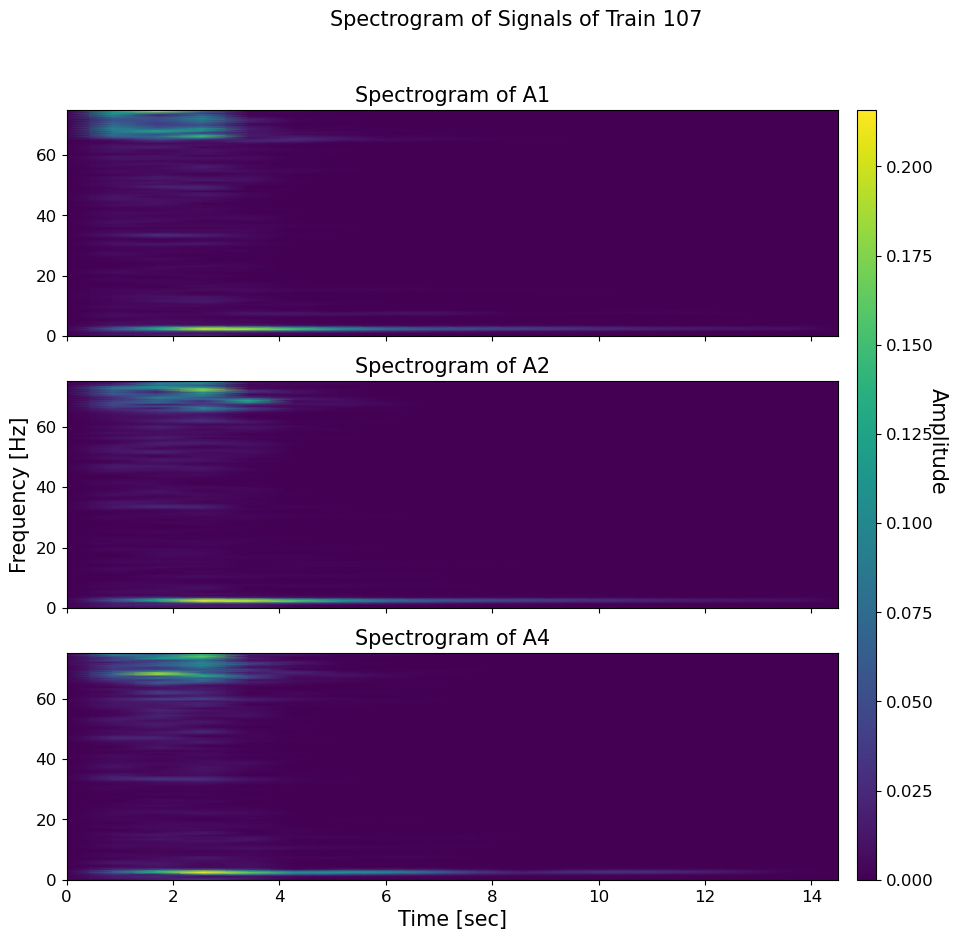

In [458]:
from scipy.signal import stft
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 10), sharex=True)
titles = ['A1', 'A2', 'A4']
list_of_data = ['acc_1', 'acc_2', 'acc_4']

for i, ax in enumerate(axes):
    data = data_testing[train_to_visualize][list_of_data[i]][400:2500].to_numpy()
    f, t, Zxx = stft(data, fs=150, nperseg=256)
    spectrogram = np.abs(Zxx)
    f = f[:]
    spectrogram = spectrogram[:, :]

    
    pcm = ax.pcolormesh(t, f, spectrogram, shading='gouraud', cmap='viridis', vmin=0, vmax=np.max(spectrogram))
    #ax.set_ylabel(titles[i], rotation=0, labelpad=20, ha='right', fontsize=15)
    ax.set_title(f"Spectrogram of {titles[i]}", fontsize=15)
    ax.xaxis.set_tick_params(labelsize=12)
    ax.yaxis.set_tick_params(labelsize=12)


axes[-1].set_xlabel('Time [sec]', fontsize=15)
axes[-2].set_ylabel('Frequency [Hz]', fontsize=15)


# Add colorbar 

fig.colorbar(pcm, ax=axes, orientation= 'vertical', label='Amplitude', pad=0.02, aspect=40)
## set the font size of the colorbar
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=12)
cbar.set_label('Amplitude', fontsize=15, labelpad=10, rotation=270, ha='right')






plt.suptitle('Spectrogram of Signals of Train ' + str(train_to_visualize), fontsize=15)
plt.show()


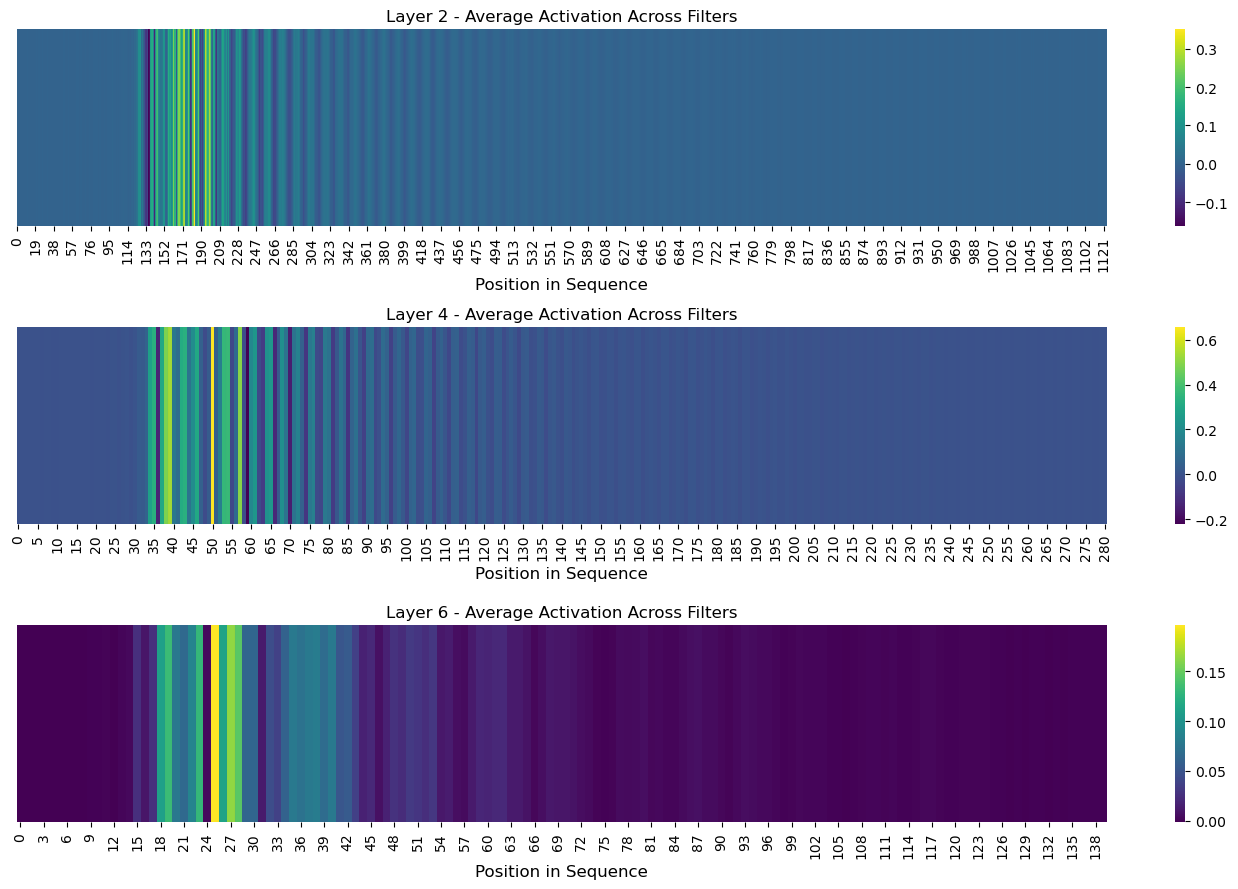

In [295]:

# ------------------ PARAMETERS -------------------
# List of indices of layers to plot (2nd, 4th, and 6th layer => indices 1, 3, 5)
selected_layer_indices = [1, 3, 5]

# ------------------ FIGURE SETUP -------------------
# Number of selected layers
num_selected_layers = len(selected_layer_indices)

# Create a single figure with subplots
fig, axes = plt.subplots(nrows=num_selected_layers, figsize=(14, 3 * num_selected_layers))

# Handle the case when only one subplot (axes is not a list)
if num_selected_layers == 1:
    axes = [axes]

# ------------------ LOOP OVER SELECTED LAYERS -------------------
# Loop only over selected layers
for idx, layer_idx in enumerate(selected_layer_indices):
    layer_activations = intermediate_outputs[layer_idx]  # Select the specific layer
    # Compute average activation across filters for this layer
    avg_activation = np.mean(layer_activations[0], axis=-1)
    
    # Find top 5 activation indices
    top_indices = np.argsort(avg_activation)[-5:]  # Top 5 activations

    # Reshape for heatmap
    avg_activation = avg_activation.reshape(1, -1)
    
    # Plot heatmap
    ax = sns.heatmap(avg_activation, cmap='viridis', cbar=True, ax=axes[idx])
    ax.set_title(f'Layer {layer_idx + 1} - Average Activation Across Filters', fontsize=12)
    ax.set_xlabel('Position in Sequence', fontsize=12)
    ax.set_yticks([])  # Hide y-ticks

    # Add red rectangles to highlight top activations
    for top_index in top_indices:
        rect = patches.Rectangle((top_index, 0), 1, 1, linewidth=0.01, edgecolor='red', facecolor='none')
        ax.add_patch(rect)

# ------------------ FINAL ADJUSTMENTS -------------------
plt.tight_layout()
# plt.savefig('Average_Activations_Selected_Layers.png', dpi=500)  # Uncomment to save
plt.show()


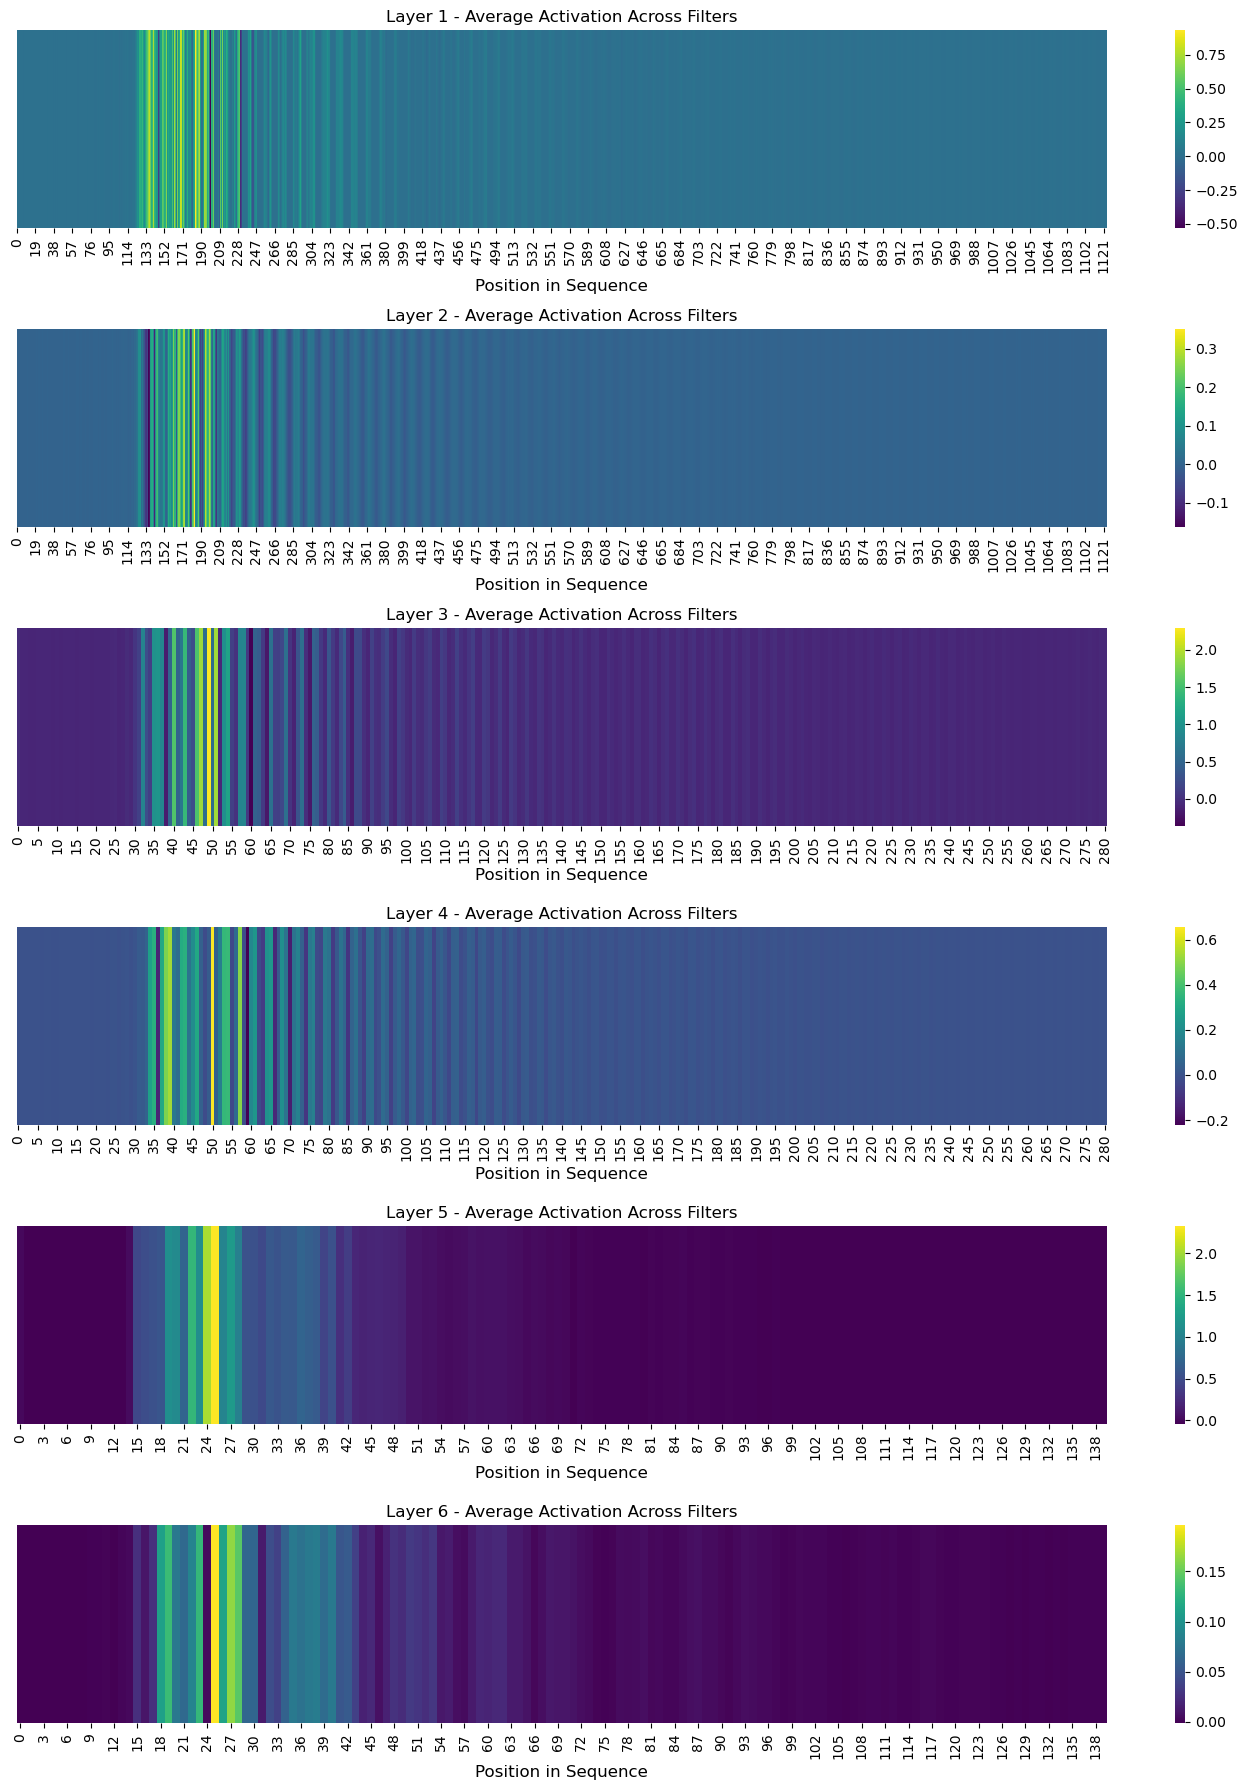

In [296]:
import matplotlib.patches as patches


# Number of layers
num_layers = len(intermediate_outputs)

# Create a single figure with subplots
fig, axes = plt.subplots(nrows=num_layers, figsize=(14, 3 * num_layers))

# Check if there is only one layer to handle indexing appropriately
if num_layers == 1:
    axes = [axes]

# Calculate average activations across filters for each layer and visualize them
for i, layer_activations in enumerate(intermediate_outputs):
    # Calculate the mean across all filters for each feature along the sequence
    avg_activation = np.mean(layer_activations[0], axis=-1)

    # Find indices of the top 4 activations
    top_indices = np.argsort(avg_activation)[-5:]  # This gives us the indices of the top 5 values
    
    # Reshape for heatmap (necessary for single dimensional output)
    avg_activation = avg_activation.reshape(1, -1)
    
    # Create heatmap on the appropriate subplot axis
    ax = sns.heatmap(avg_activation, cmap='viridis', cbar=True, ax=axes[i])
    ax.set_title(f'Layer {i+1} - Average Activation Across Filters', fontsize=12)
    #ax.set_ylabel('Average Activation', fontsize=12)
    ax.set_xlabel('Position in Sequence', fontsize=12)
    # hide the yticks
    for ax in axes:
        ax.set_yticks([])


    if i == 2 or i == 4:
            # Adding red borders to the top values
        for top_index in top_indices:
            # Add a rectangle patch with red border to the heatmap
            rect = patches.Rectangle((top_index, 0), 1, 1, linewidth=0.01, edgecolor='red', facecolor='none')
            ax.add_patch(rect)    

# Adjust layout
plt.tight_layout()

# save the figure to the file

#plt.savefig('Average Activation Across Filters 5-1', dpi=500)

plt.show()


### new model without speed

In [122]:
1+1

2

In [319]:


from tensorflow.keras.models import Sequential
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv1D, Flatten, Activation, Dropout, MaxPooling1D, MultiHeadAttention
from tensorflow.keras.models import Model
from tensorflow.keras import initializers, regularizers

# Seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Assuming the scalar data is a single value or a small set of values
#scalar_input = Input(shape=(1,))  # Adjust the shape based on your scalar data
# Map scalar input to a higher-dimensional space
#scalar_dense = Dense(256, activation='relu',kernel_initializer=initializers.GlorotUniform(seed=42))(scalar_input)


# Define input shape
input_shape = data_training_X.shape[1:]  # Adjust as per your data

# Input layer
inputs = Input(shape=input_shape)


# First Convolutional Block 
x = BatchNormalization()(inputs)
x = Activation('relu')(x)
x = Conv1D(filters=8, kernel_size=5, strides=2, padding='same',
           kernel_initializer=initializers.GlorotUniform(seed=42),
           kernel_regularizer=regularizers.l2(regularization_rate))(x)
x = MaxPooling1D(pool_size=2)(x)
#x = LayerNormalization()(x)
# Add residual connection
x1 = Conv1D(filters=8, kernel_size=1, strides=2, padding='same',kernel_initializer=initializers.GlorotUniform(seed=42))(inputs)  # Adjust filters and strides to match x
x1 = MaxPooling1D(pool_size=2)(x1)  # Add same pooling as x
x = Add()([x, x1])



# second Convolutional Block
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv1D(filters=8, kernel_size=5, strides=2, padding='same',
           kernel_initializer=initializers.GlorotUniform(seed=42),
           kernel_regularizer=regularizers.l2(regularization_rate))(x)

x = MaxPooling1D(pool_size=2)(x)
# layer normalization
#x = LayerNormalization()(x)
# Add residual connection
x2 = Conv1D(filters=8, kernel_size=1, strides=2, padding='same',kernel_initializer=initializers.GlorotUniform(seed=42))(x1)  # Adjust filters and strides to match x
x2 = MaxPooling1D(pool_size=2)(x2)  # Add same pooling as x
x = Add()([x, x2])



# third Convolutional Block32
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv1D(filters=12, kernel_size=3, strides=1, padding='same',
           kernel_initializer=initializers.GlorotUniform(seed=42),
           kernel_regularizer=regularizers.l2(regularization_rate))(x)

x = MaxPooling1D(pool_size=2, strides=2, padding='valid')(x)
#x = LayerNormalization()(x)
# Add residual connection
x3 = Conv1D(filters=12, kernel_size=1, strides=1, padding='same',kernel_initializer=initializers.GlorotUniform(seed=42))(x2)  # Adjust filters and strides to match x
x3 = MaxPooling1D(pool_size=2)(x3)  # Add same pooling as x
x = Add()([x, x3])



# Multi-Head Attention

seq_length = x.shape[1]  # Depends on previous layers' output shape
feature_dim = x.shape[2]  # The number of filters in the last Conv layer


# Assuming 'x' is the input to the attention layer
attention_layer = MultiHeadAttention(num_heads=3, key_dim=feature_dim, kernel_initializer=initializers.GlorotUniform(seed=42))
attention_output, attention_scores = attention_layer(x, x, x, return_attention_scores=True)


# Flattening the output to feed into a dense layer
flat = Flatten()(attention_output)
dense = Dropout(0.25)(flat)

# Concatenate scalar features and flattened sequence features
#concat = concatenate([dense, scalar_dense])

# normalize the concatenated data

#concat = BatchNormalization()(concat)


# Final Dense Layers

dense = Dense(32, activation='relu', kernel_initializer=initializers.GlorotUniform(seed=42))(dense)
outputs = Dense(units=14, activation='relu')(dense)  # Adjust number of units and activation based on your needs




# Create model with two inputs
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer=optimizer, loss=custom_loss, metrics=['mean_squared_error'])
#model.compile(optimizer='Adam', loss=weighted_mse_exponential, metrics=['mean_squared_error'])

#model.compile(optimizer='Adam', loss=weighted_mse_exponential_normal_distribution, metrics=['mean_squared_error'])

#model.compile(optimizer='Adam', loss=weighted_mse_log_normal_distribution, metrics=['mean_squared_error'])


# Display the model summary to check the architecture
model.summary()

"""# Apply the custom weighting
weighted_predictions = WeightApplication()([dense, scalar_input])

# Final output layer
final_output = Dense(units=32, activation='relu')(weighted_predictions)
final_output = Dense(units=20, activation='relu')(final_output)

# Model definition
model = Model(inputs=[inputs, scalar_input], outputs=final_output)
model.compile(optimizer='Adam', loss=custom_loss, metrics=['mean_squared_error'])

# Model summary
model.summary()"""






Model: "model_46"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_72 (InputLayer)          [(None, 4500, 3)]    0           []                               
                                                                                                  
 batch_normalization_138 (Batch  (None, 4500, 3)     12          ['input_72[0][0]']               
 Normalization)                                                                                   
                                                                                                  
 activation_138 (Activation)    (None, 4500, 3)      0           ['batch_normalization_138[0][0]']
                                                                                                  
 conv1d_276 (Conv1D)            (None, 2250, 8)      128         ['activation_138[0][0]']  

"# Apply the custom weighting\nweighted_predictions = WeightApplication()([dense, scalar_input])\n\n# Final output layer\nfinal_output = Dense(units=32, activation='relu')(weighted_predictions)\nfinal_output = Dense(units=20, activation='relu')(final_output)\n\n# Model definition\nmodel = Model(inputs=[inputs, scalar_input], outputs=final_output)\nmodel.compile(optimizer='Adam', loss=custom_loss, metrics=['mean_squared_error'])\n\n# Model summary\nmodel.summary()"

In [320]:
# 开始模型训练
history = model.fit(x=data_training_X, y=data_training_Y, batch_size=batch_size, epochs=190,
          verbose=1, validation_split=0.1, shuffle=False)

Epoch 1/190
3/3 [==============================] - 1s 146ms/step - loss: 11.1130 - mean_squared_error: 5.5530 - val_loss: 7.6735 - val_mean_squared_error: 3.8301
Epoch 2/190
3/3 [==============================] - 0s 21ms/step - loss: 10.3534 - mean_squared_error: 5.2234 - val_loss: 7.2932 - val_mean_squared_error: 3.6562
Epoch 3/190
3/3 [==============================] - 0s 22ms/step - loss: 9.8603 - mean_squared_error: 5.0867 - val_loss: 7.0134 - val_mean_squared_error: 3.5198
Epoch 4/190
3/3 [==============================] - 0s 21ms/step - loss: 9.6441 - mean_squared_error: 4.9257 - val_loss: 7.0510 - val_mean_squared_error: 3.5271
Epoch 5/190
3/3 [==============================] - 0s 21ms/step - loss: 9.6129 - mean_squared_error: 4.8480 - val_loss: 7.1654 - val_mean_squared_error: 3.5796
Epoch 6/190
3/3 [==============================] - 0s 19ms/step - loss: 9.6092 - mean_squared_error: 4.8298 - val_loss: 7.2073 - val_mean_squared_error: 3.6005
Epoch 7/190
3/3 [====================

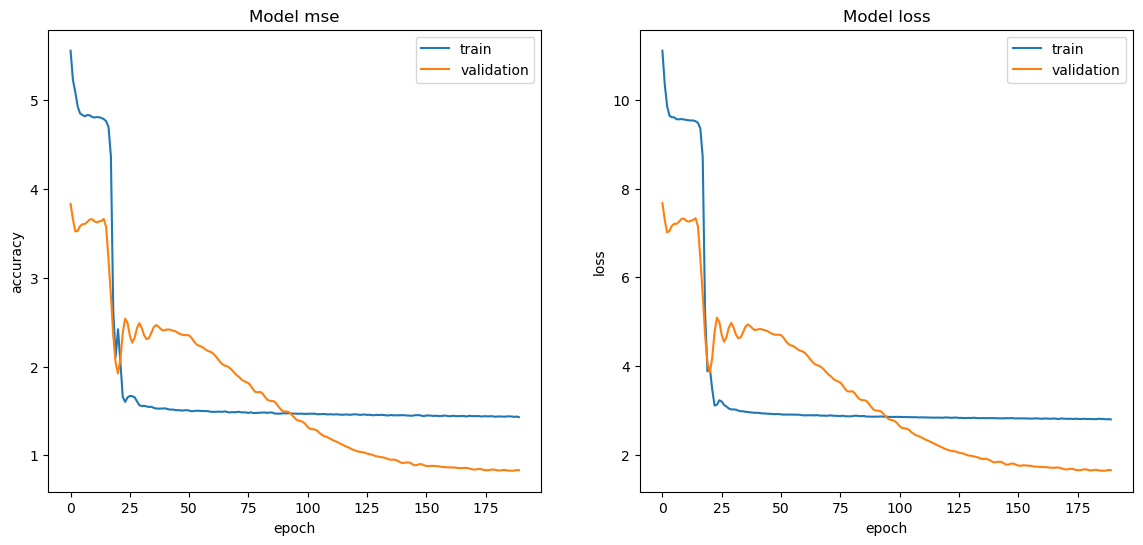

In [321]:
#plot the mse of the training and validation on the left(2,1) and the loss of the training and validation on the right(2,2)
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['mean_squared_error'][:])
plt.plot(history.history['val_mean_squared_error'][:])
plt.title('Model mse')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'][:])
plt.plot(history.history['val_loss'][:])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'],loc = 'upper right')

# save the picture in png format
#plt.savefig('model_loss3-8.png', dpi=1000)

plt.show()


In [322]:
#set a timer to record the time of the prediction]
import time
start = time.time()
# predict the data_testing_X
y_pred = model.predict(data_testing_X)

end = time.time()
print("Time taken to predict the data_testing_X is ", end - start)
# Rounding the predictions
rounded_predictions = round_to_nearest_half(y_pred)


Time taken to predict the data_testing_X is  0.1440720558166504


In [323]:
# calculate the mse of prediction

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# calculate the mse of the prediction
mse = mean_squared_error(data_testing_Y, y_pred)

# calculate the custom loss of the prediction
custom_loss_value = custom_loss(data_testing_Y, y_pred)

# calculate the mean value of custom loss
mean_custom_loss = np.mean(custom_loss_value)

print('The mse of the prediction is ', mse)
print('The mean value of the custom loss is ', mean_custom_loss)

The mse of the prediction is  2.2289355
The mean value of the custom loss is  4.447828


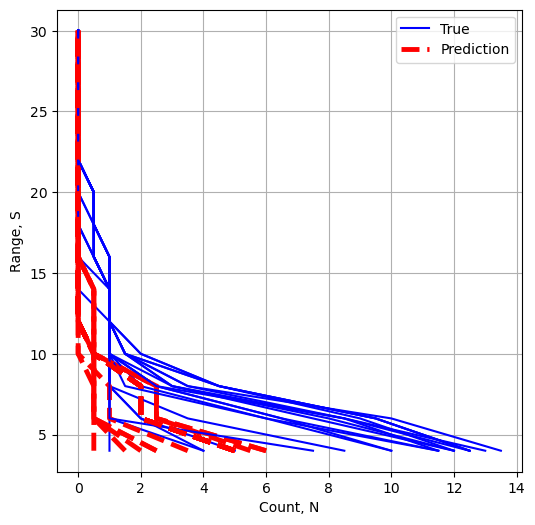

In [58]:
S = list(range(4,32,2))

# Plot all predictions on a same plot
figure = plt.figure(figsize=(6, 6))
for i in range(len(rounded_predictions)):
    pre_N = rounded_predictions[i]
    N = data_testing_Y[i]
    Ncum = N.sum() - np.cumsum(N)
    pre_Ncum = pre_N.sum() - np.cumsum(pre_N)
    one_sigma = np.sqrt(np.mean((pre_N - N)**2))

    #plt.semilogx(Ncum, S, color = 'blue')
    plt.plot(Ncum, S, color = 'blue',linewidth=1.5, label='True')
    #plt.semilogx(pre_Ncum, S, color = 'red', linestyle='--',linewidth=3.5)
    plt.plot(pre_Ncum, S, color = 'red', linestyle='--',linewidth=3.5, label='Prediction')
    #plt.title('train number = '+str(test_num[i]))
    # plot the one sigma error bar
    #plt.fill_betweenx(S, pre_Ncum - one_sigma, pre_Ncum + one_sigma, color='red', alpha=0.05)
    plt.xlabel('Count, N')
    plt.ylabel('Range, S')
    #plt.legend()
    plt.grid(True)
    if i == 0:
        plt.legend()


#figure.savefig('predicts3-8.png', dpi=1000)

# add a test to the plot to show the color of the line

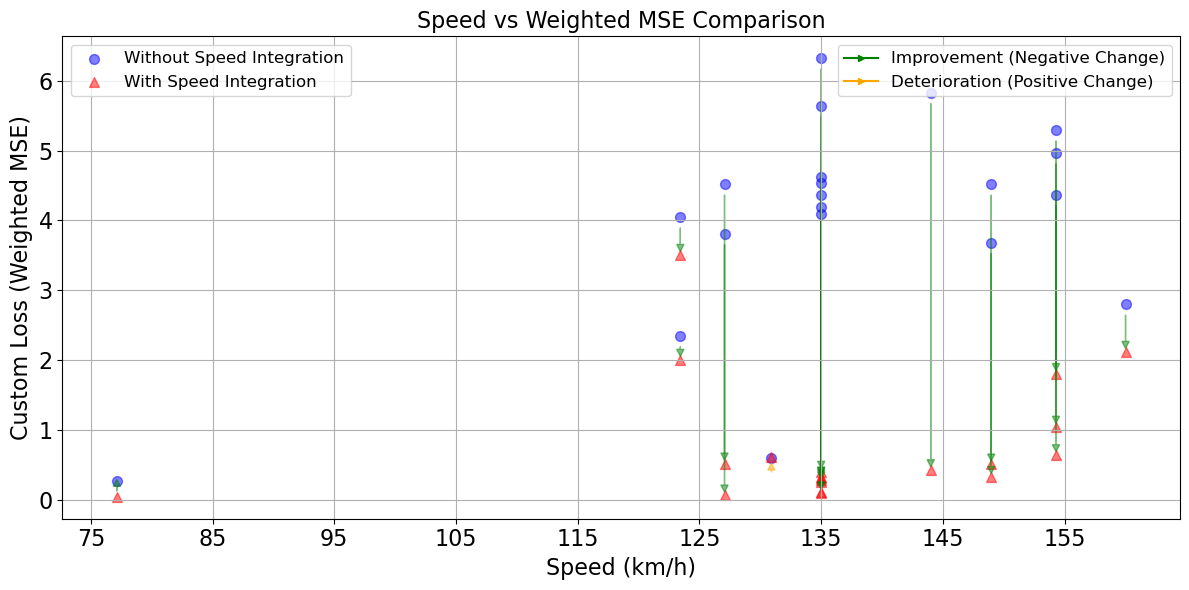

In [59]:

# Setting up the plot
plt.figure(figsize=(12, 6))  # Larger figure size for better readability

# Scatter plots
scatter1 = plt.scatter(denormailzed_data_testing_speed, custom_loss_value, 
            label='Without Speed Integration', marker='o', s=50, alpha=0.5, color='blue')
scatter2 = plt.scatter(denormailzed_data_testing_speed, CNN_custom_loss_value, 
            label='With Speed Integration', marker='^', s=50, alpha=0.5, color='red')

# Adding arrows and conditional annotations
for i in range(len(denormailzed_data_testing_speed)):
    change = CNN_custom_loss_value[i] - custom_loss_value[i]  # Calculate the change
    arrow_color = 'orange' if change > 0 else 'green'

    # Adjust the arrow starting point for visibility
    start_y_position = custom_loss_value[i] - 0.15 if change < 0 else custom_loss_value[i] -0.2
    change_adjusted = change + 0.3 if change < 0 else change +0.01

    # Draw arrow
    plt.arrow(denormailzed_data_testing_speed[i], start_y_position, 
              0, change_adjusted, head_width=0.6, head_length=0.1, fc=arrow_color, ec=arrow_color, alpha=0.5)

    # Add text annotation only if the change is negative
    if change < 0:
        if denormailzed_data_testing_speed[i] < 65:
            annotation_x_position = denormailzed_data_testing_speed[i]
            annotation_y_position = custom_loss_value[i] + change / 2  # Mid-point of the arrow
            plt.text(annotation_x_position, annotation_y_position, f'{change:.2f}', 
                 color='black', ha='right', va='center', fontsize=14)

# Plot aesthetics
plt.xlabel('Speed (km/h)',fontdict={'fontsize': 16})
plt.ylabel('Custom Loss (Weighted MSE)',fontdict={'fontsize': 16})
plt.title('Speed vs Weighted MSE Comparison',fontdict={'fontsize': 16})
plt.xticks(np.arange(75, 160, 10), fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)

# Create custom legend for arrow colors
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color='green', markerfacecolor='green', marker='>', label='Improvement (Negative Change)', markersize=5),
                   Line2D([0], [0], color='orange', markerfacecolor='orange', marker='>', label='Deterioration (Positive Change)', markersize=5)]

# Add first legend (scatter plots) to axes
first_legend = plt.legend(handles=[scatter1, scatter2], loc='upper left', fontsize=12)
plt.gca().add_artist(first_legend)

# Add second legend (custom arrows)
plt.legend(handles=legend_elements, loc='upper right',fontsize=12)

plt.tight_layout()  # Adjust layout
plt.show()


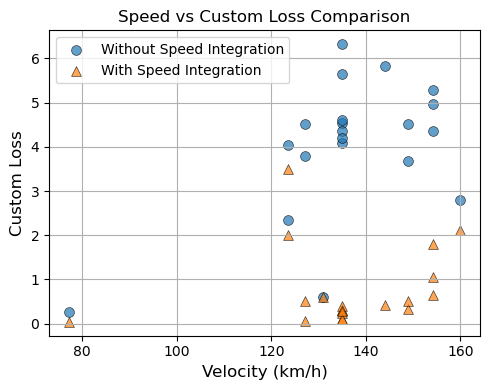

In [60]:
from matplotlib.patches import Circle
# Setting up the plot with enhanced features
plt.figure(figsize=(5, 4))  # Increase the figure size for better readability
plt.scatter(denormailzed_data_testing_speed, custom_loss_value, 
            label='Without Speed Integration', marker='o', s=50, alpha=0.7, edgecolors='k', linewidth=0.5)
plt.scatter(denormailzed_data_testing_speed, CNN_custom_loss_value, 
            label='With Speed Integration', marker='^', s=50, alpha=0.7, edgecolors='k', linewidth=0.5)

# Plot aesthetics
plt.xlabel('Velocity (km/h)', fontsize=12)
plt.ylabel('Custom Loss', fontsize=12)
plt.title('Speed vs Custom Loss Comparison')
plt.grid(True)
plt.legend()
plt.tight_layout()  # Adjusts plot to ensure everything fits without overlap

# Save the figure to the file
# plt.savefig('Enhanced Speed vs Custom Loss Comparison', dpi=500)





plt.show()

Text(0, 0.5, 'Δ Loss')

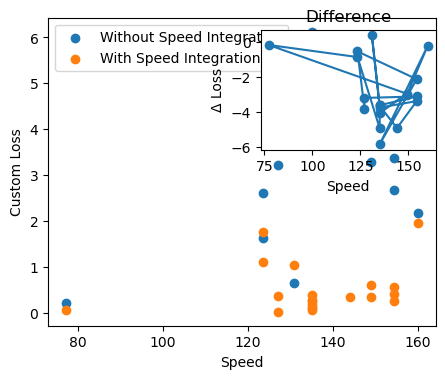

In [222]:
difference = np.array(CNN_custom_loss_value) - np.array(custom_loss_value)

fig, ax = plt.subplots(figsize=(5,4))

# Original scatter plots
ax.scatter(denormailzed_data_testing_speed, custom_loss_value, label='Without Speed Integration')
ax.scatter(denormailzed_data_testing_speed, CNN_custom_loss_value, label='With Speed Integration')
ax.legend()
ax.set_xlabel('Speed')
ax.set_ylabel('Custom Loss')

# Inset for difference
inset_ax = fig.add_axes([0.55, 0.55, 0.35, 0.3])  # [left, bottom, width, height]
inset_ax.plot(denormailzed_data_testing_speed, difference, marker='o', linestyle='-')
inset_ax.set_title("Difference")
inset_ax.set_xlabel('Speed')
inset_ax.set_ylabel('Δ Loss')

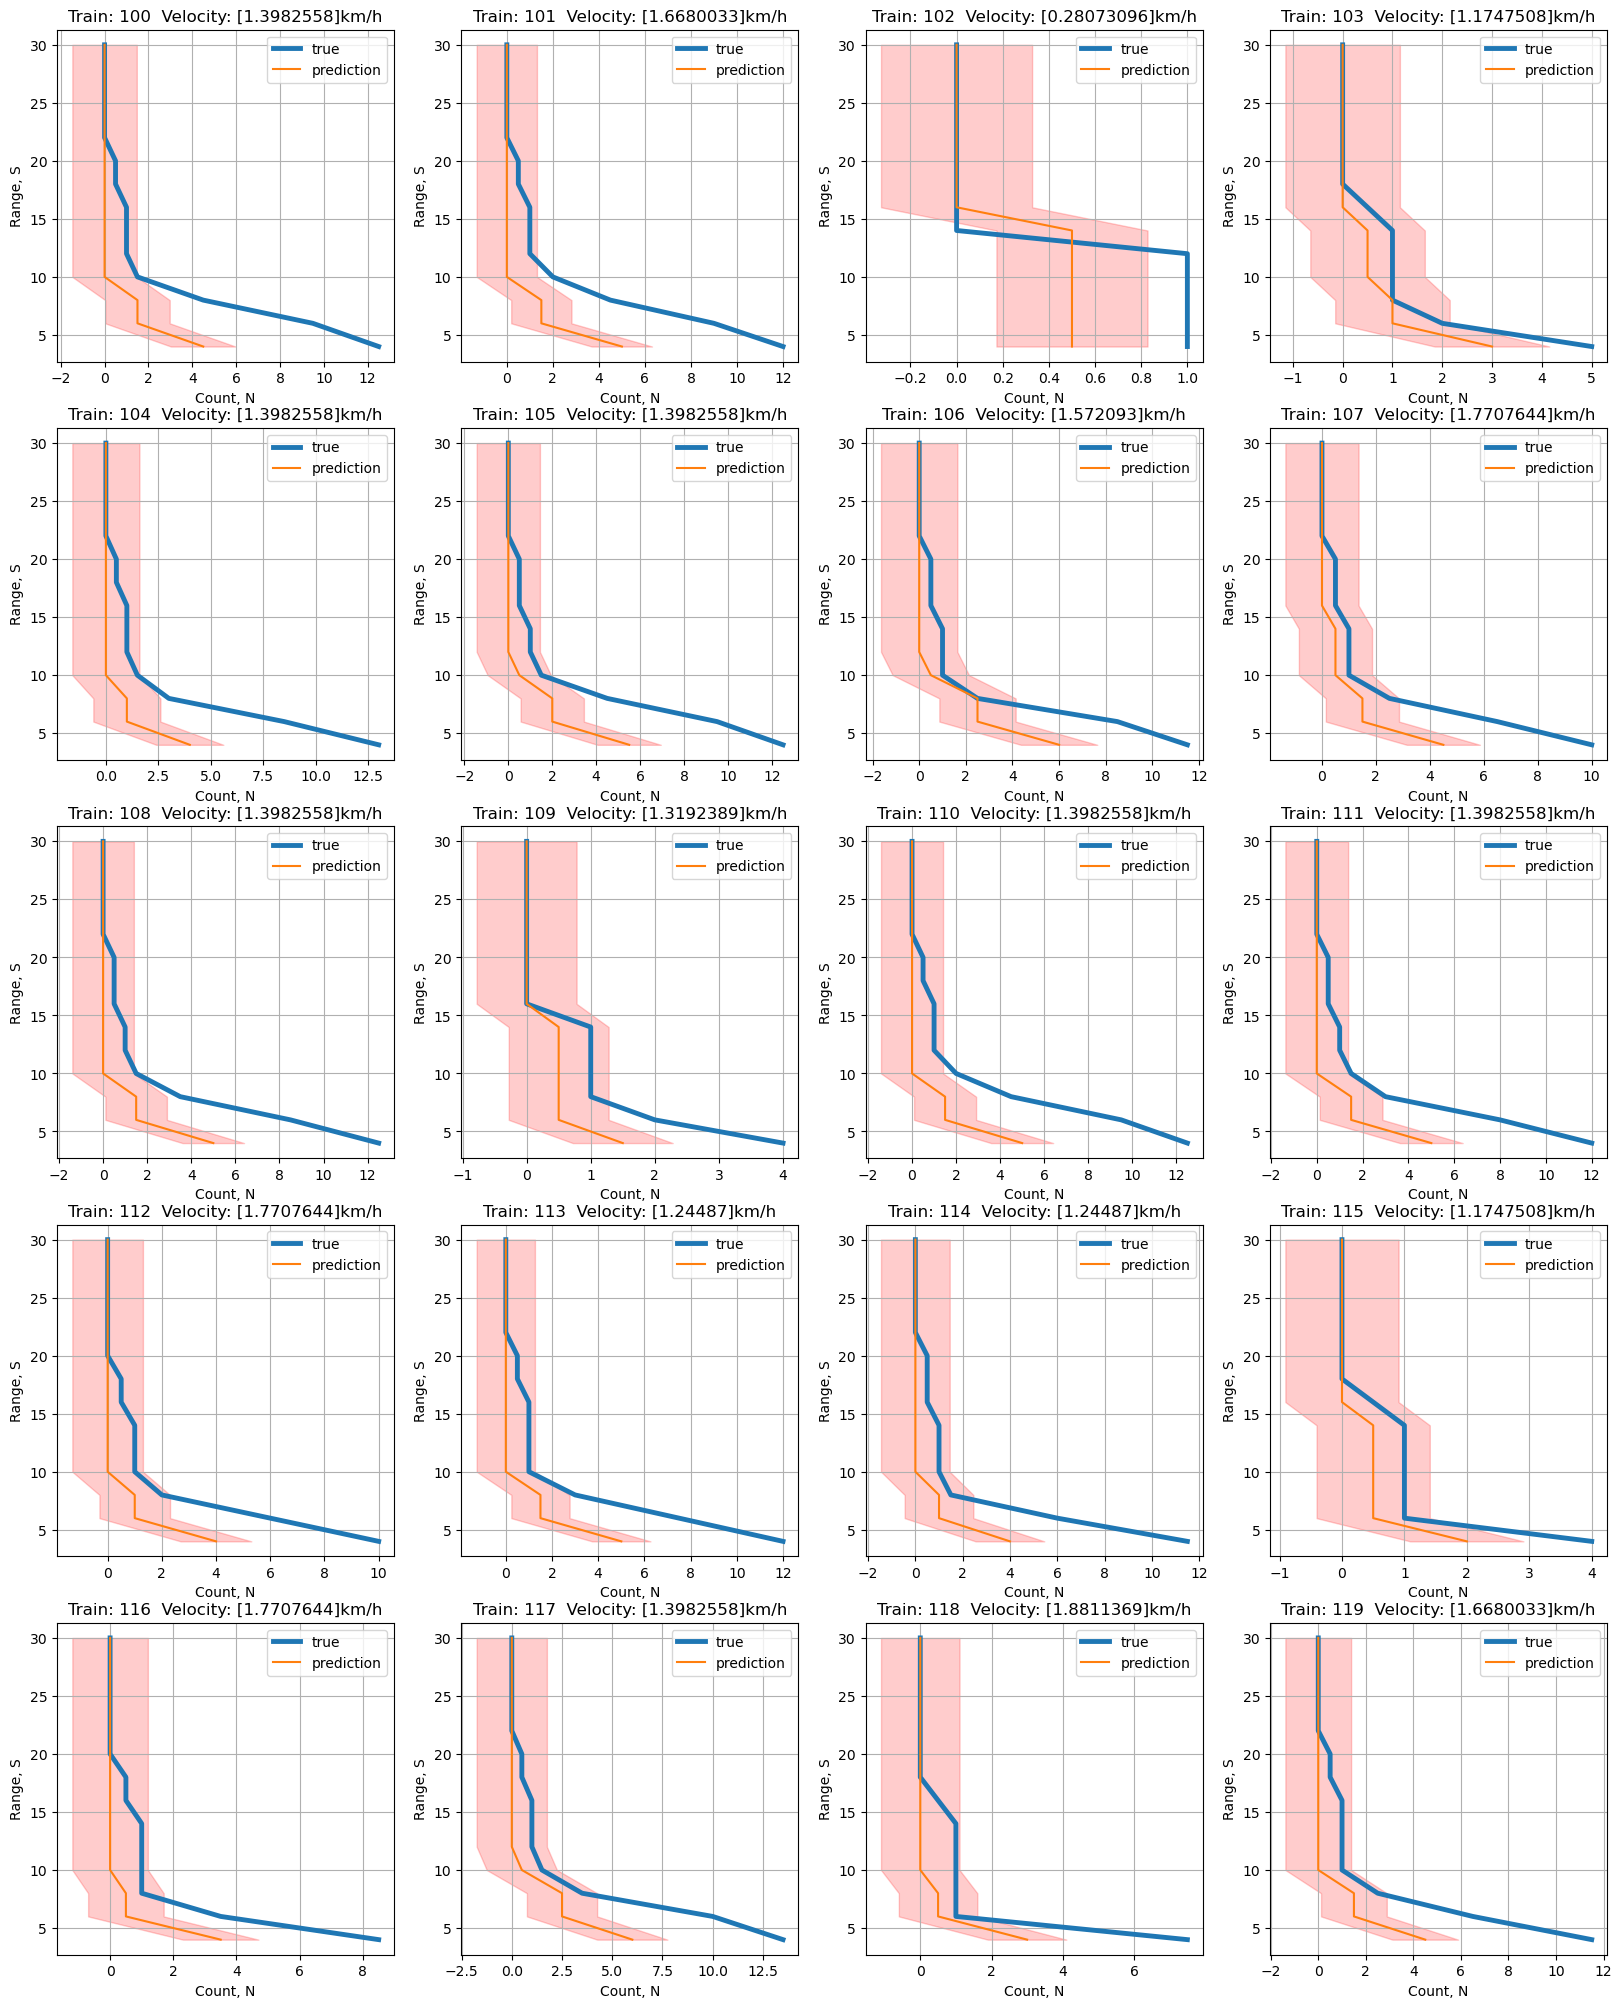

In [223]:
# plot all predictions on a plot with the same color
S = list(range(4,32,2))
figure, axes = plt.subplots(5, 4, figsize=(20, 25))

for i in range(len(rounded_predictions)):
    pre_N = rounded_predictions[i]
    N = data_testing_Y[i]
    Ncum = N.sum() - np.cumsum(N)
    pre_Ncum = pre_N.sum() - np.cumsum(pre_N)
    # calculate the one sigma of the prediction
    one_sigma = np.sqrt(np.mean((pre_N - N)**2))


    ax = axes[i//4, i%4]
    ax.plot(Ncum, S, label='true',linewidth=3.5)
    # plot the two sigma of the prediction
    ax.fill_betweenx(S, pre_Ncum-1*one_sigma, pre_Ncum+1*one_sigma, color='r', alpha=0.2)
    #ax.fill_betweenx(S, pre_Ncum-2*one_sigma, pre_Ncum+1*one_sigma-2*one_sigma, color='y', alpha=0.3)
    #ax.fill_betweenx(S, pre_Ncum+1*one_sigma, pre_Ncum+2*one_sigma, color='y', alpha=0.3)

    #ax.fill_betweenx(S, pre_Ncum-2*one_sigma-3*one_sigma, pre_Ncum+2*one_sigma+3*one_sigma, color='b', alpha=0.1)
    ax.plot(pre_Ncum, S, label='prediction')
    # in the tile of each plot, show the train number and the velocity of the train
    ax.set_title('Train: '+str(test_num[i])+'  Velocity: '+str(speed_test[i]) +'km/h')
    ax.set_xlabel('Count, N')
    ax.set_ylabel('Range, S')
    ax.legend()
    ax.grid(True)

#figure.savefig('predictions3-8.png', dpi=1000)
plt.show()


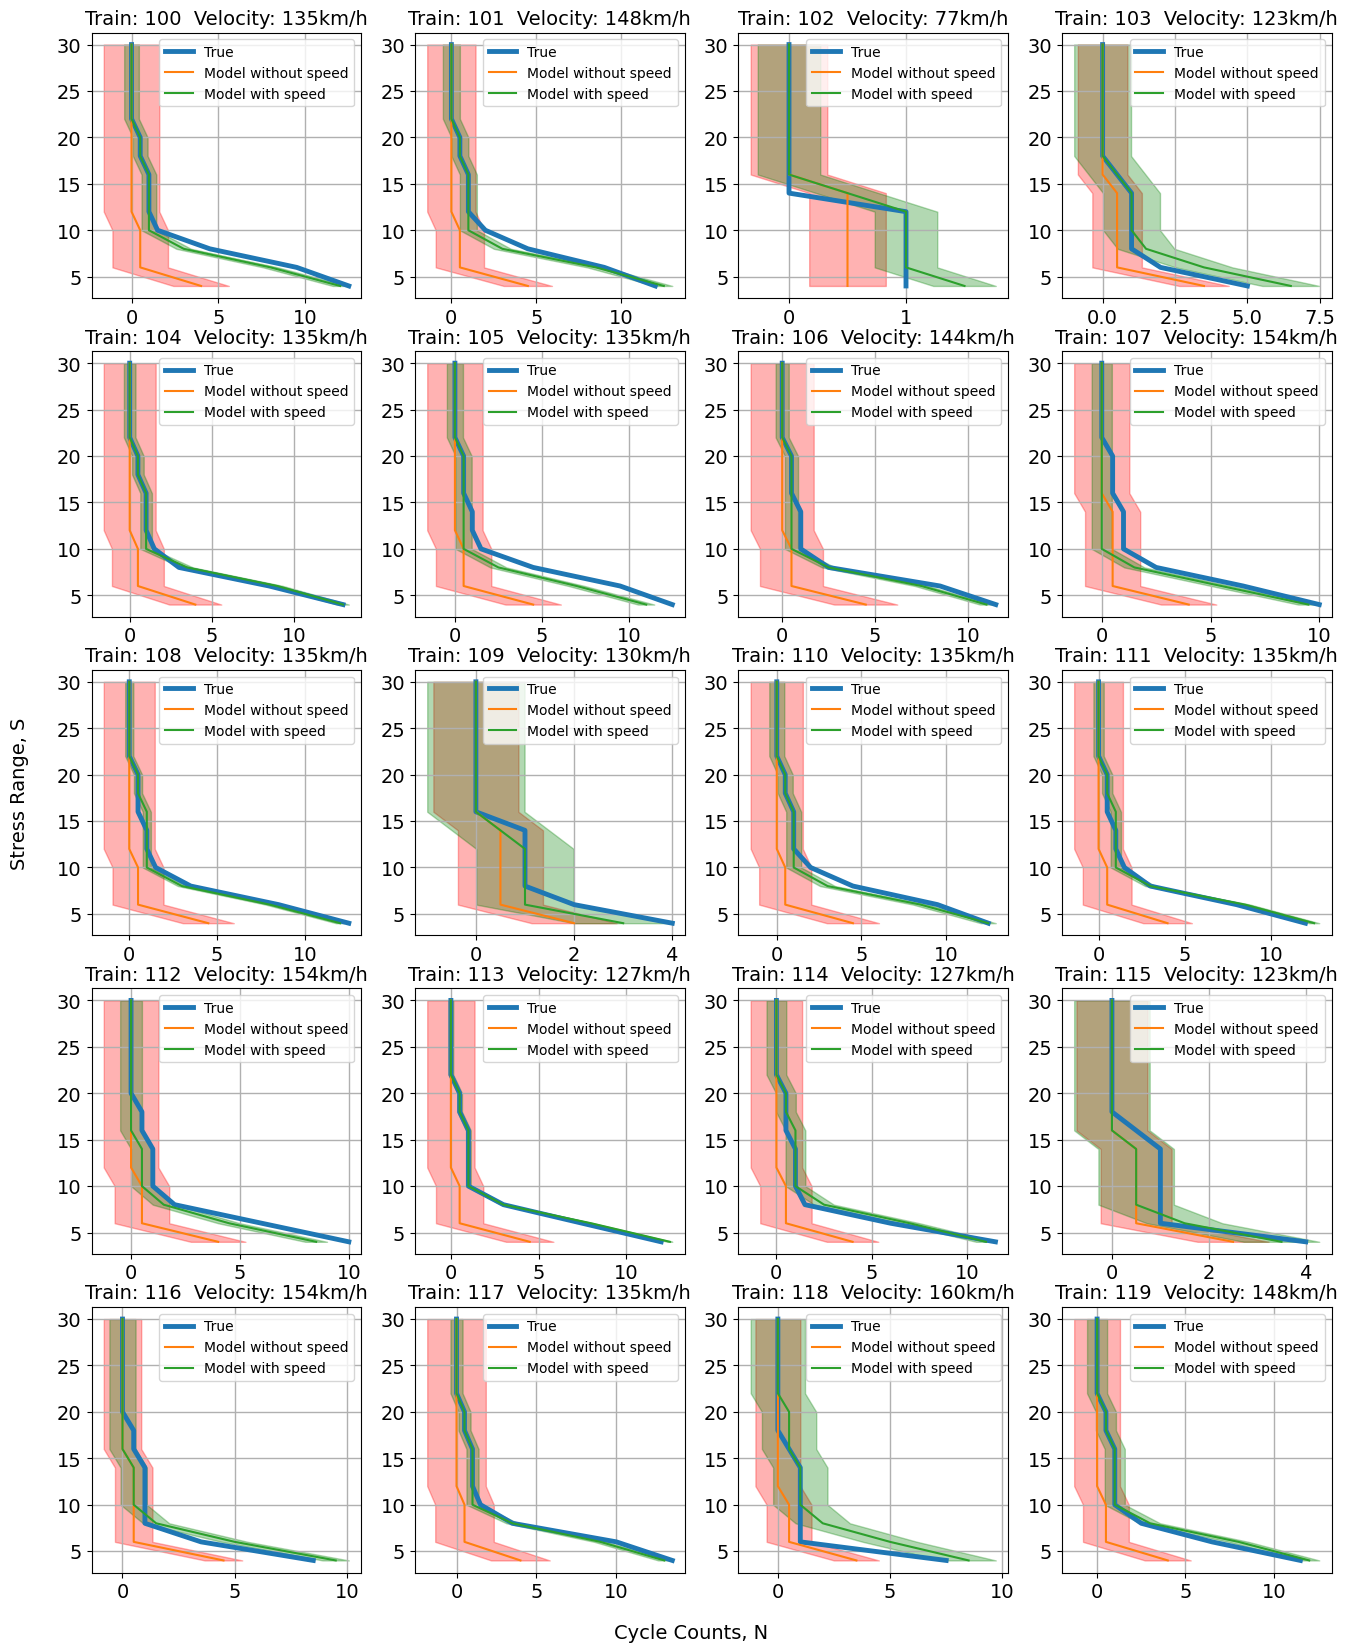

In [61]:
# plot all predictions on a plot with the same color
S = list(range(4,32,2))
figure, axes = plt.subplots(5, 4, figsize=(16, 20))


for i in range(len(rounded_predictions)):
    pre_N = rounded_predictions[i]
    N = data_testing_Y[i]
    Ncum = N.sum() - np.cumsum(N)
    pre_Ncum = pre_N.sum() - np.cumsum(pre_N)
    # calculate the one sigma of the prediction
    one_sigma = np.sqrt(np.mean((pre_N - N)**2))

    CNN_pre_N = CNN_rounded_predictions[i]
    CNN_pre_Ncum = CNN_pre_N.sum() - np.cumsum(CNN_pre_N)
    # calculate the one sigma of the prediction
    CNN_one_sigma = np.sqrt(np.mean((CNN_pre_N - N)**2))

    # Fixing the subplot indexing
    ax = axes[i // 4, i % 4]  # Ensure using idx here to calculate subplot positions
    ax.plot(Ncum, S, label='True', linewidth=3.5)
    ax.fill_betweenx(S, pre_Ncum-1*one_sigma, pre_Ncum+1*one_sigma, color='r', alpha=0.3)
    ax.fill_betweenx(S, CNN_pre_Ncum-1*CNN_one_sigma, CNN_pre_Ncum+1*CNN_one_sigma, color='g', alpha=0.3)

    ax.plot(pre_Ncum, S, label='Model without speed')
    ax.plot(CNN_pre_Ncum, S, label='Model with speed')
    ax.set_title(f'Train: {test_num[i]}  Velocity: {int(denormailzed_data_testing_speed[i][0])}km/h', fontsize=14)

    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.legend(prop={'size': 10})
    ax.grid(True, linewidth=1.0)

# Set common labels if needed
figure.text(0.5, 0.08, 'Cycle Counts, N', ha='center', va='center', fontsize=14)
figure.text(0.08, 0.5, 'Stress Range, S', ha='center', va='center', rotation='vertical', fontsize=14)

plt.show()

# Cross validation analysis

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#from ace_tools import display_dataframe_to_user

# Define the data for both scenarios

data_with_speed = {
    'fold': list(range(1, 11)),
    'averaged_loss': [0.2999, 0.28505, 0.34155, 0.31935, 0.29805, 0.3008, 0.30205, 0.31125, 0.3333, 0.3604],
    'averaged_mse': [0.20975, 0.1954, 0.23585, 0.2227, 0.20725, 0.20985, 0.2101, 0.2123, 0.23125, 0.25375],
    'averaged_val_loss': [0.3173, 0.2794, 0.30985, 0.34595, 0.2835, 0.3069, 0.3125, 0.35555, 0.35945, 0.407],
    'averaged_val_mse': [0.23365, 0.20235, 0.2244, 0.266, 0.2105, 0.2277, 0.2346, 0.23465, 0.2394, 0.2768],
    'averaged_test_loss': [0.459895525, 0.42893314, 0.31616375, 0.62399495, 0.728409115, 0.76706995, 0.792922435, 1.1663615, 0.365077325, 0.394282015],
    'averaged_test_mse': [0.269728765, 0.246206155, 0.173062615, 0.3536761, 0.38967078, 0.427128095, 0.448921765, 0.625560985, 0.239762315, 0.22190262]
}

data_without_speed = {
    'fold': list(range(1, 11)),
    'averaged_loss': [2.7973, 2.98485, 2.5147, 2.9014, 2.61215, 2.5937, 2.6976, 2.9561, 2.96585, 2.9286],
    'averaged_mse': [1.42995, 1.52255, 1.29725, 1.4802, 1.33845, 1.33825, 1.39385, 1.508, 1.51705, 1.5005],
    'averaged_val_loss': [1.65065, 1.6712, 1.7066, 1.721, 1.5966, 1.7444, 1.62965, 1.7344, 1.6583, 2.78935],
    'averaged_val_mse': [0.83185, 0.8414, 0.8751, 0.87585, 0.8487, 0.8927, 0.83925, 0.8723, 0.84425, 1.42205],
    'averaged_test_loss': [4.437159, 3.0023624, 3.7486485, 3.9122713, 3.2062186, 4.0360705, 3.00501585, 3.6560345, 2.5877453, 1.95569625],
    'averaged_test_mse': [2.22363325, 1.51462825, 1.88521905, 1.9600566, 1.6388432, 2.0312788, 1.52590185, 1.84024145, 1.3202522, 0.9876158]
}

# Create dataframes
df_with_speed = pd.DataFrame(data_with_speed)
df_with_speed['Model'] = 'With speed'

df_without_speed = pd.DataFrame(data_without_speed)
df_without_speed['Model'] = 'Without speed'

# Combine them
df_combined = pd.concat([df_with_speed, df_without_speed], ignore_index=True)

#display_dataframe_to_user("Comparison of Model Performance (With vs Without Speed)", df_combined)


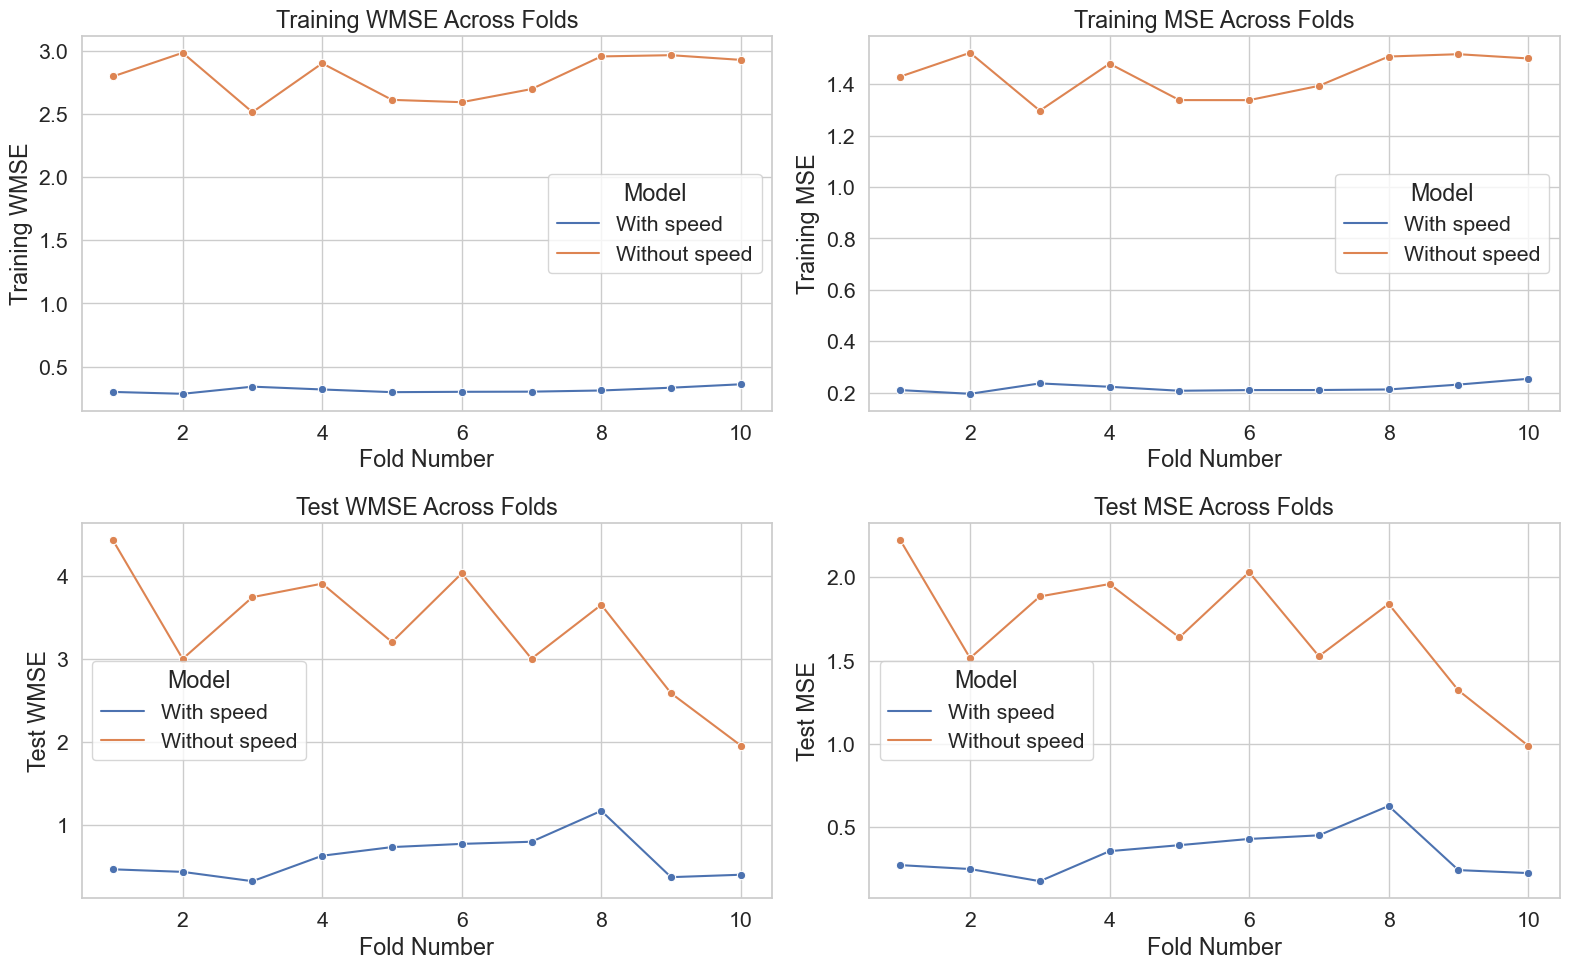

In [367]:
# Visualization comparing performance using line plots and boxplots

# Set up the plots
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
metrics = ['averaged_loss', 'averaged_mse', 'averaged_test_loss', 'averaged_test_mse']
titles = ['Training WMSE', 'Training MSE', 'Test WMSE', 'Test MSE']

for ax, metric, title in zip(axes.flatten(), metrics, titles):
    sns.lineplot(data=df_combined, x='fold', y=metric, hue='Model', marker='o', ax=ax)
    ax.set_title(f'{title} Across Folds')
    ax.set_xlabel('Fold Number')
    ax.set_ylabel(title)
    ax.grid(True)

plt.tight_layout()
plt.show()



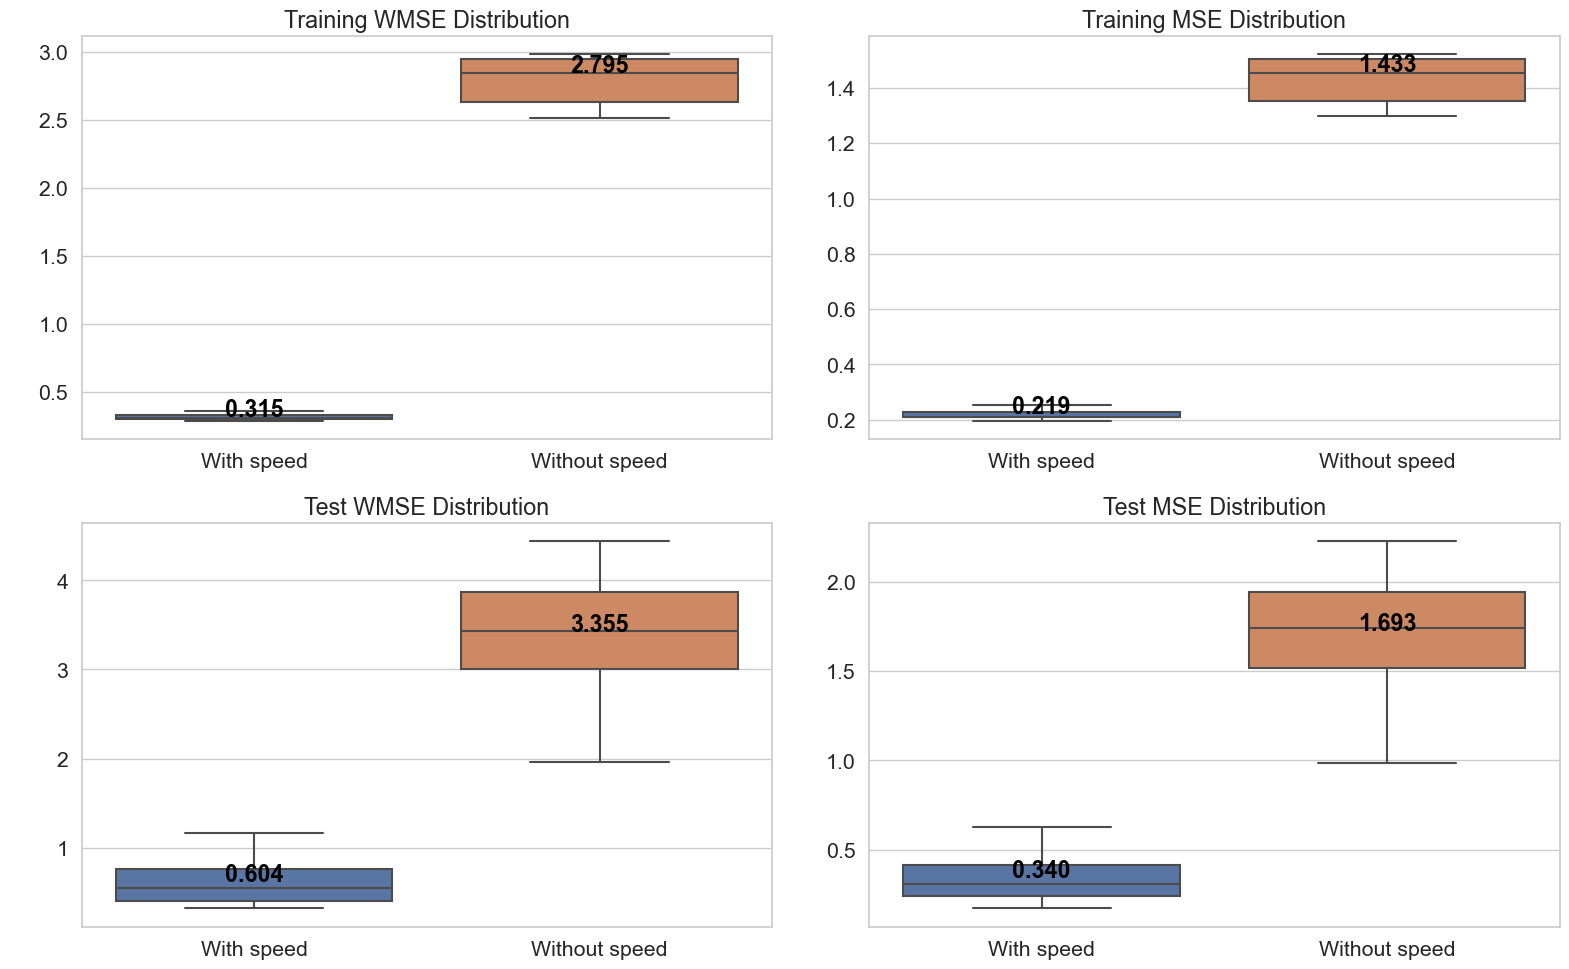

In [365]:
# Create annotated boxplots for the four key metrics

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
metrics = ['averaged_loss', 'averaged_mse', 'averaged_test_loss', 'averaged_test_mse']
titles = ['Training WMSE', 'Training MSE', 'Test WMSE', 'Test MSE']

for ax, metric, title in zip(axes.flatten(), metrics, titles):
    sns.boxplot(data=df_combined, x='Model', y=metric, ax=ax)

    # Annotate each boxplot with mean values
    for i, condition in enumerate(['With speed', 'Without speed']):
        mean_val = df_combined[df_combined['Model'] == condition][metric].mean()
        ax.text(i, mean_val + 0.02 * mean_val, f'{mean_val:.3f}', 
                horizontalalignment='center', color='black', weight='bold')
    
    ax.set_title(f'{title} Distribution')
    ax.set_xlabel('')
    ax.set_ylabel(" ")

plt.tight_layout()
plt.show()


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


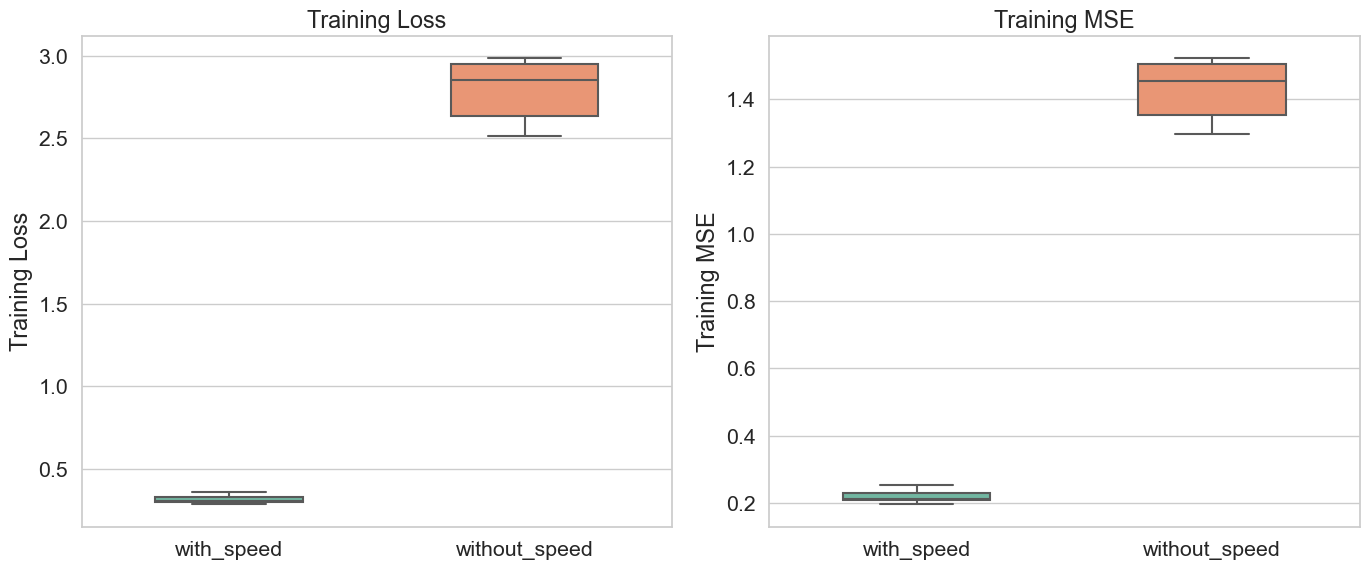

In [331]:
# Refined boxplots for journal-quality presentation, separated for training and test metrics

# Set a consistent aesthetic
sns.set(style="whitegrid", font_scale=1.4)

# Plot for training metrics
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
training_metrics = ['averaged_loss', 'averaged_mse']
training_titles = ['Training Loss', 'Training MSE']

for ax, metric, title in zip(axes, training_metrics, training_titles):
    sns.boxplot(data=df_combined, x='condition', y=metric, ax=ax, palette="Set2", width=0.5)
    # Annotate mean
    for i, condition in enumerate(['with speed', 'without speed']):
        mean_val = df_combined[df_combined['condition'] == condition][metric].mean()
        ax.text(i, mean_val + 0.02 * mean_val, f'{mean_val:.3f}',
                ha='center', va='bottom', fontsize=12, fontweight='bold')
    ax.set_title(title)
    ax.set_xlabel('')
    ax.set_ylabel(title)

plt.tight_layout()
plt.show()




PermissionError: [Errno 13] Permission denied: 'Figure 19.svg'

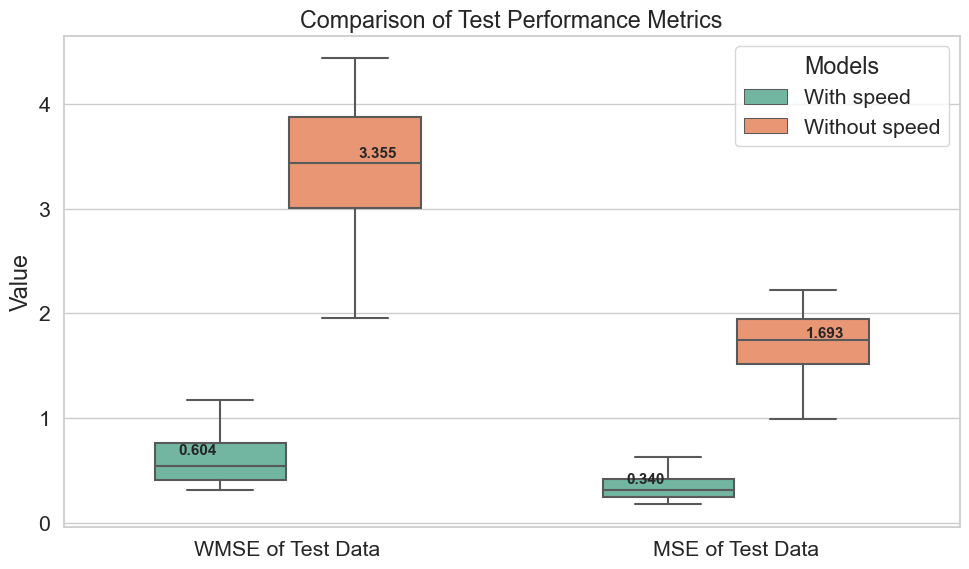

In [386]:

# Prepare test metric data for all in one boxplot
test_metrics_all = df_combined.melt(
    id_vars='Model',
    value_vars=['averaged_test_loss', 'averaged_test_mse'],
    var_name='Metric',
    value_name='Value'
)

# Rename metrics for axis labeling
metric_labels = {
    'averaged_test_loss': 'WMSE of Test Data',
    'averaged_test_mse': 'MSE of Test Data'
}
test_metrics_all['Metric'] = test_metrics_all['Metric'].map(metric_labels)

# Create combined boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=test_metrics_all, x='Metric', y='Value', hue='Model', palette='Set2', width=0.6)

# Annotate mean values
for i, metric in enumerate(test_metrics_all['Metric'].unique()):
    for j, model in enumerate(['With speed', 'Without speed']):
        mean_val = test_metrics_all[
            (test_metrics_all['Metric'] == metric) & (test_metrics_all['Model'] == model)
        ]['Value'].mean()
        xpos = i - 0.2 + j * 0.4
        plt.text(xpos, mean_val + 0.03 * mean_val, f'{mean_val:.3f}',
                 ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.title("Comparison of Test Performance Metrics")
plt.xlabel("")
plt.ylabel("Value")
plt.legend(title="Models", loc='upper right')
plt.tight_layout()

# save the figure with svg format
plt.savefig('Figure 19.svg', dpi=500, format='svg')

plt.show()


NameError: name 'highlight_data' is not defined

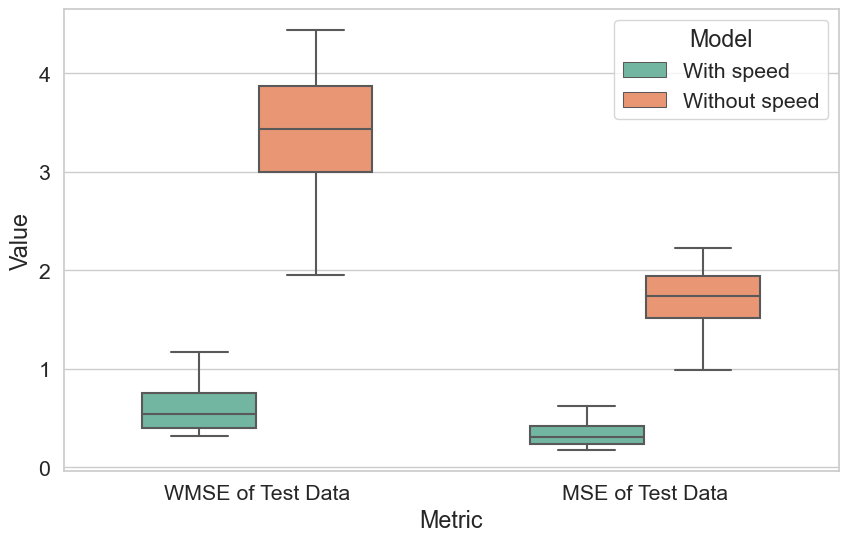

In [379]:
# Add percentage improvement to the annotation text
plt.figure(figsize=(10, 6))
sns.boxplot(data=test_metrics_all, x='Metric', y='Value', hue='Model', palette='Set2', width=0.6)

# Annotate mean values and improvement arrows with percentage
for i, row in highlight_data.iterrows():
    for j, model in enumerate(['With speed', 'Without speed']):
        mean_val = row[model]
        xpos = i - 0.2 + j * 0.4
        plt.text(xpos, mean_val + 0.03 * mean_val, f'{mean_val:.3f}',
                 ha='center', va='bottom', fontsize=11, fontweight='bold')

    # Annotate improvement arrow and percentage
    mid_x = i
    y_start = row['Without speed']
    y_end = row['With speed']
    improvement = row['Improvement']
    perc_improvement = (improvement / y_start) * 100

    plt.annotate(
        "", xy=(mid_x, y_end), xytext=(mid_x, y_start),
        arrowprops=dict(arrowstyle="->", color='red', lw=2),
        annotation_clip=False
    )
    plt.text(mid_x, (y_start + y_end)/2, f"-{improvement:.2f}\n({perc_improvement:.1f}%)",
             ha='center', va='center', fontsize=11, color='red', fontweight='bold')

plt.title("Comparison of Test Performance with Highlighted Improvements")
plt.xlabel("")
plt.ylabel("Value")
plt.legend(title="Model", loc='upper right')
plt.tight_layout()
plt.show()


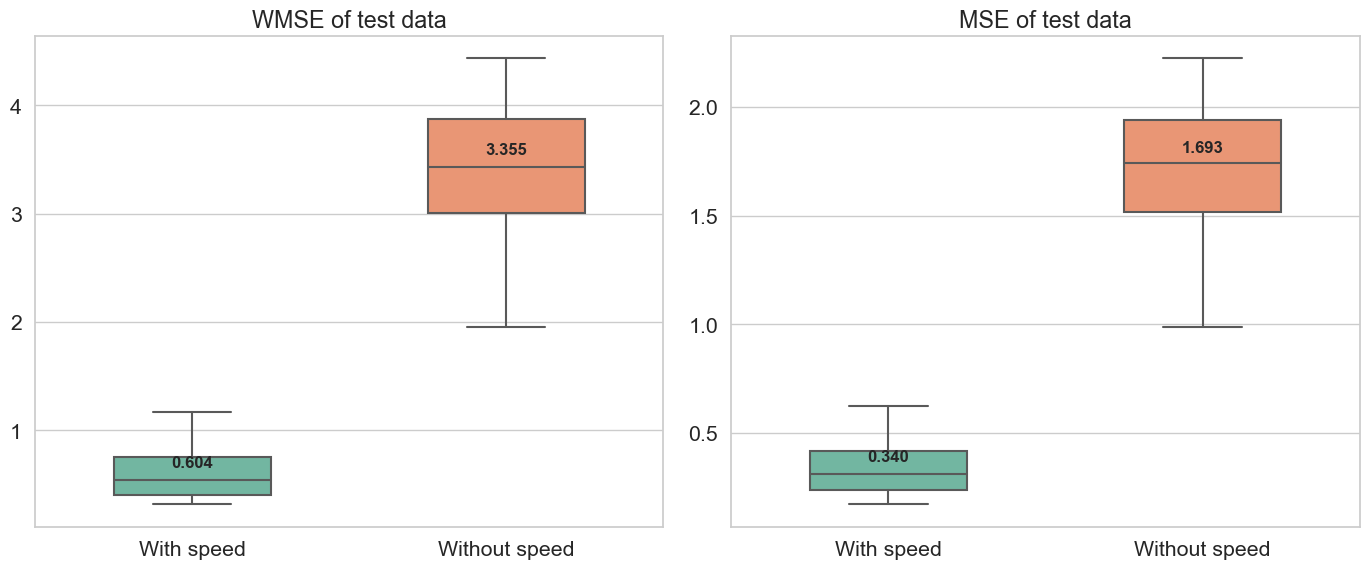

In [376]:
# Plot for test metrics
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
test_metrics = ['averaged_test_loss', 'averaged_test_mse']
test_titles = ['WMSE of test data', 'MSE of test data']

for ax, metric, title in zip(axes, test_metrics, test_titles):
    sns.boxplot(data=df_combined, x='Model', y=metric, ax=ax, palette="Set2", width=0.5)
    # Annotate mean
    for i, condition in enumerate(['With speed', 'Without speed']):
        mean_val = df_combined[df_combined['Model'] == condition][metric].mean()
        ax.text(i, mean_val + 0.05 * mean_val, f'{mean_val:.3f}',
                ha='center', va='bottom', fontsize=12, fontweight='bold')
    ax.set_title(title)
    ax.set_xlabel('')
    ax.set_ylabel("")

plt.tight_layout()
plt.show()

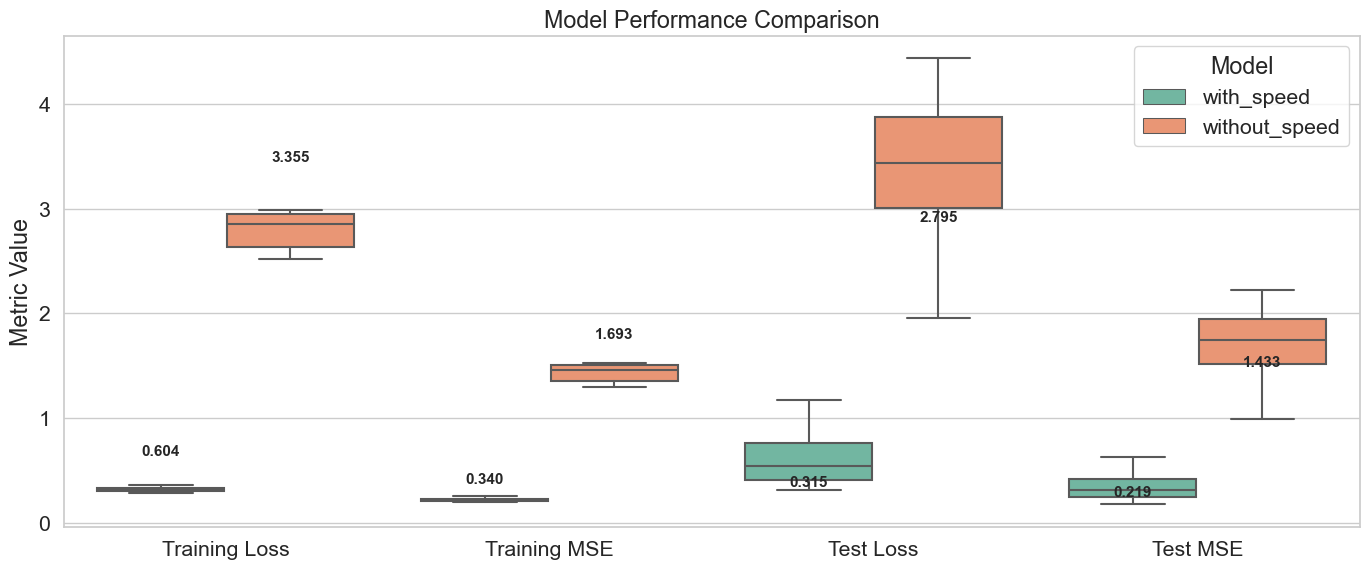

In [345]:
# Journal-style single boxplot diagram with all four test metrics side by side

# Prepare data in long format for seaborn
test_metrics_long = df_combined.melt(
    id_vars='model',
    value_vars=[ 'averaged_loss', 'averaged_mse','averaged_test_loss', 'averaged_test_mse'],
    var_name='Metric',
    value_name='Value'
)

# Mapping for prettier metric names
metric_labels = {
    'averaged_loss': 'Training Loss',
    'averaged_mse': 'Training MSE',
    'averaged_test_loss': 'Test Loss',
    'averaged_test_mse': 'Test MSE'

}
test_metrics_long['Metric'] = test_metrics_long['Metric'].map(metric_labels)

# Create the boxplot
plt.figure(figsize=(14, 6))
sns.boxplot(data=test_metrics_long, x='Metric', y='Value', hue='model', palette='Set2')

# Annotate means
for i, (metric, group) in enumerate(test_metrics_long.groupby('Metric')):
    for j, condition in enumerate(['with_speed', 'without_speed']):
        mean_val = group[group['model'] == condition]['Value'].mean()
        xpos = i - 0.2 + j * 0.4
        plt.text(xpos, mean_val + 0.02 * mean_val, f'{mean_val:.3f}',
                 ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.title("Model Performance Comparison")
plt.xlabel("")
plt.ylabel("Metric Value")
plt.legend(title='Model')
plt.tight_layout()
plt.show()
